In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics.functional import accuracy
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard
import tensorboardX

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style="darkgrid", palette = 'muted', font_scale = 1.2)

HAPPY_COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS))

In [3]:
pl.seed_everything(36)

Seed set to 36


36

In [9]:
from SRC import data_proccessing as dp

In [11]:
filepath = r'C:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V1\data\influxdb_subset_2025-03-11_21-24_to_21-27.csv'
tiny = dp.load_data(filepath)
print(tiny.head())
tiny = tiny.drop(columns=['Pressure_BlowerOutlet'])

tiny, label_encoder = dp.preprocess_data(tiny)
train_data, test_data = dp.split_data(tiny)
X_train, y_train = dp.get_features_and_labels(train_data)
X_test, y_test = dp.get_features_and_labels(test_data)
FEATURE_COLS = [col for col in train_data.columns if col.startswith('Pressure_')]
LABEL_COL = 'RabbitPosition'  # Change if your label column is named differently


                        time  Pressure_BlowerInlet  Pressure_BlowerOutlet  \
0  2025-03-11 21:24:00+00:00              0.036741               0.042908   
1  2025-03-11 21:24:01+00:00              0.051835               0.058001   
2  2025-03-11 21:24:02+00:00              0.037630               0.065101   
3  2025-03-11 21:24:03+00:00              0.040292               0.057112   
4  2025-03-11 21:24:04+00:00              0.033190               0.050898   

   Pressure_HotCell  Pressure_HotCellYPipe  Pressure_TargetStation  \
0         -0.037972              65.306938                0.034677   
1         -0.018441              65.389931                0.029797   
2         -0.013559              65.345993               -0.004367   
3         -0.003797              65.389931                0.024915   
4         -0.033089              65.272774                0.024915   

   Pressure_TargetStationYPipe  RabbitPosition  
0                    65.435593               4  
1                 

In [15]:
class PositionDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_cols, label_col):
        self.features = df[feature_cols].to_numpy(dtype=np.float32)
        self.labels = df[label_col].to_numpy(dtype=np.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            'sequence': features,
            'label': label
        }

class PositionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, feature_cols, label_col, batch_size=1):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = PositionDataset(self.train_df, self.feature_cols, self.label_col)
        self.test_dataset = PositionDataset(self.test_df, self.feature_cols, self.label_col)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [23]:
epochs = 250
batch_size = 1

data_module = PositionDataModule(
    train_data, test_data, FEATURE_COLS, LABEL_COL, batch_size=1
)

In [24]:
class PositionModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(n_hidden, n_classes)
        )

    def forward(self, x):
        return self.classifier(x)

class PositionPredictor(pl.LightningModule):
  def __init__(self, n_features: int, n_classes: int):
    super().__init__()
    self.model = PositionModel(n_features, n_classes)
    self.loss_fn = nn.CrossEntropyLoss()
    self.n_classes = n_classes

  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.loss_fn(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('training_loss', loss, prog_bar = True, logger = True)
    self.log('training_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('val_loss', loss, prog_bar = True, logger = True)
    self.log('val_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('test_loss', loss, prog_bar = True, logger = True)
    self.log('test_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

In [25]:
unique_classes = len(label_encoder.classes_)
print(f"Number of unique classes: {unique_classes}")

model = PositionPredictor(
    n_features=len(FEATURE_COLS),
    n_classes=unique_classes
)

Number of unique classes: 3


In [26]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 5812), started 0:02:24 ago. (Use '!kill 5812' to kill it.)

In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('lightning_logs', name='surface-prediction')

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=epochs,
    accelerator='cpu',
    devices=1,
    enable_progress_bar=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model, data_module)

c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V2\checkpoints exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | PositionModel    | 2.3 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 144/144 [00:01<00:00, 132.39it/s, v_num=1, training_loss=0.121, training_acc=1.000, val_loss=0.641, val_acc=0.750]

Epoch 0, global step 144: 'val_loss' reached 0.64099 (best 0.64099), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 144/144 [00:00<00:00, 149.15it/s, v_num=1, training_loss=0.693, training_acc=1.000, val_loss=0.575, val_acc=0.750] 

Epoch 1, global step 288: 'val_loss' reached 0.57450 (best 0.57450), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 144/144 [00:01<00:00, 134.42it/s, v_num=1, training_loss=2.640, training_acc=0.000, val_loss=0.627, val_acc=0.750] 

Epoch 2, global step 432: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 144/144 [00:00<00:00, 157.96it/s, v_num=1, training_loss=0.182, training_acc=1.000, val_loss=0.552, val_acc=0.778]  

Epoch 3, global step 576: 'val_loss' reached 0.55155 (best 0.55155), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 144/144 [00:00<00:00, 151.92it/s, v_num=1, training_loss=0.0221, training_acc=1.000, val_loss=0.594, val_acc=0.778]

Epoch 4, global step 720: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 144/144 [00:00<00:00, 152.42it/s, v_num=1, training_loss=0.509, training_acc=1.000, val_loss=0.625, val_acc=0.750]  

Epoch 5, global step 864: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 144/144 [00:00<00:00, 161.14it/s, v_num=1, training_loss=1.610, training_acc=0.000, val_loss=0.580, val_acc=0.750]  

Epoch 6, global step 1008: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 144/144 [00:00<00:00, 159.48it/s, v_num=1, training_loss=0.0106, training_acc=1.000, val_loss=0.614, val_acc=0.750] 

Epoch 7, global step 1152: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 144/144 [00:00<00:00, 159.52it/s, v_num=1, training_loss=0.271, training_acc=1.000, val_loss=0.586, val_acc=0.750]  

Epoch 8, global step 1296: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 144/144 [00:00<00:00, 167.09it/s, v_num=1, training_loss=1.940, training_acc=0.000, val_loss=0.578, val_acc=0.778]  

Epoch 9, global step 1440: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 144/144 [00:00<00:00, 154.21it/s, v_num=1, training_loss=0.234, training_acc=1.000, val_loss=0.632, val_acc=0.750]  

Epoch 10, global step 1584: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 144/144 [00:00<00:00, 156.36it/s, v_num=1, training_loss=0.0815, training_acc=1.000, val_loss=0.587, val_acc=0.750] 

Epoch 11, global step 1728: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 144/144 [00:00<00:00, 149.11it/s, v_num=1, training_loss=0.615, training_acc=1.000, val_loss=0.542, val_acc=0.806]   

Epoch 12, global step 1872: 'val_loss' reached 0.54212 (best 0.54212), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 13: 100%|██████████| 144/144 [00:00<00:00, 158.23it/s, v_num=1, training_loss=0.434, training_acc=1.000, val_loss=0.559, val_acc=0.778]   

Epoch 13, global step 2016: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 144/144 [00:00<00:00, 154.23it/s, v_num=1, training_loss=0.0033, training_acc=1.000, val_loss=0.562, val_acc=0.778] 

Epoch 14, global step 2160: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 144/144 [00:01<00:00, 138.04it/s, v_num=1, training_loss=0.253, training_acc=1.000, val_loss=0.554, val_acc=0.778]   

Epoch 15, global step 2304: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 144/144 [00:01<00:00, 139.03it/s, v_num=1, training_loss=2.220, training_acc=0.000, val_loss=0.495, val_acc=0.806]   

Epoch 16, global step 2448: 'val_loss' reached 0.49542 (best 0.49542), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 17: 100%|██████████| 144/144 [00:01<00:00, 141.65it/s, v_num=1, training_loss=1.650, training_acc=0.000, val_loss=0.603, val_acc=0.778]  

Epoch 17, global step 2592: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 144/144 [00:01<00:00, 136.50it/s, v_num=1, training_loss=0.135, training_acc=1.000, val_loss=0.518, val_acc=0.778]  

Epoch 18, global step 2736: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 144/144 [00:01<00:00, 133.97it/s, v_num=1, training_loss=0.129, training_acc=1.000, val_loss=0.508, val_acc=0.778]   

Epoch 19, global step 2880: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 144/144 [00:01<00:00, 119.65it/s, v_num=1, training_loss=0.180, training_acc=1.000, val_loss=0.499, val_acc=0.806]   

Epoch 20, global step 3024: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 144/144 [00:00<00:00, 151.79it/s, v_num=1, training_loss=0.204, training_acc=1.000, val_loss=0.511, val_acc=0.778]   

Epoch 21, global step 3168: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 144/144 [00:00<00:00, 162.54it/s, v_num=1, training_loss=2.200, training_acc=0.000, val_loss=0.636, val_acc=0.778]   

Epoch 22, global step 3312: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 144/144 [00:00<00:00, 160.06it/s, v_num=1, training_loss=0.224, training_acc=1.000, val_loss=0.539, val_acc=0.778]  

Epoch 23, global step 3456: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 144/144 [00:00<00:00, 147.04it/s, v_num=1, training_loss=1.860, training_acc=0.000, val_loss=0.507, val_acc=0.778]  

Epoch 24, global step 3600: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 144/144 [00:00<00:00, 147.57it/s, v_num=1, training_loss=0.969, training_acc=0.000, val_loss=0.581, val_acc=0.778]   

Epoch 25, global step 3744: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 144/144 [00:01<00:00, 140.88it/s, v_num=1, training_loss=0.266, training_acc=1.000, val_loss=0.514, val_acc=0.778]   

Epoch 26, global step 3888: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 144/144 [00:00<00:00, 149.50it/s, v_num=1, training_loss=2.330, training_acc=0.000, val_loss=0.573, val_acc=0.778]   

Epoch 27, global step 4032: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 144/144 [00:01<00:00, 139.78it/s, v_num=1, training_loss=2.270, training_acc=0.000, val_loss=0.578, val_acc=0.778]   

Epoch 28, global step 4176: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 144/144 [00:01<00:00, 129.06it/s, v_num=1, training_loss=0.312, training_acc=1.000, val_loss=0.544, val_acc=0.778]   

Epoch 29, global step 4320: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 144/144 [00:01<00:00, 141.25it/s, v_num=1, training_loss=1.680, training_acc=0.000, val_loss=0.605, val_acc=0.778]   

Epoch 30, global step 4464: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 144/144 [00:01<00:00, 112.65it/s, v_num=1, training_loss=1.640, training_acc=0.000, val_loss=0.542, val_acc=0.778]   

Epoch 31, global step 4608: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 144/144 [00:01<00:00, 123.37it/s, v_num=1, training_loss=0.443, training_acc=1.000, val_loss=0.548, val_acc=0.778]   

Epoch 32, global step 4752: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 144/144 [00:01<00:00, 131.15it/s, v_num=1, training_loss=0.292, training_acc=1.000, val_loss=0.513, val_acc=0.806]   

Epoch 33, global step 4896: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 144/144 [00:01<00:00, 136.59it/s, v_num=1, training_loss=0.206, training_acc=1.000, val_loss=0.513, val_acc=0.806]   

Epoch 34, global step 5040: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 144/144 [00:01<00:00, 133.37it/s, v_num=1, training_loss=0.274, training_acc=1.000, val_loss=0.496, val_acc=0.806]   

Epoch 35, global step 5184: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 144/144 [00:01<00:00, 119.27it/s, v_num=1, training_loss=0.272, training_acc=1.000, val_loss=0.561, val_acc=0.778]   

Epoch 36, global step 5328: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 144/144 [00:01<00:00, 141.60it/s, v_num=1, training_loss=0.152, training_acc=1.000, val_loss=0.548, val_acc=0.778]   

Epoch 37, global step 5472: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 144/144 [00:01<00:00, 137.16it/s, v_num=1, training_loss=0.259, training_acc=1.000, val_loss=0.486, val_acc=0.833]   

Epoch 38, global step 5616: 'val_loss' reached 0.48584 (best 0.48584), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 39: 100%|██████████| 144/144 [00:01<00:00, 130.84it/s, v_num=1, training_loss=0.958, training_acc=0.000, val_loss=0.505, val_acc=0.861]   

Epoch 39, global step 5760: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 144/144 [00:01<00:00, 113.47it/s, v_num=1, training_loss=0.436, training_acc=1.000, val_loss=0.441, val_acc=0.833]   

Epoch 40, global step 5904: 'val_loss' reached 0.44145 (best 0.44145), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 41: 100%|██████████| 144/144 [00:01<00:00, 138.76it/s, v_num=1, training_loss=0.203, training_acc=1.000, val_loss=0.505, val_acc=0.806]   

Epoch 41, global step 6048: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 144/144 [00:00<00:00, 152.23it/s, v_num=1, training_loss=0.343, training_acc=1.000, val_loss=0.476, val_acc=0.833]   

Epoch 42, global step 6192: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 144/144 [00:00<00:00, 144.70it/s, v_num=1, training_loss=0.211, training_acc=1.000, val_loss=0.501, val_acc=0.833]   

Epoch 43, global step 6336: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 144/144 [00:01<00:00, 126.54it/s, v_num=1, training_loss=0.192, training_acc=1.000, val_loss=0.494, val_acc=0.833]   

Epoch 44, global step 6480: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 144/144 [00:01<00:00, 140.36it/s, v_num=1, training_loss=0.0809, training_acc=1.000, val_loss=0.470, val_acc=0.833]  

Epoch 45, global step 6624: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 144/144 [00:01<00:00, 131.75it/s, v_num=1, training_loss=0.291, training_acc=1.000, val_loss=0.499, val_acc=0.833]   

Epoch 46, global step 6768: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 144/144 [00:00<00:00, 145.21it/s, v_num=1, training_loss=0.131, training_acc=1.000, val_loss=0.476, val_acc=0.833]   

Epoch 47, global step 6912: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 144/144 [00:01<00:00, 117.69it/s, v_num=1, training_loss=1.550, training_acc=0.000, val_loss=0.483, val_acc=0.861]   

Epoch 48, global step 7056: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 144/144 [00:00<00:00, 147.97it/s, v_num=1, training_loss=2.140, training_acc=0.000, val_loss=0.498, val_acc=0.806]   

Epoch 49, global step 7200: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 144/144 [00:01<00:00, 120.66it/s, v_num=1, training_loss=1.130, training_acc=0.000, val_loss=0.472, val_acc=0.833]  

Epoch 50, global step 7344: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 144/144 [00:01<00:00, 131.25it/s, v_num=1, training_loss=0.179, training_acc=1.000, val_loss=0.455, val_acc=0.833]   

Epoch 51, global step 7488: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 144/144 [00:01<00:00, 127.56it/s, v_num=1, training_loss=0.369, training_acc=1.000, val_loss=0.509, val_acc=0.861]   

Epoch 52, global step 7632: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 144/144 [00:00<00:00, 148.95it/s, v_num=1, training_loss=0.269, training_acc=1.000, val_loss=0.457, val_acc=0.833]   

Epoch 53, global step 7776: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 144/144 [00:00<00:00, 151.81it/s, v_num=1, training_loss=0.510, training_acc=1.000, val_loss=0.412, val_acc=0.861]   

Epoch 54, global step 7920: 'val_loss' reached 0.41228 (best 0.41228), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 55: 100%|██████████| 144/144 [00:00<00:00, 156.20it/s, v_num=1, training_loss=2.560, training_acc=0.000, val_loss=0.472, val_acc=0.861]  

Epoch 55, global step 8064: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 144/144 [00:00<00:00, 156.32it/s, v_num=1, training_loss=0.282, training_acc=1.000, val_loss=0.456, val_acc=0.833]   

Epoch 56, global step 8208: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 144/144 [00:00<00:00, 161.93it/s, v_num=1, training_loss=0.179, training_acc=1.000, val_loss=0.456, val_acc=0.861]   

Epoch 57, global step 8352: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 144/144 [00:00<00:00, 155.59it/s, v_num=1, training_loss=0.158, training_acc=1.000, val_loss=0.436, val_acc=0.861]   

Epoch 58, global step 8496: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 144/144 [00:00<00:00, 152.79it/s, v_num=1, training_loss=0.448, training_acc=1.000, val_loss=0.425, val_acc=0.861]   

Epoch 59, global step 8640: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 144/144 [00:00<00:00, 156.03it/s, v_num=1, training_loss=0.127, training_acc=1.000, val_loss=0.464, val_acc=0.833]   

Epoch 60, global step 8784: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 144/144 [00:00<00:00, 148.59it/s, v_num=1, training_loss=0.130, training_acc=1.000, val_loss=0.444, val_acc=0.833]   

Epoch 61, global step 8928: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 144/144 [00:01<00:00, 136.02it/s, v_num=1, training_loss=0.164, training_acc=1.000, val_loss=0.435, val_acc=0.833]   

Epoch 62, global step 9072: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 144/144 [00:01<00:00, 123.55it/s, v_num=1, training_loss=1.660, training_acc=0.000, val_loss=0.485, val_acc=0.833]  

Epoch 63, global step 9216: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 144/144 [00:01<00:00, 129.52it/s, v_num=1, training_loss=0.199, training_acc=1.000, val_loss=0.403, val_acc=0.833]  

Epoch 64, global step 9360: 'val_loss' reached 0.40262 (best 0.40262), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 65: 100%|██████████| 144/144 [00:00<00:00, 144.09it/s, v_num=1, training_loss=1.940, training_acc=0.000, val_loss=0.454, val_acc=0.861]   

Epoch 65, global step 9504: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 144/144 [00:01<00:00, 141.42it/s, v_num=1, training_loss=0.138, training_acc=1.000, val_loss=0.411, val_acc=0.833]   

Epoch 66, global step 9648: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 144/144 [00:01<00:00, 136.08it/s, v_num=1, training_loss=0.355, training_acc=1.000, val_loss=0.466, val_acc=0.889]   

Epoch 67, global step 9792: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 144/144 [00:01<00:00, 142.12it/s, v_num=1, training_loss=1.69e-5, training_acc=1.000, val_loss=0.467, val_acc=0.833] 

Epoch 68, global step 9936: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 144/144 [00:00<00:00, 146.72it/s, v_num=1, training_loss=0.319, training_acc=1.000, val_loss=0.436, val_acc=0.861]   

Epoch 69, global step 10080: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 144/144 [00:00<00:00, 164.13it/s, v_num=1, training_loss=0.214, training_acc=1.000, val_loss=0.404, val_acc=0.833]   

Epoch 70, global step 10224: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 144/144 [00:00<00:00, 159.30it/s, v_num=1, training_loss=0.0972, training_acc=1.000, val_loss=0.461, val_acc=0.833]  

Epoch 71, global step 10368: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 144/144 [00:00<00:00, 152.83it/s, v_num=1, training_loss=0.0154, training_acc=1.000, val_loss=0.441, val_acc=0.833]  

Epoch 72, global step 10512: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 144/144 [00:00<00:00, 150.61it/s, v_num=1, training_loss=0.341, training_acc=1.000, val_loss=0.416, val_acc=0.861]  

Epoch 73, global step 10656: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 144/144 [00:00<00:00, 150.89it/s, v_num=1, training_loss=0.237, training_acc=1.000, val_loss=0.464, val_acc=0.833]  

Epoch 74, global step 10800: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 144/144 [00:00<00:00, 158.01it/s, v_num=1, training_loss=0.000113, training_acc=1.000, val_loss=0.426, val_acc=0.833]

Epoch 75, global step 10944: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 144/144 [00:00<00:00, 144.84it/s, v_num=1, training_loss=0.0974, training_acc=1.000, val_loss=0.427, val_acc=0.833]  

Epoch 76, global step 11088: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 144/144 [00:00<00:00, 144.13it/s, v_num=1, training_loss=0.220, training_acc=1.000, val_loss=0.464, val_acc=0.833]  

Epoch 77, global step 11232: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 144/144 [00:00<00:00, 154.46it/s, v_num=1, training_loss=0.303, training_acc=1.000, val_loss=0.425, val_acc=0.889]   

Epoch 78, global step 11376: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 144/144 [00:00<00:00, 150.53it/s, v_num=1, training_loss=0.299, training_acc=1.000, val_loss=0.457, val_acc=0.833]   

Epoch 79, global step 11520: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 144/144 [00:00<00:00, 151.66it/s, v_num=1, training_loss=1.11e-5, training_acc=1.000, val_loss=0.465, val_acc=0.833]

Epoch 80, global step 11664: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 144/144 [00:01<00:00, 142.92it/s, v_num=1, training_loss=0.200, training_acc=1.000, val_loss=0.480, val_acc=0.833]   

Epoch 81, global step 11808: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 144/144 [00:01<00:00, 133.57it/s, v_num=1, training_loss=0.702, training_acc=1.000, val_loss=0.422, val_acc=0.889]   

Epoch 82, global step 11952: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 144/144 [00:01<00:00, 140.38it/s, v_num=1, training_loss=0.237, training_acc=1.000, val_loss=0.446, val_acc=0.889]   

Epoch 83, global step 12096: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 144/144 [00:01<00:00, 136.54it/s, v_num=1, training_loss=0.164, training_acc=1.000, val_loss=0.445, val_acc=0.889]  

Epoch 84, global step 12240: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 144/144 [00:01<00:00, 109.10it/s, v_num=1, training_loss=0.622, training_acc=1.000, val_loss=0.415, val_acc=0.833]   

Epoch 85, global step 12384: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 144/144 [00:01<00:00, 128.86it/s, v_num=1, training_loss=0.163, training_acc=1.000, val_loss=0.442, val_acc=0.833]   

Epoch 86, global step 12528: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 144/144 [00:01<00:00, 142.92it/s, v_num=1, training_loss=0.120, training_acc=1.000, val_loss=0.456, val_acc=0.833]  

Epoch 87, global step 12672: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 144/144 [00:00<00:00, 148.38it/s, v_num=1, training_loss=2.210, training_acc=0.000, val_loss=0.406, val_acc=0.889]   

Epoch 88, global step 12816: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 144/144 [00:01<00:00, 139.64it/s, v_num=1, training_loss=0.380, training_acc=1.000, val_loss=0.469, val_acc=0.889]   

Epoch 89, global step 12960: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 144/144 [00:01<00:00, 125.01it/s, v_num=1, training_loss=0.519, training_acc=1.000, val_loss=0.437, val_acc=0.889]   

Epoch 90, global step 13104: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 144/144 [00:01<00:00, 126.54it/s, v_num=1, training_loss=0.296, training_acc=1.000, val_loss=0.466, val_acc=0.833]  

Epoch 91, global step 13248: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 144/144 [00:01<00:00, 124.79it/s, v_num=1, training_loss=0.266, training_acc=1.000, val_loss=0.417, val_acc=0.889]   

Epoch 92, global step 13392: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 144/144 [00:00<00:00, 149.75it/s, v_num=1, training_loss=1.510, training_acc=0.000, val_loss=0.412, val_acc=0.889]   

Epoch 93, global step 13536: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 144/144 [00:01<00:00, 123.65it/s, v_num=1, training_loss=0.734, training_acc=1.000, val_loss=0.415, val_acc=0.889]  

Epoch 94, global step 13680: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 144/144 [00:00<00:00, 148.04it/s, v_num=1, training_loss=0.260, training_acc=1.000, val_loss=0.439, val_acc=0.889]   

Epoch 95, global step 13824: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 144/144 [00:01<00:00, 141.14it/s, v_num=1, training_loss=0.266, training_acc=1.000, val_loss=0.429, val_acc=0.889]  

Epoch 96, global step 13968: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 144/144 [00:00<00:00, 166.10it/s, v_num=1, training_loss=8.37e-5, training_acc=1.000, val_loss=0.468, val_acc=0.833] 

Epoch 97, global step 14112: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 144/144 [00:00<00:00, 156.75it/s, v_num=1, training_loss=0.252, training_acc=1.000, val_loss=0.416, val_acc=0.889]  

Epoch 98, global step 14256: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 144/144 [00:01<00:00, 140.98it/s, v_num=1, training_loss=0.201, training_acc=1.000, val_loss=0.410, val_acc=0.833]   

Epoch 99, global step 14400: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 144/144 [00:00<00:00, 162.09it/s, v_num=1, training_loss=0.147, training_acc=1.000, val_loss=0.420, val_acc=0.833]  

Epoch 100, global step 14544: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 144/144 [00:00<00:00, 164.70it/s, v_num=1, training_loss=0.633, training_acc=1.000, val_loss=0.428, val_acc=0.889]  

Epoch 101, global step 14688: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 144/144 [00:01<00:00, 137.53it/s, v_num=1, training_loss=1.650, training_acc=0.000, val_loss=0.436, val_acc=0.861]  

Epoch 102, global step 14832: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 144/144 [00:00<00:00, 147.44it/s, v_num=1, training_loss=0.420, training_acc=1.000, val_loss=0.448, val_acc=0.889]  

Epoch 103, global step 14976: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 144/144 [00:00<00:00, 148.69it/s, v_num=1, training_loss=0.117, training_acc=1.000, val_loss=0.414, val_acc=0.833]  

Epoch 104, global step 15120: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 144/144 [00:00<00:00, 152.51it/s, v_num=1, training_loss=1.940, training_acc=0.000, val_loss=0.447, val_acc=0.833]  

Epoch 105, global step 15264: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 144/144 [00:00<00:00, 167.64it/s, v_num=1, training_loss=0.165, training_acc=1.000, val_loss=0.393, val_acc=0.889]   

Epoch 106, global step 15408: 'val_loss' reached 0.39266 (best 0.39266), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 107: 100%|██████████| 144/144 [00:00<00:00, 165.24it/s, v_num=1, training_loss=1.010, training_acc=0.000, val_loss=0.418, val_acc=0.917]  

Epoch 107, global step 15552: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 144/144 [00:00<00:00, 152.59it/s, v_num=1, training_loss=0.250, training_acc=1.000, val_loss=0.420, val_acc=0.861]  

Epoch 108, global step 15696: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 144/144 [00:00<00:00, 166.01it/s, v_num=1, training_loss=1.55e-6, training_acc=1.000, val_loss=0.422, val_acc=0.833]

Epoch 109, global step 15840: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 144/144 [00:00<00:00, 170.32it/s, v_num=1, training_loss=0.141, training_acc=1.000, val_loss=0.404, val_acc=0.833]   

Epoch 110, global step 15984: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 144/144 [00:00<00:00, 168.88it/s, v_num=1, training_loss=0.182, training_acc=1.000, val_loss=0.437, val_acc=0.833]   

Epoch 111, global step 16128: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 144/144 [00:00<00:00, 157.57it/s, v_num=1, training_loss=0.104, training_acc=1.000, val_loss=0.434, val_acc=0.861]  

Epoch 112, global step 16272: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 144/144 [00:00<00:00, 152.49it/s, v_num=1, training_loss=0.152, training_acc=1.000, val_loss=0.382, val_acc=0.861]  

Epoch 113, global step 16416: 'val_loss' reached 0.38199 (best 0.38199), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 114: 100%|██████████| 144/144 [00:00<00:00, 159.20it/s, v_num=1, training_loss=0.116, training_acc=1.000, val_loss=0.436, val_acc=0.861]   

Epoch 114, global step 16560: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 144/144 [00:00<00:00, 156.28it/s, v_num=1, training_loss=0.000161, training_acc=1.000, val_loss=0.400, val_acc=0.889]

Epoch 115, global step 16704: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 144/144 [00:01<00:00, 138.98it/s, v_num=1, training_loss=0.212, training_acc=1.000, val_loss=0.395, val_acc=0.889]   

Epoch 116, global step 16848: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 144/144 [00:00<00:00, 149.39it/s, v_num=1, training_loss=0.114, training_acc=1.000, val_loss=0.454, val_acc=0.833]  

Epoch 117, global step 16992: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 144/144 [00:00<00:00, 154.50it/s, v_num=1, training_loss=1.310, training_acc=0.000, val_loss=0.472, val_acc=0.806]  

Epoch 118, global step 17136: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 144/144 [00:00<00:00, 152.86it/s, v_num=1, training_loss=2.080, training_acc=0.000, val_loss=0.429, val_acc=0.889]   

Epoch 119, global step 17280: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 144/144 [00:01<00:00, 137.06it/s, v_num=1, training_loss=0.160, training_acc=1.000, val_loss=0.376, val_acc=0.861]   

Epoch 120, global step 17424: 'val_loss' reached 0.37567 (best 0.37567), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 121: 100%|██████████| 144/144 [00:01<00:00, 140.67it/s, v_num=1, training_loss=0.419, training_acc=1.000, val_loss=0.422, val_acc=0.833]  

Epoch 121, global step 17568: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 144/144 [00:01<00:00, 141.27it/s, v_num=1, training_loss=2.120, training_acc=0.000, val_loss=0.429, val_acc=0.833]  

Epoch 122, global step 17712: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 144/144 [00:00<00:00, 148.07it/s, v_num=1, training_loss=0.0948, training_acc=1.000, val_loss=0.377, val_acc=0.889]  

Epoch 123, global step 17856: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 144/144 [00:00<00:00, 148.42it/s, v_num=1, training_loss=5.27e-5, training_acc=1.000, val_loss=0.375, val_acc=0.833]

Epoch 124, global step 18000: 'val_loss' reached 0.37485 (best 0.37485), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 125: 100%|██████████| 144/144 [00:00<00:00, 149.20it/s, v_num=1, training_loss=0.186, training_acc=1.000, val_loss=0.414, val_acc=0.889]  

Epoch 125, global step 18144: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 144/144 [00:00<00:00, 155.36it/s, v_num=1, training_loss=0.161, training_acc=1.000, val_loss=0.383, val_acc=0.889]   

Epoch 126, global step 18288: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 144/144 [00:00<00:00, 148.38it/s, v_num=1, training_loss=0.195, training_acc=1.000, val_loss=0.370, val_acc=0.861]   

Epoch 127, global step 18432: 'val_loss' reached 0.37038 (best 0.37038), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 128: 100%|██████████| 144/144 [00:00<00:00, 157.04it/s, v_num=1, training_loss=0.129, training_acc=1.000, val_loss=0.376, val_acc=0.889]   

Epoch 128, global step 18576: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 144/144 [00:00<00:00, 154.59it/s, v_num=1, training_loss=0.166, training_acc=1.000, val_loss=0.447, val_acc=0.833]  

Epoch 129, global step 18720: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 144/144 [00:01<00:00, 138.66it/s, v_num=1, training_loss=0.123, training_acc=1.000, val_loss=0.378, val_acc=0.917]   

Epoch 130, global step 18864: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 144/144 [00:00<00:00, 155.13it/s, v_num=1, training_loss=0.238, training_acc=1.000, val_loss=0.404, val_acc=0.889]  

Epoch 131, global step 19008: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 144/144 [00:00<00:00, 161.57it/s, v_num=1, training_loss=0.234, training_acc=1.000, val_loss=0.402, val_acc=0.917]   

Epoch 132, global step 19152: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 144/144 [00:01<00:00, 138.51it/s, v_num=1, training_loss=0.532, training_acc=1.000, val_loss=0.402, val_acc=0.889]   

Epoch 133, global step 19296: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 144/144 [00:00<00:00, 153.83it/s, v_num=1, training_loss=0.0752, training_acc=1.000, val_loss=0.375, val_acc=0.861]  

Epoch 134, global step 19440: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 144/144 [00:01<00:00, 143.69it/s, v_num=1, training_loss=2.15e-6, training_acc=1.000, val_loss=0.368, val_acc=0.889]

Epoch 135, global step 19584: 'val_loss' reached 0.36773 (best 0.36773), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 136: 100%|██████████| 144/144 [00:00<00:00, 159.26it/s, v_num=1, training_loss=0.448, training_acc=1.000, val_loss=0.395, val_acc=0.889]  

Epoch 136, global step 19728: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 144/144 [00:01<00:00, 135.74it/s, v_num=1, training_loss=0.101, training_acc=1.000, val_loss=0.396, val_acc=0.889]  

Epoch 137, global step 19872: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 144/144 [00:01<00:00, 135.03it/s, v_num=1, training_loss=2.550, training_acc=0.000, val_loss=0.391, val_acc=0.861]  

Epoch 138, global step 20016: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 144/144 [00:00<00:00, 158.46it/s, v_num=1, training_loss=0.168, training_acc=1.000, val_loss=0.430, val_acc=0.833]   

Epoch 139, global step 20160: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 144/144 [00:00<00:00, 157.77it/s, v_num=1, training_loss=0.214, training_acc=1.000, val_loss=0.421, val_acc=0.861]   

Epoch 140, global step 20304: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 144/144 [00:01<00:00, 143.57it/s, v_num=1, training_loss=0.110, training_acc=1.000, val_loss=0.390, val_acc=0.889]   

Epoch 141, global step 20448: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 144/144 [00:00<00:00, 147.40it/s, v_num=1, training_loss=0.138, training_acc=1.000, val_loss=0.409, val_acc=0.833]  

Epoch 142, global step 20592: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 144/144 [00:01<00:00, 139.77it/s, v_num=1, training_loss=0.786, training_acc=0.000, val_loss=0.435, val_acc=0.889]  

Epoch 143, global step 20736: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 144/144 [00:00<00:00, 150.72it/s, v_num=1, training_loss=0.115, training_acc=1.000, val_loss=0.378, val_acc=0.889]  

Epoch 144, global step 20880: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 144/144 [00:00<00:00, 154.05it/s, v_num=1, training_loss=0.132, training_acc=1.000, val_loss=0.402, val_acc=0.889]  

Epoch 145, global step 21024: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 144/144 [00:00<00:00, 150.13it/s, v_num=1, training_loss=0.209, training_acc=1.000, val_loss=0.431, val_acc=0.889]  

Epoch 146, global step 21168: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 144/144 [00:00<00:00, 156.88it/s, v_num=1, training_loss=0.338, training_acc=1.000, val_loss=0.373, val_acc=0.889]   

Epoch 147, global step 21312: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 144/144 [00:00<00:00, 155.56it/s, v_num=1, training_loss=1.990, training_acc=0.000, val_loss=0.401, val_acc=0.833]  

Epoch 148, global step 21456: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 144/144 [00:00<00:00, 151.90it/s, v_num=1, training_loss=2.38e-7, training_acc=1.000, val_loss=0.418, val_acc=0.889]

Epoch 149, global step 21600: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 144/144 [00:00<00:00, 159.71it/s, v_num=1, training_loss=0.553, training_acc=1.000, val_loss=0.436, val_acc=0.806]  

Epoch 150, global step 21744: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 144/144 [00:00<00:00, 160.42it/s, v_num=1, training_loss=1.410, training_acc=0.000, val_loss=0.415, val_acc=0.833]  

Epoch 151, global step 21888: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 144/144 [00:00<00:00, 154.08it/s, v_num=1, training_loss=0.0425, training_acc=1.000, val_loss=0.434, val_acc=0.889] 

Epoch 152, global step 22032: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 144/144 [00:00<00:00, 155.04it/s, v_num=1, training_loss=0.134, training_acc=1.000, val_loss=0.393, val_acc=0.889]  

Epoch 153, global step 22176: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 144/144 [00:00<00:00, 165.81it/s, v_num=1, training_loss=0.154, training_acc=1.000, val_loss=0.368, val_acc=0.889]  

Epoch 154, global step 22320: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 144/144 [00:00<00:00, 156.74it/s, v_num=1, training_loss=1.420, training_acc=0.000, val_loss=0.410, val_acc=0.889]  

Epoch 155, global step 22464: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 144/144 [00:01<00:00, 137.54it/s, v_num=1, training_loss=0.214, training_acc=1.000, val_loss=0.398, val_acc=0.889]  

Epoch 156, global step 22608: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 144/144 [00:01<00:00, 135.50it/s, v_num=1, training_loss=2.300, training_acc=0.000, val_loss=0.366, val_acc=0.833]  

Epoch 157, global step 22752: 'val_loss' reached 0.36580 (best 0.36580), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 158: 100%|██████████| 144/144 [00:01<00:00, 141.65it/s, v_num=1, training_loss=0.118, training_acc=1.000, val_loss=0.422, val_acc=0.889]   

Epoch 158, global step 22896: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 144/144 [00:00<00:00, 154.41it/s, v_num=1, training_loss=0.205, training_acc=1.000, val_loss=0.395, val_acc=0.889]  

Epoch 159, global step 23040: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 144/144 [00:00<00:00, 149.89it/s, v_num=1, training_loss=0.887, training_acc=0.000, val_loss=0.405, val_acc=0.861]  

Epoch 160, global step 23184: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 144/144 [00:01<00:00, 122.76it/s, v_num=1, training_loss=0.000, training_acc=1.000, val_loss=0.359, val_acc=0.917]  

Epoch 161, global step 23328: 'val_loss' reached 0.35916 (best 0.35916), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 162: 100%|██████████| 144/144 [00:00<00:00, 154.68it/s, v_num=1, training_loss=0.0875, training_acc=1.000, val_loss=0.449, val_acc=0.889] 

Epoch 162, global step 23472: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 144/144 [00:00<00:00, 164.61it/s, v_num=1, training_loss=0.114, training_acc=1.000, val_loss=0.410, val_acc=0.889]   

Epoch 163, global step 23616: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 144/144 [00:00<00:00, 170.08it/s, v_num=1, training_loss=0.533, training_acc=1.000, val_loss=0.405, val_acc=0.889]   

Epoch 164, global step 23760: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 144/144 [00:00<00:00, 154.65it/s, v_num=1, training_loss=0.414, training_acc=1.000, val_loss=0.367, val_acc=0.889]  

Epoch 165, global step 23904: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 144/144 [00:00<00:00, 157.59it/s, v_num=1, training_loss=0.0823, training_acc=1.000, val_loss=0.396, val_acc=0.889]  

Epoch 166, global step 24048: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 144/144 [00:00<00:00, 165.10it/s, v_num=1, training_loss=0.0953, training_acc=1.000, val_loss=0.396, val_acc=0.889] 

Epoch 167, global step 24192: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 144/144 [00:00<00:00, 157.38it/s, v_num=1, training_loss=0.124, training_acc=1.000, val_loss=0.385, val_acc=0.889]  

Epoch 168, global step 24336: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 144/144 [00:00<00:00, 146.20it/s, v_num=1, training_loss=0.0967, training_acc=1.000, val_loss=0.388, val_acc=0.889] 

Epoch 169, global step 24480: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 144/144 [00:00<00:00, 152.93it/s, v_num=1, training_loss=0.0352, training_acc=1.000, val_loss=0.379, val_acc=0.917] 

Epoch 170, global step 24624: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 144/144 [00:00<00:00, 151.21it/s, v_num=1, training_loss=0.271, training_acc=1.000, val_loss=0.458, val_acc=0.806]  

Epoch 171, global step 24768: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 144/144 [00:00<00:00, 162.50it/s, v_num=1, training_loss=0.114, training_acc=1.000, val_loss=0.375, val_acc=0.889]  

Epoch 172, global step 24912: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 144/144 [00:00<00:00, 156.96it/s, v_num=1, training_loss=1.280, training_acc=0.000, val_loss=0.468, val_acc=0.778]  

Epoch 173, global step 25056: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 144/144 [00:00<00:00, 152.39it/s, v_num=1, training_loss=0.0995, training_acc=1.000, val_loss=0.391, val_acc=0.889]  

Epoch 174, global step 25200: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 144/144 [00:01<00:00, 142.55it/s, v_num=1, training_loss=0.124, training_acc=1.000, val_loss=0.400, val_acc=0.889]   

Epoch 175, global step 25344: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 144/144 [00:00<00:00, 145.68it/s, v_num=1, training_loss=0.119, training_acc=1.000, val_loss=0.375, val_acc=0.889]   

Epoch 176, global step 25488: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 144/144 [00:00<00:00, 150.75it/s, v_num=1, training_loss=0.0455, training_acc=1.000, val_loss=0.428, val_acc=0.889] 

Epoch 177, global step 25632: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 144/144 [00:00<00:00, 147.82it/s, v_num=1, training_loss=0.134, training_acc=1.000, val_loss=0.360, val_acc=0.917]  

Epoch 178, global step 25776: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 144/144 [00:00<00:00, 152.18it/s, v_num=1, training_loss=2.630, training_acc=0.000, val_loss=0.389, val_acc=0.889]   

Epoch 179, global step 25920: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 144/144 [00:00<00:00, 156.97it/s, v_num=1, training_loss=0.237, training_acc=1.000, val_loss=0.366, val_acc=0.889]  

Epoch 180, global step 26064: 'val_loss' was not in top 1


Epoch 181: 100%|██████████| 144/144 [00:00<00:00, 150.32it/s, v_num=1, training_loss=0.177, training_acc=1.000, val_loss=0.386, val_acc=0.917]  

Epoch 181, global step 26208: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 144/144 [00:00<00:00, 160.90it/s, v_num=1, training_loss=0.0569, training_acc=1.000, val_loss=0.357, val_acc=0.917] 

Epoch 182, global step 26352: 'val_loss' reached 0.35665 (best 0.35665), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 183: 100%|██████████| 144/144 [00:00<00:00, 160.12it/s, v_num=1, training_loss=0.218, training_acc=1.000, val_loss=0.435, val_acc=0.833]  

Epoch 183, global step 26496: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 144/144 [00:00<00:00, 147.09it/s, v_num=1, training_loss=0.0906, training_acc=1.000, val_loss=0.358, val_acc=0.917]  

Epoch 184, global step 26640: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 144/144 [00:00<00:00, 157.76it/s, v_num=1, training_loss=0.240, training_acc=1.000, val_loss=0.396, val_acc=0.889]  

Epoch 185, global step 26784: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 144/144 [00:00<00:00, 156.81it/s, v_num=1, training_loss=0.132, training_acc=1.000, val_loss=0.371, val_acc=0.889]  

Epoch 186, global step 26928: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 144/144 [00:00<00:00, 156.71it/s, v_num=1, training_loss=0.000157, training_acc=1.000, val_loss=0.334, val_acc=0.917]

Epoch 187, global step 27072: 'val_loss' reached 0.33427 (best 0.33427), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 188: 100%|██████████| 144/144 [00:01<00:00, 141.12it/s, v_num=1, training_loss=7.15e-7, training_acc=1.000, val_loss=0.365, val_acc=0.889] 

Epoch 188, global step 27216: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 144/144 [00:00<00:00, 150.62it/s, v_num=1, training_loss=1.19e-7, training_acc=1.000, val_loss=0.385, val_acc=0.861]

Epoch 189, global step 27360: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 144/144 [00:00<00:00, 146.46it/s, v_num=1, training_loss=0.217, training_acc=1.000, val_loss=0.380, val_acc=0.889]   

Epoch 190, global step 27504: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 144/144 [00:00<00:00, 145.92it/s, v_num=1, training_loss=0.000, training_acc=1.000, val_loss=0.315, val_acc=0.917]  

Epoch 191, global step 27648: 'val_loss' reached 0.31477 (best 0.31477), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 192: 100%|██████████| 144/144 [00:00<00:00, 165.45it/s, v_num=1, training_loss=2.140, training_acc=0.000, val_loss=0.340, val_acc=0.917]  

Epoch 192, global step 27792: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 144/144 [00:00<00:00, 151.12it/s, v_num=1, training_loss=0.0995, training_acc=1.000, val_loss=0.426, val_acc=0.833]  

Epoch 193, global step 27936: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 144/144 [00:00<00:00, 150.37it/s, v_num=1, training_loss=7.15e-7, training_acc=1.000, val_loss=0.455, val_acc=0.833]

Epoch 194, global step 28080: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 144/144 [00:01<00:00, 140.23it/s, v_num=1, training_loss=5.6e-6, training_acc=1.000, val_loss=0.387, val_acc=0.889] 

Epoch 195, global step 28224: 'val_loss' was not in top 1


Epoch 196: 100%|██████████| 144/144 [00:00<00:00, 144.12it/s, v_num=1, training_loss=0.0663, training_acc=1.000, val_loss=0.398, val_acc=0.889] 

Epoch 196, global step 28368: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 144/144 [00:00<00:00, 160.81it/s, v_num=1, training_loss=0.278, training_acc=1.000, val_loss=0.416, val_acc=0.889]  

Epoch 197, global step 28512: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 144/144 [00:00<00:00, 169.18it/s, v_num=1, training_loss=0.902, training_acc=0.000, val_loss=0.391, val_acc=0.889]  

Epoch 198, global step 28656: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 144/144 [00:00<00:00, 149.67it/s, v_num=1, training_loss=0.216, training_acc=1.000, val_loss=0.414, val_acc=0.889]  

Epoch 199, global step 28800: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 144/144 [00:00<00:00, 160.92it/s, v_num=1, training_loss=0.0852, training_acc=1.000, val_loss=0.391, val_acc=0.833] 

Epoch 200, global step 28944: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 144/144 [00:00<00:00, 159.81it/s, v_num=1, training_loss=0.117, training_acc=1.000, val_loss=0.360, val_acc=0.917]  

Epoch 201, global step 29088: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 144/144 [00:00<00:00, 165.79it/s, v_num=1, training_loss=0.208, training_acc=1.000, val_loss=0.361, val_acc=0.889]  

Epoch 202, global step 29232: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 144/144 [00:00<00:00, 153.07it/s, v_num=1, training_loss=0.0771, training_acc=1.000, val_loss=0.421, val_acc=0.861] 

Epoch 203, global step 29376: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 144/144 [00:00<00:00, 150.28it/s, v_num=1, training_loss=0.112, training_acc=1.000, val_loss=0.398, val_acc=0.861]  

Epoch 204, global step 29520: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 144/144 [00:00<00:00, 146.56it/s, v_num=1, training_loss=0.00805, training_acc=1.000, val_loss=0.371, val_acc=0.917]

Epoch 205, global step 29664: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 144/144 [00:01<00:00, 138.53it/s, v_num=1, training_loss=0.170, training_acc=1.000, val_loss=0.405, val_acc=0.889]  

Epoch 206, global step 29808: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 144/144 [00:01<00:00, 123.18it/s, v_num=1, training_loss=0.158, training_acc=1.000, val_loss=0.417, val_acc=0.889]   

Epoch 207, global step 29952: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 144/144 [00:01<00:00, 140.24it/s, v_num=1, training_loss=1.480, training_acc=0.000, val_loss=0.374, val_acc=0.889]  

Epoch 208, global step 30096: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 144/144 [00:01<00:00, 143.33it/s, v_num=1, training_loss=0.108, training_acc=1.000, val_loss=0.338, val_acc=0.917]  

Epoch 209, global step 30240: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 144/144 [00:00<00:00, 150.45it/s, v_num=1, training_loss=1.19e-7, training_acc=1.000, val_loss=0.398, val_acc=0.861] 

Epoch 210, global step 30384: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 144/144 [00:00<00:00, 155.73it/s, v_num=1, training_loss=1.19e-7, training_acc=1.000, val_loss=0.382, val_acc=0.889]

Epoch 211, global step 30528: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 144/144 [00:00<00:00, 144.28it/s, v_num=1, training_loss=0.0372, training_acc=1.000, val_loss=0.403, val_acc=0.889] 

Epoch 212, global step 30672: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 144/144 [00:00<00:00, 159.04it/s, v_num=1, training_loss=0.269, training_acc=1.000, val_loss=0.428, val_acc=0.861]   

Epoch 213, global step 30816: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 144/144 [00:00<00:00, 158.20it/s, v_num=1, training_loss=0.0831, training_acc=1.000, val_loss=0.361, val_acc=0.889] 

Epoch 214, global step 30960: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 144/144 [00:00<00:00, 144.05it/s, v_num=1, training_loss=2.000, training_acc=0.000, val_loss=0.407, val_acc=0.889]  

Epoch 215, global step 31104: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 144/144 [00:00<00:00, 153.22it/s, v_num=1, training_loss=1.690, training_acc=0.000, val_loss=0.433, val_acc=0.889]  

Epoch 216, global step 31248: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 144/144 [00:00<00:00, 151.21it/s, v_num=1, training_loss=0.211, training_acc=1.000, val_loss=0.420, val_acc=0.889]  

Epoch 217, global step 31392: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 144/144 [00:00<00:00, 145.51it/s, v_num=1, training_loss=0.0556, training_acc=1.000, val_loss=0.351, val_acc=0.889] 

Epoch 218, global step 31536: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 144/144 [00:01<00:00, 141.38it/s, v_num=1, training_loss=0.217, training_acc=1.000, val_loss=0.361, val_acc=0.833]  

Epoch 219, global step 31680: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 144/144 [00:01<00:00, 139.40it/s, v_num=1, training_loss=0.127, training_acc=1.000, val_loss=0.416, val_acc=0.861]   

Epoch 220, global step 31824: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 144/144 [00:01<00:00, 137.98it/s, v_num=1, training_loss=0.000, training_acc=1.000, val_loss=0.404, val_acc=0.861]  

Epoch 221, global step 31968: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 144/144 [00:00<00:00, 161.91it/s, v_num=1, training_loss=0.148, training_acc=1.000, val_loss=0.388, val_acc=0.889]  

Epoch 222, global step 32112: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 144/144 [00:00<00:00, 153.36it/s, v_num=1, training_loss=0.316, training_acc=1.000, val_loss=0.449, val_acc=0.889]   

Epoch 223, global step 32256: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 144/144 [00:00<00:00, 155.10it/s, v_num=1, training_loss=2.38e-7, training_acc=1.000, val_loss=0.394, val_acc=0.861]

Epoch 224, global step 32400: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 144/144 [00:00<00:00, 155.34it/s, v_num=1, training_loss=0.322, training_acc=1.000, val_loss=0.410, val_acc=0.861]  

Epoch 225, global step 32544: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 144/144 [00:00<00:00, 154.34it/s, v_num=1, training_loss=0.242, training_acc=1.000, val_loss=0.391, val_acc=0.861]  

Epoch 226, global step 32688: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 144/144 [00:00<00:00, 160.13it/s, v_num=1, training_loss=0.322, training_acc=1.000, val_loss=0.377, val_acc=0.889]  

Epoch 227, global step 32832: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 144/144 [00:00<00:00, 157.19it/s, v_num=1, training_loss=0.262, training_acc=1.000, val_loss=0.382, val_acc=0.861]   

Epoch 228, global step 32976: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 144/144 [00:00<00:00, 152.24it/s, v_num=1, training_loss=2.160, training_acc=0.000, val_loss=0.397, val_acc=0.889]   

Epoch 229, global step 33120: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 144/144 [00:00<00:00, 152.24it/s, v_num=1, training_loss=0.246, training_acc=1.000, val_loss=0.377, val_acc=0.889]   

Epoch 230, global step 33264: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 144/144 [00:00<00:00, 150.58it/s, v_num=1, training_loss=9.06e-6, training_acc=1.000, val_loss=0.378, val_acc=0.889]

Epoch 231, global step 33408: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 144/144 [00:00<00:00, 145.37it/s, v_num=1, training_loss=2.88e-5, training_acc=1.000, val_loss=0.392, val_acc=0.889]

Epoch 232, global step 33552: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 144/144 [00:00<00:00, 151.23it/s, v_num=1, training_loss=0.130, training_acc=1.000, val_loss=0.366, val_acc=0.889]  

Epoch 233, global step 33696: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 144/144 [00:01<00:00, 131.75it/s, v_num=1, training_loss=0.150, training_acc=1.000, val_loss=0.402, val_acc=0.889]  

Epoch 234, global step 33840: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 144/144 [00:01<00:00, 135.20it/s, v_num=1, training_loss=0.210, training_acc=1.000, val_loss=0.353, val_acc=0.917]  

Epoch 235, global step 33984: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 144/144 [00:01<00:00, 139.79it/s, v_num=1, training_loss=0.0963, training_acc=1.000, val_loss=0.364, val_acc=0.861] 

Epoch 236, global step 34128: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 144/144 [00:00<00:00, 148.99it/s, v_num=1, training_loss=1.680, training_acc=0.000, val_loss=0.408, val_acc=0.861]  

Epoch 237, global step 34272: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 144/144 [00:00<00:00, 160.51it/s, v_num=1, training_loss=0.257, training_acc=1.000, val_loss=0.465, val_acc=0.889]  

Epoch 238, global step 34416: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 144/144 [00:01<00:00, 141.35it/s, v_num=1, training_loss=0.978, training_acc=0.000, val_loss=0.371, val_acc=0.889]   

Epoch 239, global step 34560: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 144/144 [00:00<00:00, 150.67it/s, v_num=1, training_loss=0.387, training_acc=1.000, val_loss=0.394, val_acc=0.889]  

Epoch 240, global step 34704: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 144/144 [00:00<00:00, 150.54it/s, v_num=1, training_loss=0.370, training_acc=1.000, val_loss=0.424, val_acc=0.889]  

Epoch 241, global step 34848: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 144/144 [00:00<00:00, 147.08it/s, v_num=1, training_loss=0.427, training_acc=1.000, val_loss=0.389, val_acc=0.861]  

Epoch 242, global step 34992: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 144/144 [00:00<00:00, 147.29it/s, v_num=1, training_loss=0.0909, training_acc=1.000, val_loss=0.407, val_acc=0.889] 

Epoch 243, global step 35136: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 144/144 [00:00<00:00, 154.84it/s, v_num=1, training_loss=0.544, training_acc=1.000, val_loss=0.419, val_acc=0.889]  

Epoch 244, global step 35280: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 144/144 [00:00<00:00, 155.05it/s, v_num=1, training_loss=0.146, training_acc=1.000, val_loss=0.327, val_acc=0.861]   

Epoch 245, global step 35424: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 144/144 [00:01<00:00, 140.37it/s, v_num=1, training_loss=0.422, training_acc=1.000, val_loss=0.429, val_acc=0.889]  

Epoch 246, global step 35568: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 144/144 [00:01<00:00, 132.52it/s, v_num=1, training_loss=0.405, training_acc=1.000, val_loss=0.335, val_acc=0.889]  

Epoch 247, global step 35712: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 144/144 [00:00<00:00, 154.19it/s, v_num=1, training_loss=0.211, training_acc=1.000, val_loss=0.385, val_acc=0.889]   

Epoch 248, global step 35856: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 144/144 [00:01<00:00, 121.24it/s, v_num=1, training_loss=0.000127, training_acc=1.000, val_loss=0.469, val_acc=0.833]

Epoch 249, global step 36000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 144/144 [00:01<00:00, 120.79it/s, v_num=1, training_loss=0.000127, training_acc=1.000, val_loss=0.469, val_acc=0.833]


In [29]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 5812), started 0:06:54 ago. (Use '!kill 5812' to kill it.)

In [30]:
def clean_df(df):
    """Clean and standardize column names in the dataframe"""
    # Create a mapping for pressure column names
    pressure_mapping = {
        'Pressure_BlowerInlet {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_blower_inlet',
        'Pressure_BlowerOutlet {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_blower_outlet',
        'Pressure_HotCell {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_hot_cell',
        'Pressure_HotCellYPipe {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_hotcell_ypipe',
        'Pressure_TargetStation {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_target_station',
        'Pressure_TargetStationYPipe {ID="NSSPTSCH03", name="PTSCH03MEAS"}': 'Pressure_target_ypipe',
        'RabbitPosition NSSPTSCH03': 'RabbitPosition',
        'Time': 'time'
    }
    
    # Rename columns that exist in the dataframe
    rename_dict = {col: pressure_mapping[col] for col in df.columns if col in pressure_mapping}
    df = df.rename(columns=rename_dict)
    
    return df


In [31]:
merged2 = dp.load_data(r"C:\Users\Grant.Rousseau\Downloads\Alum Target Pressure Data, Stress Test, 4-8-25(in) (4).csv")
merged2 = clean_df(merged2) 
print(merged2.head())

            time  Pressure_blower_inlet  Pressure_blower_outlet  \
0  1744121471220               0.034122                0.032118   
1  1744121471320               0.027907                0.025904   
2  1744121471420               0.033235                0.031230   
3  1744121471520               0.035010                0.033006   
4  1744121471620               0.024356                0.022352   

   Pressure_hot_cell  Pressure_hotcell_ypipe  Pressure_target_station  \
0           0.000885                0.032502                 0.009996   
1           0.015532                0.021516                -0.048571   
2          -0.018644                0.027925                 0.014876   
3          -0.038174                0.027009                 0.014876   
4          -0.018644                0.025178                 0.009996   

   Pressure_target_ypipe  RabbitPosition  
0               0.009613               1  
1               0.019685               1  
2               0.016022     

Sample of converted timestamps:
<DatetimeArray>
['2025-04-08 09:11:11.220000', '2025-04-08 09:11:11.320000',
 '2025-04-08 09:11:11.420000', '2025-04-08 09:11:11.520000',
 '2025-04-08 09:11:11.620000', '2025-04-08 09:11:11.720000',
 '2025-04-08 09:11:11.820000', '2025-04-08 09:11:11.920000',
 '2025-04-08 09:11:12.020000', '2025-04-08 09:11:12.120000',
 ...
 '2025-04-08 15:22:44.700000', '2025-04-08 15:22:44.800000',
 '2025-04-08 15:22:44.900000',        '2025-04-08 15:22:45',
 '2025-04-08 15:22:45.100000', '2025-04-08 15:22:45.200000',
 '2025-04-08 15:22:45.300000', '2025-04-08 15:22:45.400000',
 '2025-04-08 15:22:45.500000', '2025-04-08 15:22:45.600000']
Length: 176880, dtype: datetime64[ns]


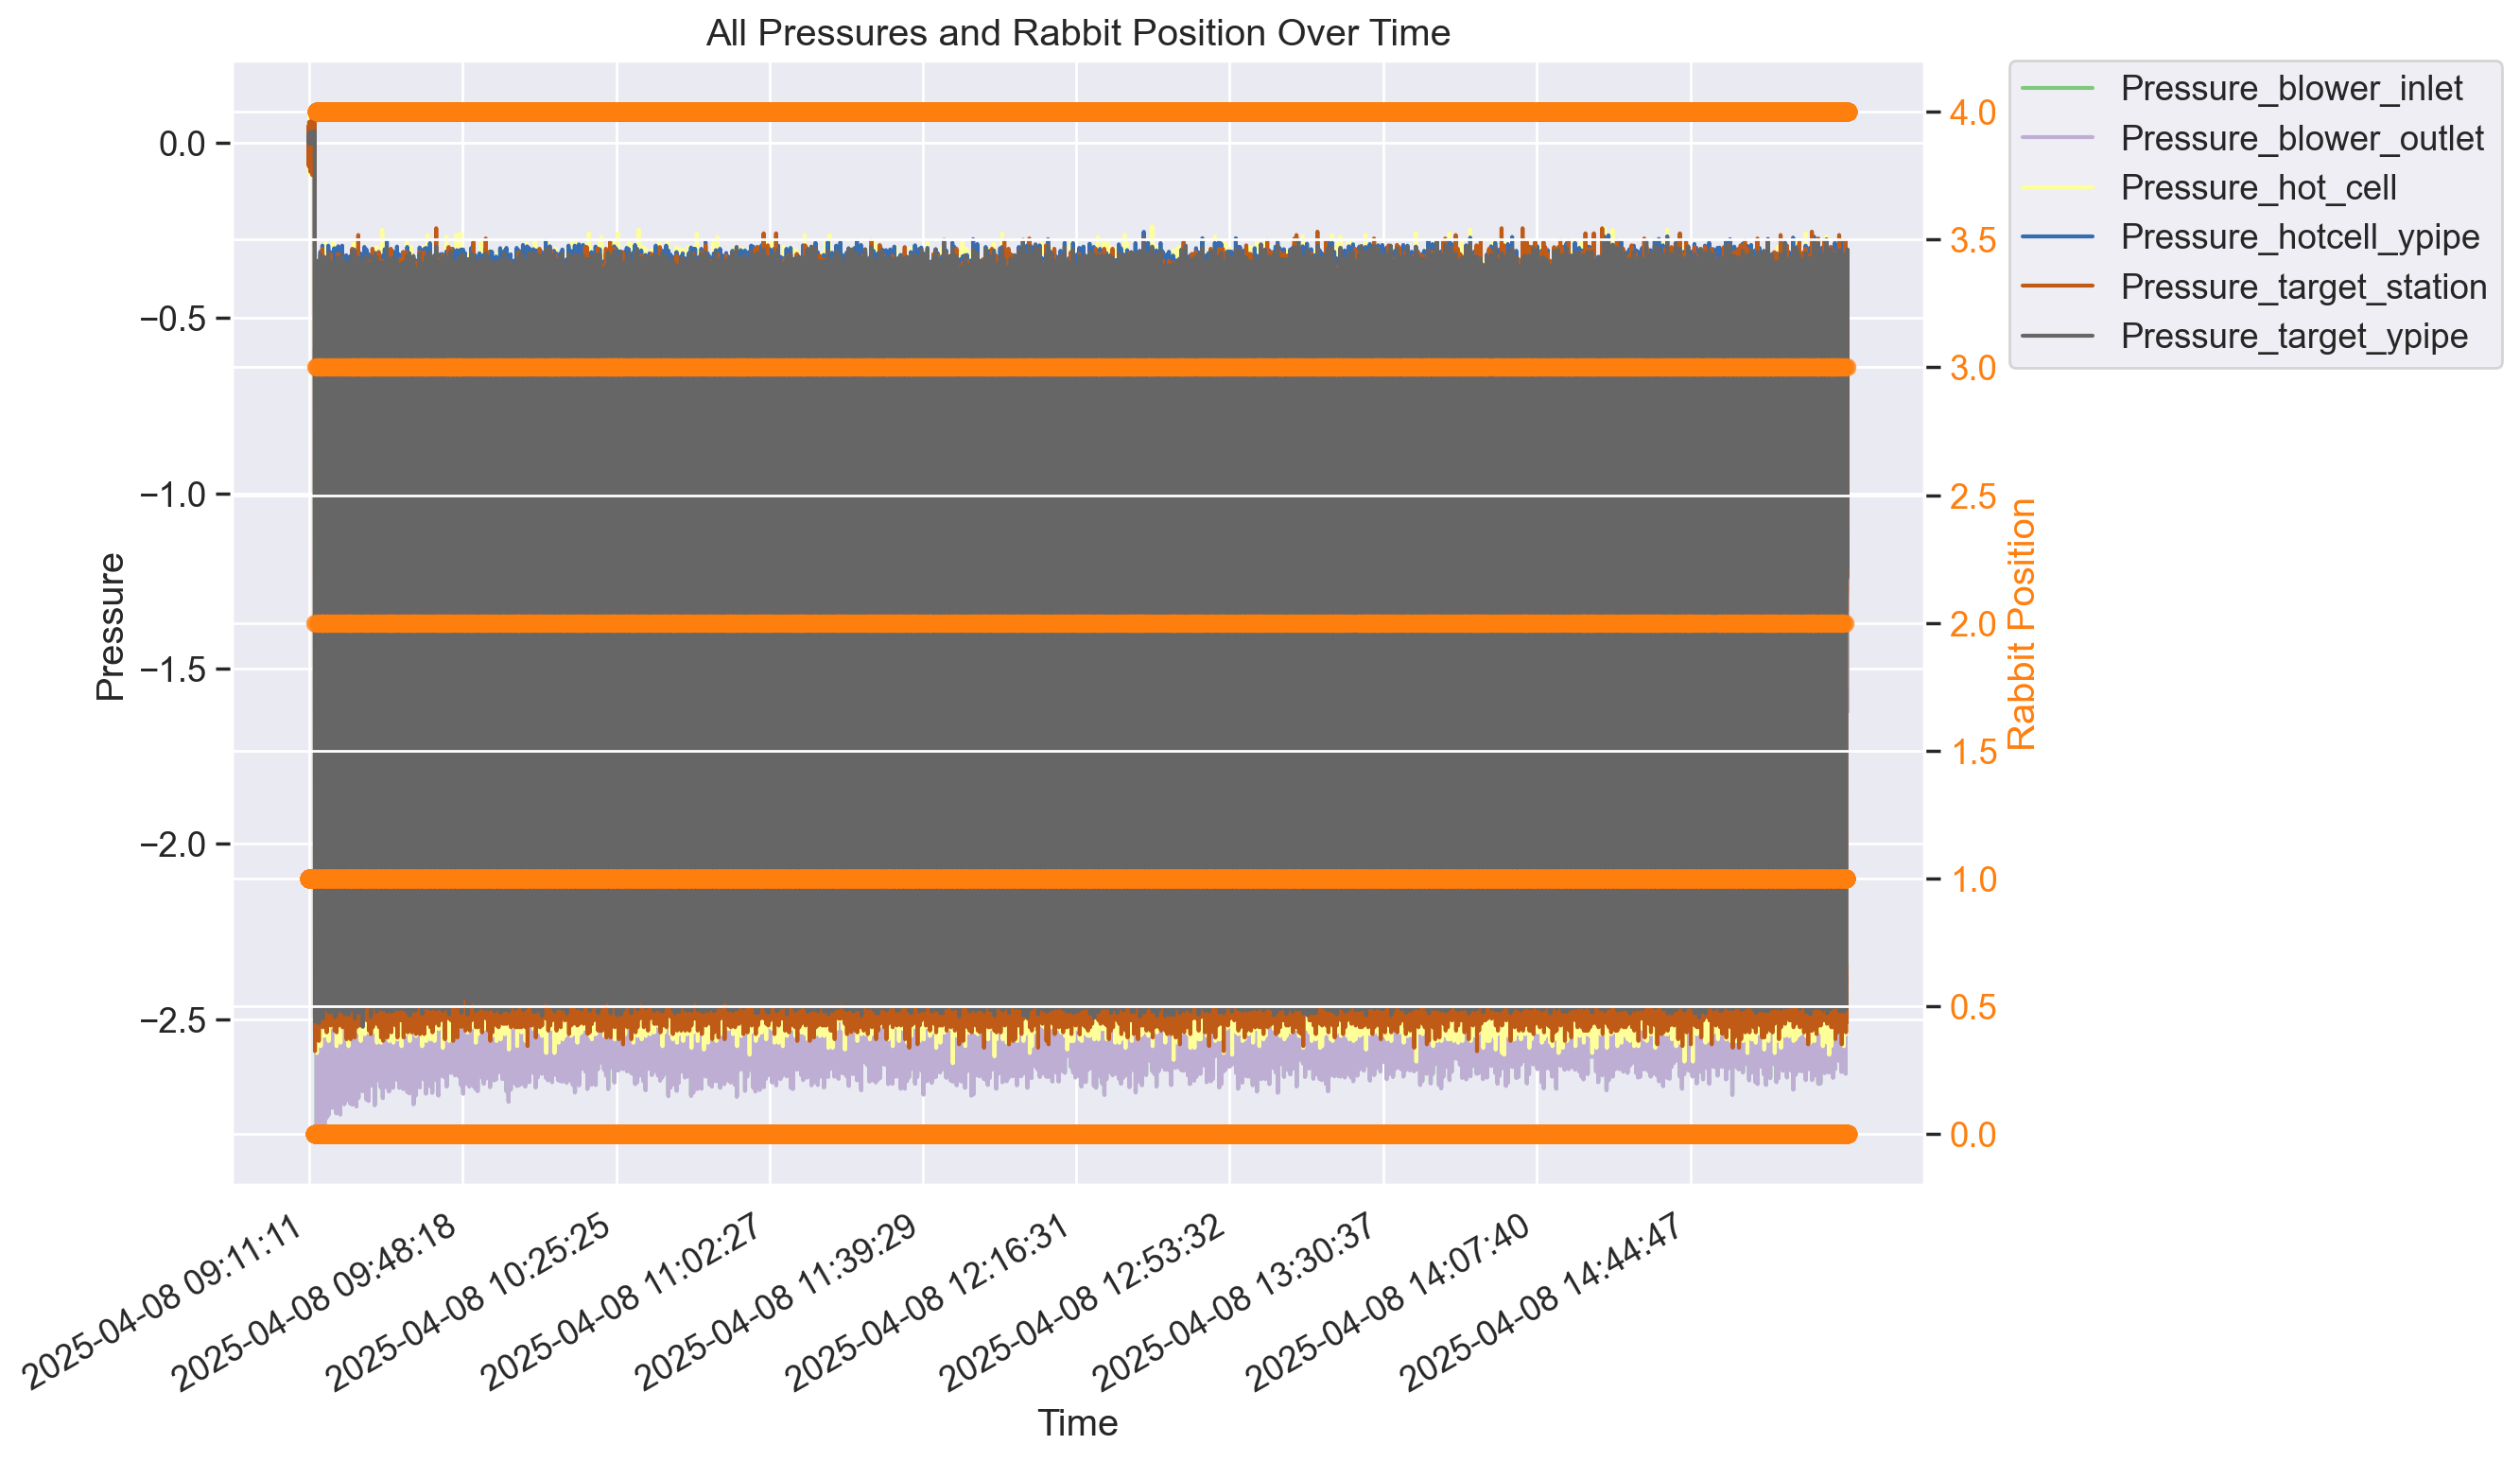

In [32]:
from SRC import utils

# Convert millisecond epoch to datetime
merged2['time'] = pd.to_datetime(merged2['time'], unit='ms')

# Convert to local timezone if needed
merged2['time'] = merged2['time'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

# Remove timezone info (matplotlib prefers naive datetime objects)
merged2['time'] = merged2['time'].dt.tz_localize(None)

print("Sample of converted timestamps:")
print(merged2['time'].unique())

# Now merged2 can be used with matplotlib visualization
utils.visualize_data(merged2)

Original dataset size: 176880
Subset size: 13506
Time range: 2025-04-08 09:11:11.220000 to 2025-04-08 09:41:11.220000


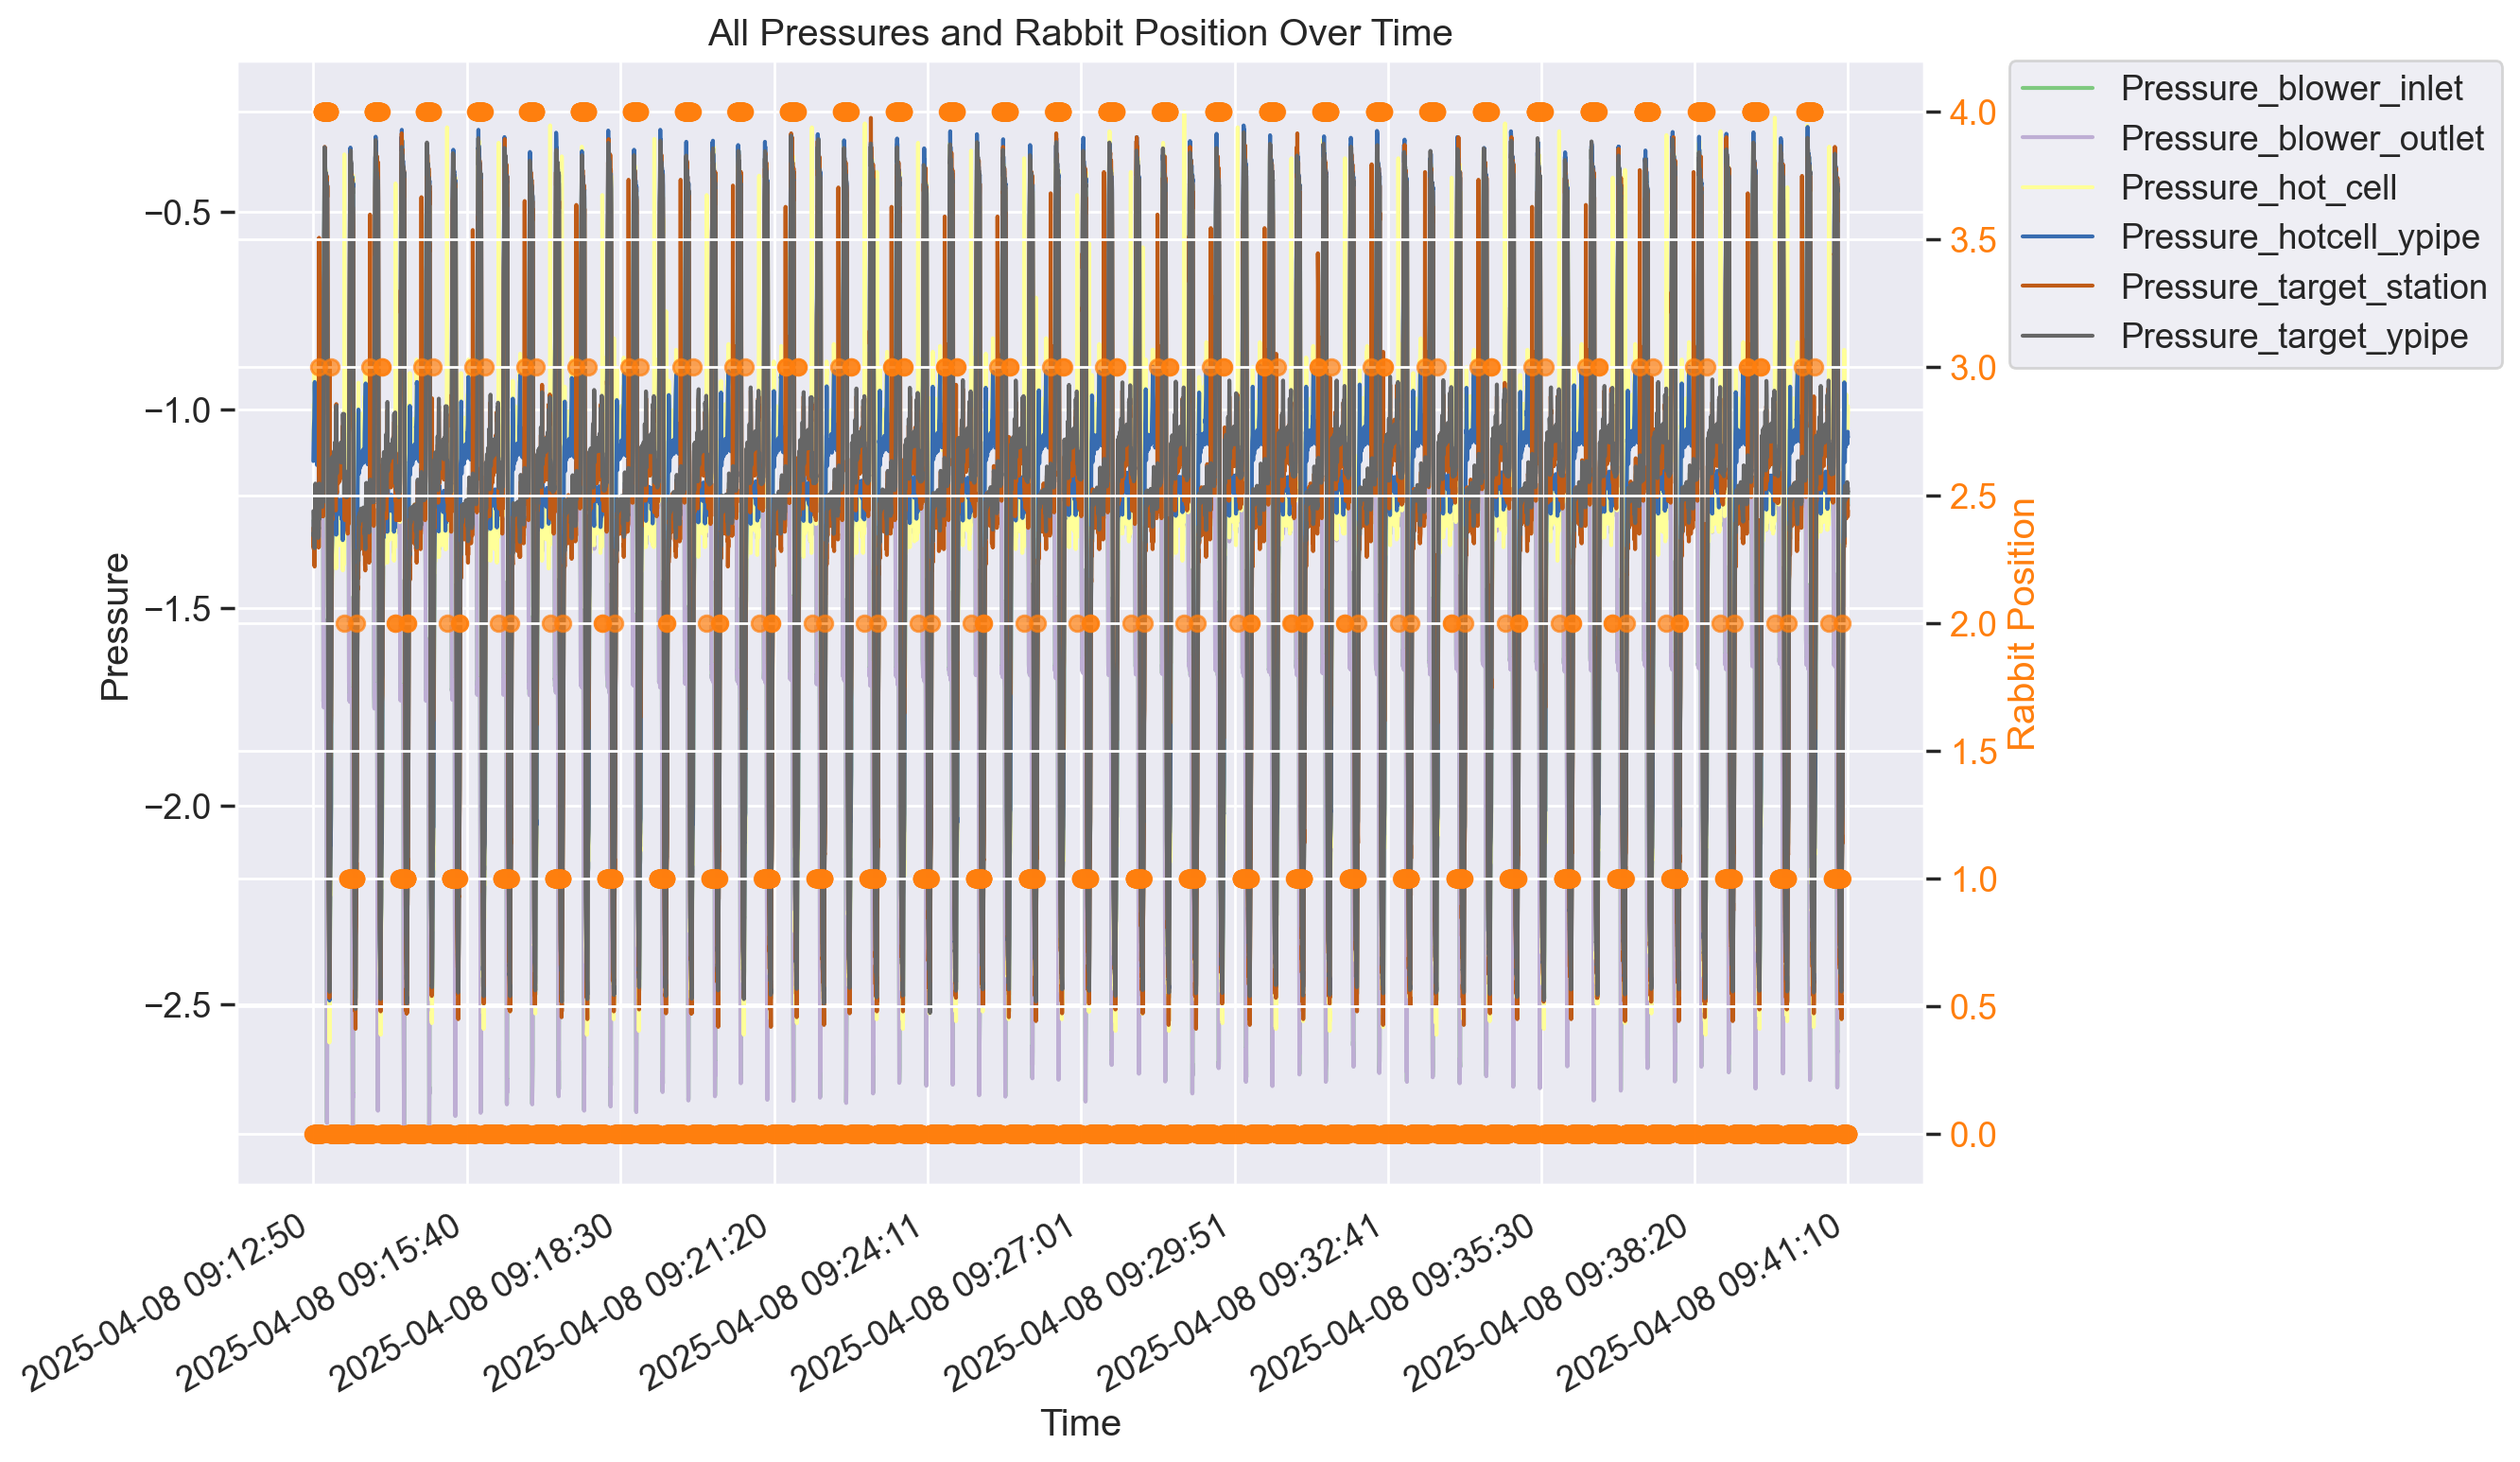


Average sampling rate: 0.13 seconds


In [ ]:
# Get the start time and create a 30-minute window
start_time = merged2['time'].min()
end_time = start_time + pd.Timedelta(minutes=30)


# Create the subset
merged2_subset = merged2[(merged2['time'] >= '2025-04-08 09:12:50') & (merged2['time'] <= end_time)]

print(f"Original dataset size: {len(merged2)}")
print(f"Subset size: {len(merged2_subset)}")
print(f"Time range: {start_time} to {end_time}")

# Visualize the subset
utils.visualize_data(merged2_subset)

# Optional: Display sampling rate
time_diff = merged2_subset['time'].diff().mean()
print(f"\nAverage sampling rate: {time_diff.total_seconds():.2f} seconds")

In [36]:
merged2_subset, label_encoder = dp.preprocess_data(merged2_subset)
train_data, test_data = dp.split_data(merged2_subset)
X_train, y_train = dp.get_features_and_labels(merged2_subset)
X_test, y_test = dp.get_features_and_labels(merged2_subset)

FEATURE_COLS = [col for col in train_data.columns if col.startswith('Pressure_')]
LABEL_COL = 'RabbitPosition'  # Change if your label column is named differently


c:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V2\SRC\data_proccessing.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[pressure_cols] = scaler.fit_transform(data[pressure_cols])
c:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V2\SRC\data_proccessing.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RabbitPosition'] = label_encoder.fit_transform(data['RabbitPosition'])


In [66]:
class PositionDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_cols, label_col):
        self.features = df[feature_cols].to_numpy(dtype=np.float32)
        self.labels = df[label_col].to_numpy(dtype=np.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            'sequence': features,
            'label': label
        }

class PositionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, feature_cols, label_col, batch_size=1):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = PositionDataset(self.train_df, self.feature_cols, self.label_col)
        self.test_dataset = PositionDataset(self.test_df, self.feature_cols, self.label_col)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [67]:
epochs = 250
batch_size = 64

data_module = PositionDataModule(
    train_data, test_data, FEATURE_COLS, LABEL_COL, batch_size=64
)

In [68]:
class PositionModel_V3(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [69]:
class PositionPredictor_V3(pl.LightningModule):
  def __init__(self, n_features: int, n_classes: int):
    super().__init__()
    self.model = PositionModel_V3(n_features, n_classes)
    self.loss_fn = nn.CrossEntropyLoss()
    self.n_classes = n_classes

  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.loss_fn(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('training_loss', loss, prog_bar = True, logger = True)
    self.log('training_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('val_loss', loss, prog_bar = True, logger = True)
    self.log('val_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('test_loss', loss, prog_bar = True, logger = True)
    self.log('test_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

In [70]:
unique_classes = len(label_encoder.classes_)
print(f"Number of unique classes: {unique_classes}")

model_V3 = PositionPredictor_V3(
    n_features=len(FEATURE_COLS),
    n_classes=unique_classes
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

training_losses = []
validation_losses = []
epoch_count = []
class LossCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        logs = trainer.callback_metrics
        train_loss = logs['training_loss'].item()
        val_loss = logs['val_loss'].item()
        
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        epoch_count.append(trainer.current_epoch)

logger = TensorBoardLogger('lightning_logs', name='surface-prediction_V2')



loss_callback = LossCallback()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback,loss_callback],
    max_epochs=epochs,
    accelerator='cpu',
    devices=1,
    precision=16,  # Use mixed precision for faster training
    enable_progress_bar=True,
    accumulate_grad_batches=4
)

c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of unique classes: 5


In [71]:
trainer.fit(model_V3, data_module)

c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V2\checkpoints exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | PositionModel_V3 | 3.1 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 139/139 [00:01<00:00, 81.22it/s, v_num=4, training_loss=0.575, training_acc=0.859, val_loss=0.631, val_acc=0.782]

Epoch 0, global step 35: 'val_loss' reached 0.63087 (best 0.63087), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 1: 100%|██████████| 139/139 [00:01<00:00, 92.47it/s, v_num=4, training_loss=0.541, training_acc=0.797, val_loss=0.533, val_acc=0.794] 

Epoch 1, global step 70: 'val_loss' reached 0.53303 (best 0.53303), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 2: 100%|██████████| 139/139 [00:01<00:00, 83.10it/s, v_num=4, training_loss=0.591, training_acc=0.781, val_loss=0.516, val_acc=0.808]

Epoch 2, global step 105: 'val_loss' reached 0.51580 (best 0.51580), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 3: 100%|██████████| 139/139 [00:01<00:00, 84.69it/s, v_num=4, training_loss=0.473, training_acc=0.781, val_loss=0.505, val_acc=0.791] 

Epoch 3, global step 140: 'val_loss' reached 0.50490 (best 0.50490), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 4: 100%|██████████| 139/139 [00:01<00:00, 91.50it/s, v_num=4, training_loss=0.448, training_acc=0.797, val_loss=0.493, val_acc=0.806] 

Epoch 4, global step 175: 'val_loss' reached 0.49286 (best 0.49286), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 5: 100%|██████████| 139/139 [00:01<00:00, 87.32it/s, v_num=4, training_loss=0.526, training_acc=0.750, val_loss=0.483, val_acc=0.810] 

Epoch 5, global step 210: 'val_loss' reached 0.48336 (best 0.48336), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 6: 100%|██████████| 139/139 [00:01<00:00, 88.36it/s, v_num=4, training_loss=0.582, training_acc=0.812, val_loss=0.473, val_acc=0.815] 

Epoch 6, global step 245: 'val_loss' reached 0.47266 (best 0.47266), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 7: 100%|██████████| 139/139 [00:01<00:00, 95.35it/s, v_num=4, training_loss=0.356, training_acc=0.797, val_loss=0.465, val_acc=0.811] 

Epoch 7, global step 280: 'val_loss' reached 0.46537 (best 0.46537), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 8: 100%|██████████| 139/139 [00:01<00:00, 93.61it/s, v_num=4, training_loss=0.404, training_acc=0.797, val_loss=0.456, val_acc=0.808] 

Epoch 8, global step 315: 'val_loss' reached 0.45581 (best 0.45581), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 9: 100%|██████████| 139/139 [00:01<00:00, 92.88it/s, v_num=4, training_loss=0.549, training_acc=0.766, val_loss=0.446, val_acc=0.821] 

Epoch 9, global step 350: 'val_loss' reached 0.44580 (best 0.44580), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 10: 100%|██████████| 139/139 [00:01<00:00, 94.00it/s, v_num=4, training_loss=0.512, training_acc=0.781, val_loss=0.437, val_acc=0.820] 

Epoch 10, global step 385: 'val_loss' reached 0.43732 (best 0.43732), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 11: 100%|██████████| 139/139 [00:01<00:00, 90.62it/s, v_num=4, training_loss=0.381, training_acc=0.922, val_loss=0.428, val_acc=0.836] 

Epoch 11, global step 420: 'val_loss' reached 0.42762 (best 0.42762), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 12: 100%|██████████| 139/139 [00:01<00:00, 94.87it/s, v_num=4, training_loss=0.398, training_acc=0.859, val_loss=0.419, val_acc=0.836] 

Epoch 12, global step 455: 'val_loss' reached 0.41911 (best 0.41911), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 13: 100%|██████████| 139/139 [00:01<00:00, 92.18it/s, v_num=4, training_loss=0.367, training_acc=0.812, val_loss=0.412, val_acc=0.827] 

Epoch 13, global step 490: 'val_loss' reached 0.41232 (best 0.41232), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 14: 100%|██████████| 139/139 [00:01<00:00, 91.55it/s, v_num=4, training_loss=0.382, training_acc=0.891, val_loss=0.405, val_acc=0.844] 

Epoch 14, global step 525: 'val_loss' reached 0.40534 (best 0.40534), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 15: 100%|██████████| 139/139 [00:01<00:00, 100.96it/s, v_num=4, training_loss=0.438, training_acc=0.828, val_loss=0.401, val_acc=0.834]

Epoch 15, global step 560: 'val_loss' reached 0.40087 (best 0.40087), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 16: 100%|██████████| 139/139 [00:01<00:00, 101.09it/s, v_num=4, training_loss=0.369, training_acc=0.891, val_loss=0.397, val_acc=0.832]

Epoch 16, global step 595: 'val_loss' reached 0.39729 (best 0.39729), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 17: 100%|██████████| 139/139 [00:01<00:00, 97.84it/s, v_num=4, training_loss=0.267, training_acc=0.938, val_loss=0.388, val_acc=0.842] 

Epoch 17, global step 630: 'val_loss' reached 0.38848 (best 0.38848), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 18: 100%|██████████| 139/139 [00:01<00:00, 100.54it/s, v_num=4, training_loss=0.359, training_acc=0.844, val_loss=0.382, val_acc=0.846]

Epoch 18, global step 665: 'val_loss' reached 0.38176 (best 0.38176), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 19: 100%|██████████| 139/139 [00:01<00:00, 99.00it/s, v_num=4, training_loss=0.362, training_acc=0.891, val_loss=0.377, val_acc=0.846] 

Epoch 19, global step 700: 'val_loss' reached 0.37698 (best 0.37698), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 20: 100%|██████████| 139/139 [00:01<00:00, 96.59it/s, v_num=4, training_loss=0.361, training_acc=0.828, val_loss=0.370, val_acc=0.861] 

Epoch 20, global step 735: 'val_loss' reached 0.37014 (best 0.37014), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 21: 100%|██████████| 139/139 [00:01<00:00, 97.94it/s, v_num=4, training_loss=0.257, training_acc=0.922, val_loss=0.367, val_acc=0.859] 

Epoch 21, global step 770: 'val_loss' reached 0.36714 (best 0.36714), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 22: 100%|██████████| 139/139 [00:01<00:00, 89.37it/s, v_num=4, training_loss=0.245, training_acc=0.875, val_loss=0.362, val_acc=0.862] 

Epoch 22, global step 805: 'val_loss' reached 0.36202 (best 0.36202), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 23: 100%|██████████| 139/139 [00:01<00:00, 105.87it/s, v_num=4, training_loss=0.306, training_acc=0.906, val_loss=0.361, val_acc=0.851]

Epoch 23, global step 840: 'val_loss' reached 0.36106 (best 0.36106), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 24: 100%|██████████| 139/139 [00:01<00:00, 93.62it/s, v_num=4, training_loss=0.518, training_acc=0.797, val_loss=0.354, val_acc=0.865] 

Epoch 24, global step 875: 'val_loss' reached 0.35368 (best 0.35368), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 25: 100%|██████████| 139/139 [00:01<00:00, 100.56it/s, v_num=4, training_loss=0.265, training_acc=0.844, val_loss=0.349, val_acc=0.866]

Epoch 25, global step 910: 'val_loss' reached 0.34944 (best 0.34944), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 26: 100%|██████████| 139/139 [00:01<00:00, 100.89it/s, v_num=4, training_loss=0.328, training_acc=0.891, val_loss=0.346, val_acc=0.868]

Epoch 26, global step 945: 'val_loss' reached 0.34559 (best 0.34559), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 27: 100%|██████████| 139/139 [00:01<00:00, 88.61it/s, v_num=4, training_loss=0.328, training_acc=0.844, val_loss=0.344, val_acc=0.860] 

Epoch 27, global step 980: 'val_loss' reached 0.34381 (best 0.34381), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 28: 100%|██████████| 139/139 [00:01<00:00, 97.29it/s, v_num=4, training_loss=0.368, training_acc=0.859, val_loss=0.344, val_acc=0.858] 

Epoch 28, global step 1015: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 139/139 [00:01<00:00, 100.55it/s, v_num=4, training_loss=0.239, training_acc=0.875, val_loss=0.338, val_acc=0.863]

Epoch 29, global step 1050: 'val_loss' reached 0.33784 (best 0.33784), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 30: 100%|██████████| 139/139 [00:01<00:00, 96.27it/s, v_num=4, training_loss=0.261, training_acc=0.938, val_loss=0.335, val_acc=0.864] 

Epoch 30, global step 1085: 'val_loss' reached 0.33532 (best 0.33532), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 31: 100%|██████████| 139/139 [00:01<00:00, 91.78it/s, v_num=4, training_loss=0.261, training_acc=0.859, val_loss=0.335, val_acc=0.861] 

Epoch 31, global step 1120: 'val_loss' reached 0.33477 (best 0.33477), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 32: 100%|██████████| 139/139 [00:01<00:00, 97.53it/s, v_num=4, training_loss=0.490, training_acc=0.766, val_loss=0.328, val_acc=0.871] 

Epoch 32, global step 1155: 'val_loss' reached 0.32813 (best 0.32813), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 33: 100%|██████████| 139/139 [00:01<00:00, 102.61it/s, v_num=4, training_loss=0.230, training_acc=0.953, val_loss=0.326, val_acc=0.870]

Epoch 33, global step 1190: 'val_loss' reached 0.32644 (best 0.32644), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 34: 100%|██████████| 139/139 [00:01<00:00, 108.52it/s, v_num=4, training_loss=0.302, training_acc=0.891, val_loss=0.325, val_acc=0.868]

Epoch 34, global step 1225: 'val_loss' reached 0.32543 (best 0.32543), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 35: 100%|██████████| 139/139 [00:01<00:00, 100.19it/s, v_num=4, training_loss=0.418, training_acc=0.812, val_loss=0.323, val_acc=0.869]

Epoch 35, global step 1260: 'val_loss' reached 0.32322 (best 0.32322), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 36: 100%|██████████| 139/139 [00:01<00:00, 101.31it/s, v_num=4, training_loss=0.240, training_acc=0.906, val_loss=0.320, val_acc=0.872]

Epoch 36, global step 1295: 'val_loss' reached 0.32030 (best 0.32030), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 37: 100%|██████████| 139/139 [00:01<00:00, 100.91it/s, v_num=4, training_loss=0.271, training_acc=0.906, val_loss=0.318, val_acc=0.875]

Epoch 37, global step 1330: 'val_loss' reached 0.31796 (best 0.31796), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 38: 100%|██████████| 139/139 [00:01<00:00, 98.36it/s, v_num=4, training_loss=0.263, training_acc=0.875, val_loss=0.319, val_acc=0.866] 

Epoch 38, global step 1365: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 139/139 [00:01<00:00, 92.08it/s, v_num=4, training_loss=0.365, training_acc=0.875, val_loss=0.317, val_acc=0.869] 

Epoch 39, global step 1400: 'val_loss' reached 0.31703 (best 0.31703), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 40: 100%|██████████| 139/139 [00:01<00:00, 91.59it/s, v_num=4, training_loss=0.361, training_acc=0.812, val_loss=0.315, val_acc=0.869] 

Epoch 40, global step 1435: 'val_loss' reached 0.31521 (best 0.31521), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 41: 100%|██████████| 139/139 [00:01<00:00, 92.66it/s, v_num=4, training_loss=0.362, training_acc=0.844, val_loss=0.310, val_acc=0.879] 

Epoch 41, global step 1470: 'val_loss' reached 0.31043 (best 0.31043), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 42: 100%|██████████| 139/139 [00:01<00:00, 85.65it/s, v_num=4, training_loss=0.339, training_acc=0.859, val_loss=0.310, val_acc=0.877] 

Epoch 42, global step 1505: 'val_loss' reached 0.31041 (best 0.31041), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 43: 100%|██████████| 139/139 [00:01<00:00, 99.38it/s, v_num=4, training_loss=0.371, training_acc=0.875, val_loss=0.307, val_acc=0.881] 

Epoch 43, global step 1540: 'val_loss' reached 0.30678 (best 0.30678), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 44: 100%|██████████| 139/139 [00:01<00:00, 90.25it/s, v_num=4, training_loss=0.273, training_acc=0.859, val_loss=0.307, val_acc=0.872] 

Epoch 44, global step 1575: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 139/139 [00:01<00:00, 99.43it/s, v_num=4, training_loss=0.353, training_acc=0.859, val_loss=0.304, val_acc=0.882] 

Epoch 45, global step 1610: 'val_loss' reached 0.30380 (best 0.30380), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 46: 100%|██████████| 139/139 [00:01<00:00, 97.66it/s, v_num=4, training_loss=0.157, training_acc=0.938, val_loss=0.303, val_acc=0.881] 

Epoch 46, global step 1645: 'val_loss' reached 0.30322 (best 0.30322), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 47: 100%|██████████| 139/139 [00:01<00:00, 95.50it/s, v_num=4, training_loss=0.237, training_acc=0.906, val_loss=0.304, val_acc=0.875] 

Epoch 47, global step 1680: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 139/139 [00:01<00:00, 99.73it/s, v_num=4, training_loss=0.312, training_acc=0.844, val_loss=0.304, val_acc=0.883] 

Epoch 48, global step 1715: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 139/139 [00:01<00:00, 84.34it/s, v_num=4, training_loss=0.452, training_acc=0.844, val_loss=0.302, val_acc=0.875] 

Epoch 49, global step 1750: 'val_loss' reached 0.30248 (best 0.30248), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 50: 100%|██████████| 139/139 [00:01<00:00, 89.93it/s, v_num=4, training_loss=0.174, training_acc=0.953, val_loss=0.303, val_acc=0.876] 

Epoch 50, global step 1785: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 139/139 [00:01<00:00, 96.72it/s, v_num=4, training_loss=0.164, training_acc=0.938, val_loss=0.298, val_acc=0.878] 

Epoch 51, global step 1820: 'val_loss' reached 0.29815 (best 0.29815), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 52: 100%|██████████| 139/139 [00:01<00:00, 85.24it/s, v_num=4, training_loss=0.334, training_acc=0.859, val_loss=0.296, val_acc=0.880] 

Epoch 52, global step 1855: 'val_loss' reached 0.29604 (best 0.29604), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 53: 100%|██████████| 139/139 [00:01<00:00, 94.49it/s, v_num=4, training_loss=0.290, training_acc=0.875, val_loss=0.293, val_acc=0.881] 

Epoch 53, global step 1890: 'val_loss' reached 0.29339 (best 0.29339), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 54: 100%|██████████| 139/139 [00:01<00:00, 96.83it/s, v_num=4, training_loss=0.203, training_acc=0.859, val_loss=0.293, val_acc=0.881] 

Epoch 54, global step 1925: 'val_loss' reached 0.29321 (best 0.29321), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 55: 100%|██████████| 139/139 [00:01<00:00, 99.09it/s, v_num=4, training_loss=0.227, training_acc=0.938, val_loss=0.293, val_acc=0.882] 

Epoch 55, global step 1960: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 139/139 [00:01<00:00, 98.63it/s, v_num=4, training_loss=0.192, training_acc=0.938, val_loss=0.291, val_acc=0.880] 

Epoch 56, global step 1995: 'val_loss' reached 0.29096 (best 0.29096), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 57: 100%|██████████| 139/139 [00:01<00:00, 91.68it/s, v_num=4, training_loss=0.362, training_acc=0.797, val_loss=0.290, val_acc=0.881] 

Epoch 57, global step 2030: 'val_loss' reached 0.28951 (best 0.28951), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 58: 100%|██████████| 139/139 [00:01<00:00, 86.02it/s, v_num=4, training_loss=0.365, training_acc=0.812, val_loss=0.288, val_acc=0.882] 

Epoch 58, global step 2065: 'val_loss' reached 0.28806 (best 0.28806), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 59: 100%|██████████| 139/139 [00:01<00:00, 98.32it/s, v_num=4, training_loss=0.264, training_acc=0.906, val_loss=0.288, val_acc=0.885] 

Epoch 59, global step 2100: 'val_loss' reached 0.28766 (best 0.28766), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 60: 100%|██████████| 139/139 [00:01<00:00, 87.82it/s, v_num=4, training_loss=0.162, training_acc=0.969, val_loss=0.288, val_acc=0.881] 

Epoch 60, global step 2135: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 139/139 [00:01<00:00, 98.91it/s, v_num=4, training_loss=0.270, training_acc=0.875, val_loss=0.287, val_acc=0.881] 

Epoch 61, global step 2170: 'val_loss' reached 0.28661 (best 0.28661), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 62: 100%|██████████| 139/139 [00:01<00:00, 92.17it/s, v_num=4, training_loss=0.267, training_acc=0.859, val_loss=0.284, val_acc=0.884] 

Epoch 62, global step 2205: 'val_loss' reached 0.28425 (best 0.28425), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 63: 100%|██████████| 139/139 [00:01<00:00, 80.88it/s, v_num=4, training_loss=0.238, training_acc=0.859, val_loss=0.285, val_acc=0.883] 

Epoch 63, global step 2240: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 139/139 [00:01<00:00, 77.63it/s, v_num=4, training_loss=0.241, training_acc=0.906, val_loss=0.282, val_acc=0.886]

Epoch 64, global step 2275: 'val_loss' reached 0.28248 (best 0.28248), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 65: 100%|██████████| 139/139 [00:01<00:00, 84.95it/s, v_num=4, training_loss=0.336, training_acc=0.859, val_loss=0.284, val_acc=0.883] 

Epoch 65, global step 2310: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 139/139 [00:01<00:00, 94.69it/s, v_num=4, training_loss=0.250, training_acc=0.875, val_loss=0.283, val_acc=0.882] 

Epoch 66, global step 2345: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 139/139 [00:01<00:00, 98.06it/s, v_num=4, training_loss=0.227, training_acc=0.875, val_loss=0.281, val_acc=0.880] 

Epoch 67, global step 2380: 'val_loss' reached 0.28124 (best 0.28124), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 68: 100%|██████████| 139/139 [00:01<00:00, 88.83it/s, v_num=4, training_loss=0.212, training_acc=0.922, val_loss=0.279, val_acc=0.884] 

Epoch 68, global step 2415: 'val_loss' reached 0.27904 (best 0.27904), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 69: 100%|██████████| 139/139 [00:01<00:00, 95.12it/s, v_num=4, training_loss=0.279, training_acc=0.875, val_loss=0.282, val_acc=0.885] 

Epoch 69, global step 2450: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 139/139 [00:01<00:00, 93.77it/s, v_num=4, training_loss=0.304, training_acc=0.891, val_loss=0.278, val_acc=0.884] 

Epoch 70, global step 2485: 'val_loss' reached 0.27770 (best 0.27770), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 71: 100%|██████████| 139/139 [00:01<00:00, 91.78it/s, v_num=4, training_loss=0.282, training_acc=0.891, val_loss=0.282, val_acc=0.881] 

Epoch 71, global step 2520: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 139/139 [00:01<00:00, 95.53it/s, v_num=4, training_loss=0.253, training_acc=0.906, val_loss=0.278, val_acc=0.882] 

Epoch 72, global step 2555: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 139/139 [00:01<00:00, 95.23it/s, v_num=4, training_loss=0.257, training_acc=0.906, val_loss=0.278, val_acc=0.880]  

Epoch 73, global step 2590: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 139/139 [00:01<00:00, 94.53it/s, v_num=4, training_loss=0.203, training_acc=0.906, val_loss=0.277, val_acc=0.880] 

Epoch 74, global step 2625: 'val_loss' reached 0.27748 (best 0.27748), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 75: 100%|██████████| 139/139 [00:01<00:00, 99.60it/s, v_num=4, training_loss=0.214, training_acc=0.953, val_loss=0.275, val_acc=0.881] 

Epoch 75, global step 2660: 'val_loss' reached 0.27465 (best 0.27465), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 76: 100%|██████████| 139/139 [00:01<00:00, 95.34it/s, v_num=4, training_loss=0.292, training_acc=0.875, val_loss=0.278, val_acc=0.884] 

Epoch 76, global step 2695: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 139/139 [00:01<00:00, 96.06it/s, v_num=4, training_loss=0.337, training_acc=0.797, val_loss=0.275, val_acc=0.881] 

Epoch 77, global step 2730: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 139/139 [00:01<00:00, 101.04it/s, v_num=4, training_loss=0.197, training_acc=0.906, val_loss=0.274, val_acc=0.884]

Epoch 78, global step 2765: 'val_loss' reached 0.27377 (best 0.27377), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 79: 100%|██████████| 139/139 [00:01<00:00, 101.44it/s, v_num=4, training_loss=0.302, training_acc=0.766, val_loss=0.273, val_acc=0.885]

Epoch 79, global step 2800: 'val_loss' reached 0.27251 (best 0.27251), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 80: 100%|██████████| 139/139 [00:01<00:00, 95.96it/s, v_num=4, training_loss=0.290, training_acc=0.844, val_loss=0.273, val_acc=0.884] 

Epoch 80, global step 2835: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 139/139 [00:01<00:00, 101.26it/s, v_num=4, training_loss=0.136, training_acc=0.953, val_loss=0.275, val_acc=0.881]

Epoch 81, global step 2870: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 139/139 [00:01<00:00, 96.59it/s, v_num=4, training_loss=0.402, training_acc=0.859, val_loss=0.272, val_acc=0.882] 

Epoch 82, global step 2905: 'val_loss' reached 0.27239 (best 0.27239), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 83: 100%|██████████| 139/139 [00:01<00:00, 99.61it/s, v_num=4, training_loss=0.173, training_acc=0.969, val_loss=0.271, val_acc=0.884] 

Epoch 83, global step 2940: 'val_loss' reached 0.27086 (best 0.27086), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 84: 100%|██████████| 139/139 [00:01<00:00, 91.69it/s, v_num=4, training_loss=0.191, training_acc=0.906, val_loss=0.271, val_acc=0.882] 

Epoch 84, global step 2975: 'val_loss' reached 0.27073 (best 0.27073), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 85: 100%|██████████| 139/139 [00:01<00:00, 90.61it/s, v_num=4, training_loss=0.185, training_acc=0.953, val_loss=0.270, val_acc=0.885] 

Epoch 85, global step 3010: 'val_loss' reached 0.26963 (best 0.26963), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 86: 100%|██████████| 139/139 [00:01<00:00, 111.67it/s, v_num=4, training_loss=0.266, training_acc=0.844, val_loss=0.270, val_acc=0.886]

Epoch 86, global step 3045: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 139/139 [00:01<00:00, 99.72it/s, v_num=4, training_loss=0.329, training_acc=0.812, val_loss=0.270, val_acc=0.882]  

Epoch 87, global step 3080: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 139/139 [00:01<00:00, 89.38it/s, v_num=4, training_loss=0.237, training_acc=0.891, val_loss=0.271, val_acc=0.881] 

Epoch 88, global step 3115: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 139/139 [00:01<00:00, 102.09it/s, v_num=4, training_loss=0.261, training_acc=0.875, val_loss=0.276, val_acc=0.882]

Epoch 89, global step 3150: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 139/139 [00:01<00:00, 104.55it/s, v_num=4, training_loss=0.267, training_acc=0.906, val_loss=0.267, val_acc=0.884]

Epoch 90, global step 3185: 'val_loss' reached 0.26682 (best 0.26682), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 91: 100%|██████████| 139/139 [00:01<00:00, 95.56it/s, v_num=4, training_loss=0.211, training_acc=0.891, val_loss=0.268, val_acc=0.883] 

Epoch 91, global step 3220: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 139/139 [00:01<00:00, 97.16it/s, v_num=4, training_loss=0.233, training_acc=0.922, val_loss=0.267, val_acc=0.883] 

Epoch 92, global step 3255: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 139/139 [00:01<00:00, 97.43it/s, v_num=4, training_loss=0.198, training_acc=0.922, val_loss=0.266, val_acc=0.885] 

Epoch 93, global step 3290: 'val_loss' reached 0.26595 (best 0.26595), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 94: 100%|██████████| 139/139 [00:01<00:00, 101.56it/s, v_num=4, training_loss=0.178, training_acc=0.906, val_loss=0.267, val_acc=0.884]

Epoch 94, global step 3325: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 139/139 [00:01<00:00, 91.25it/s, v_num=4, training_loss=0.212, training_acc=0.906, val_loss=0.264, val_acc=0.885] 

Epoch 95, global step 3360: 'val_loss' reached 0.26441 (best 0.26441), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 96: 100%|██████████| 139/139 [00:01<00:00, 92.75it/s, v_num=4, training_loss=0.323, training_acc=0.828, val_loss=0.265, val_acc=0.884] 

Epoch 96, global step 3395: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 139/139 [00:01<00:00, 98.92it/s, v_num=4, training_loss=0.141, training_acc=0.953, val_loss=0.264, val_acc=0.882] 

Epoch 97, global step 3430: 'val_loss' reached 0.26427 (best 0.26427), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 98: 100%|██████████| 139/139 [00:01<00:00, 99.38it/s, v_num=4, training_loss=0.208, training_acc=0.906, val_loss=0.266, val_acc=0.886] 

Epoch 98, global step 3465: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 139/139 [00:01<00:00, 101.95it/s, v_num=4, training_loss=0.218, training_acc=0.922, val_loss=0.264, val_acc=0.884]

Epoch 99, global step 3500: 'val_loss' reached 0.26403 (best 0.26403), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 100: 100%|██████████| 139/139 [00:01<00:00, 101.31it/s, v_num=4, training_loss=0.218, training_acc=0.938, val_loss=0.262, val_acc=0.886] 

Epoch 100, global step 3535: 'val_loss' reached 0.26225 (best 0.26225), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 101: 100%|██████████| 139/139 [00:01<00:00, 95.07it/s, v_num=4, training_loss=0.229, training_acc=0.906, val_loss=0.262, val_acc=0.880] 

Epoch 101, global step 3570: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 139/139 [00:01<00:00, 83.90it/s, v_num=4, training_loss=0.214, training_acc=0.891, val_loss=0.267, val_acc=0.885] 

Epoch 102, global step 3605: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 139/139 [00:01<00:00, 84.23it/s, v_num=4, training_loss=0.223, training_acc=0.938, val_loss=0.261, val_acc=0.882] 

Epoch 103, global step 3640: 'val_loss' reached 0.26125 (best 0.26125), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 104: 100%|██████████| 139/139 [00:01<00:00, 85.47it/s, v_num=4, training_loss=0.190, training_acc=0.922, val_loss=0.267, val_acc=0.883] 

Epoch 104, global step 3675: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 139/139 [00:01<00:00, 90.59it/s, v_num=4, training_loss=0.265, training_acc=0.891, val_loss=0.263, val_acc=0.883] 

Epoch 105, global step 3710: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 139/139 [00:01<00:00, 92.27it/s, v_num=4, training_loss=0.245, training_acc=0.906, val_loss=0.262, val_acc=0.883] 

Epoch 106, global step 3745: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 139/139 [00:01<00:00, 91.64it/s, v_num=4, training_loss=0.288, training_acc=0.844, val_loss=0.264, val_acc=0.883]  

Epoch 107, global step 3780: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 139/139 [00:01<00:00, 95.87it/s, v_num=4, training_loss=0.173, training_acc=0.891, val_loss=0.261, val_acc=0.885]  

Epoch 108, global step 3815: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 139/139 [00:01<00:00, 88.20it/s, v_num=4, training_loss=0.250, training_acc=0.906, val_loss=0.261, val_acc=0.884] 

Epoch 109, global step 3850: 'val_loss' reached 0.26121 (best 0.26121), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 110: 100%|██████████| 139/139 [00:01<00:00, 99.57it/s, v_num=4, training_loss=0.168, training_acc=0.922, val_loss=0.262, val_acc=0.882] 

Epoch 110, global step 3885: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 139/139 [00:01<00:00, 97.42it/s, v_num=4, training_loss=0.393, training_acc=0.875, val_loss=0.259, val_acc=0.884] 

Epoch 111, global step 3920: 'val_loss' reached 0.25906 (best 0.25906), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 112: 100%|██████████| 139/139 [00:01<00:00, 97.00it/s, v_num=4, training_loss=0.173, training_acc=0.906, val_loss=0.257, val_acc=0.888] 

Epoch 112, global step 3955: 'val_loss' reached 0.25671 (best 0.25671), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 113: 100%|██████████| 139/139 [00:01<00:00, 99.36it/s, v_num=4, training_loss=0.264, training_acc=0.891, val_loss=0.260, val_acc=0.881] 

Epoch 113, global step 3990: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 139/139 [00:01<00:00, 97.08it/s, v_num=4, training_loss=0.317, training_acc=0.891, val_loss=0.257, val_acc=0.889] 

Epoch 114, global step 4025: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 139/139 [00:01<00:00, 96.95it/s, v_num=4, training_loss=0.318, training_acc=0.844, val_loss=0.257, val_acc=0.887] 

Epoch 115, global step 4060: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 139/139 [00:01<00:00, 90.65it/s, v_num=4, training_loss=0.328, training_acc=0.875, val_loss=0.263, val_acc=0.884] 

Epoch 116, global step 4095: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 139/139 [00:01<00:00, 86.50it/s, v_num=4, training_loss=0.194, training_acc=0.891, val_loss=0.257, val_acc=0.882] 

Epoch 117, global step 4130: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 139/139 [00:01<00:00, 98.28it/s, v_num=4, training_loss=0.289, training_acc=0.891, val_loss=0.255, val_acc=0.890] 

Epoch 118, global step 4165: 'val_loss' reached 0.25544 (best 0.25544), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 119: 100%|██████████| 139/139 [00:01<00:00, 91.02it/s, v_num=4, training_loss=0.156, training_acc=0.922, val_loss=0.255, val_acc=0.887] 

Epoch 119, global step 4200: 'val_loss' reached 0.25498 (best 0.25498), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 120: 100%|██████████| 139/139 [00:01<00:00, 87.25it/s, v_num=4, training_loss=0.156, training_acc=0.953, val_loss=0.260, val_acc=0.889] 

Epoch 120, global step 4235: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 139/139 [00:01<00:00, 91.76it/s, v_num=4, training_loss=0.178, training_acc=0.953, val_loss=0.261, val_acc=0.882] 

Epoch 121, global step 4270: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 139/139 [00:01<00:00, 95.80it/s, v_num=4, training_loss=0.112, training_acc=0.953, val_loss=0.254, val_acc=0.886] 

Epoch 122, global step 4305: 'val_loss' reached 0.25360 (best 0.25360), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 123: 100%|██████████| 139/139 [00:01<00:00, 91.42it/s, v_num=4, training_loss=0.213, training_acc=0.906, val_loss=0.254, val_acc=0.886] 

Epoch 123, global step 4340: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 139/139 [00:01<00:00, 102.34it/s, v_num=4, training_loss=0.196, training_acc=0.938, val_loss=0.254, val_acc=0.892]

Epoch 124, global step 4375: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 139/139 [00:01<00:00, 97.32it/s, v_num=4, training_loss=0.314, training_acc=0.859, val_loss=0.253, val_acc=0.887]  

Epoch 125, global step 4410: 'val_loss' reached 0.25322 (best 0.25322), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 126: 100%|██████████| 139/139 [00:01<00:00, 92.82it/s, v_num=4, training_loss=0.189, training_acc=0.938, val_loss=0.253, val_acc=0.889]  

Epoch 126, global step 4445: 'val_loss' reached 0.25277 (best 0.25277), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 127: 100%|██████████| 139/139 [00:01<00:00, 92.62it/s, v_num=4, training_loss=0.220, training_acc=0.875, val_loss=0.252, val_acc=0.885] 

Epoch 127, global step 4480: 'val_loss' reached 0.25215 (best 0.25215), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 128: 100%|██████████| 139/139 [00:01<00:00, 87.84it/s, v_num=4, training_loss=0.254, training_acc=0.891, val_loss=0.253, val_acc=0.887]  

Epoch 128, global step 4515: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 139/139 [00:01<00:00, 86.11it/s, v_num=4, training_loss=0.269, training_acc=0.859, val_loss=0.252, val_acc=0.890]  

Epoch 129, global step 4550: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 139/139 [00:01<00:00, 88.49it/s, v_num=4, training_loss=0.308, training_acc=0.859, val_loss=0.254, val_acc=0.888] 

Epoch 130, global step 4585: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 139/139 [00:01<00:00, 97.14it/s, v_num=4, training_loss=0.160, training_acc=0.922, val_loss=0.252, val_acc=0.887] 

Epoch 131, global step 4620: 'val_loss' reached 0.25193 (best 0.25193), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 132: 100%|██████████| 139/139 [00:01<00:00, 95.83it/s, v_num=4, training_loss=0.200, training_acc=0.844, val_loss=0.252, val_acc=0.888] 

Epoch 132, global step 4655: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 139/139 [00:01<00:00, 90.36it/s, v_num=4, training_loss=0.226, training_acc=0.891, val_loss=0.253, val_acc=0.886] 

Epoch 133, global step 4690: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 139/139 [00:01<00:00, 100.18it/s, v_num=4, training_loss=0.204, training_acc=0.922, val_loss=0.251, val_acc=0.886]

Epoch 134, global step 4725: 'val_loss' reached 0.25079 (best 0.25079), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 135: 100%|██████████| 139/139 [00:01<00:00, 93.63it/s, v_num=4, training_loss=0.205, training_acc=0.938, val_loss=0.252, val_acc=0.885] 

Epoch 135, global step 4760: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 139/139 [00:01<00:00, 93.26it/s, v_num=4, training_loss=0.271, training_acc=0.875, val_loss=0.249, val_acc=0.891] 

Epoch 136, global step 4795: 'val_loss' reached 0.24890 (best 0.24890), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 137: 100%|██████████| 139/139 [00:01<00:00, 95.35it/s, v_num=4, training_loss=0.256, training_acc=0.828, val_loss=0.250, val_acc=0.887] 

Epoch 137, global step 4830: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 139/139 [00:01<00:00, 77.40it/s, v_num=4, training_loss=0.161, training_acc=0.969, val_loss=0.252, val_acc=0.887] 

Epoch 138, global step 4865: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 139/139 [00:01<00:00, 86.50it/s, v_num=4, training_loss=0.174, training_acc=0.922, val_loss=0.250, val_acc=0.888] 

Epoch 139, global step 4900: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 139/139 [00:01<00:00, 95.89it/s, v_num=4, training_loss=0.222, training_acc=0.859, val_loss=0.248, val_acc=0.888] 

Epoch 140, global step 4935: 'val_loss' reached 0.24760 (best 0.24760), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 141: 100%|██████████| 139/139 [00:01<00:00, 95.29it/s, v_num=4, training_loss=0.270, training_acc=0.844, val_loss=0.256, val_acc=0.888] 

Epoch 141, global step 4970: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 139/139 [00:01<00:00, 93.50it/s, v_num=4, training_loss=0.241, training_acc=0.938, val_loss=0.247, val_acc=0.891] 

Epoch 142, global step 5005: 'val_loss' reached 0.24678 (best 0.24678), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 143: 100%|██████████| 139/139 [00:01<00:00, 91.06it/s, v_num=4, training_loss=0.192, training_acc=0.922, val_loss=0.252, val_acc=0.888] 

Epoch 143, global step 5040: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 139/139 [00:01<00:00, 92.54it/s, v_num=4, training_loss=0.211, training_acc=0.906, val_loss=0.247, val_acc=0.892] 

Epoch 144, global step 5075: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 139/139 [00:01<00:00, 100.73it/s, v_num=4, training_loss=0.214, training_acc=0.891, val_loss=0.246, val_acc=0.891] 

Epoch 145, global step 5110: 'val_loss' reached 0.24565 (best 0.24565), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 146: 100%|██████████| 139/139 [00:01<00:00, 96.81it/s, v_num=4, training_loss=0.201, training_acc=0.906, val_loss=0.245, val_acc=0.890] 

Epoch 146, global step 5145: 'val_loss' reached 0.24543 (best 0.24543), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 147: 100%|██████████| 139/139 [00:01<00:00, 96.03it/s, v_num=4, training_loss=0.230, training_acc=0.906, val_loss=0.248, val_acc=0.887] 

Epoch 147, global step 5180: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 139/139 [00:01<00:00, 96.65it/s, v_num=4, training_loss=0.263, training_acc=0.875, val_loss=0.247, val_acc=0.889] 

Epoch 148, global step 5215: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 139/139 [00:01<00:00, 94.78it/s, v_num=4, training_loss=0.189, training_acc=0.938, val_loss=0.245, val_acc=0.892] 

Epoch 149, global step 5250: 'val_loss' reached 0.24501 (best 0.24501), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 150: 100%|██████████| 139/139 [00:01<00:00, 91.64it/s, v_num=4, training_loss=0.301, training_acc=0.828, val_loss=0.248, val_acc=0.887] 

Epoch 150, global step 5285: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 139/139 [00:01<00:00, 87.88it/s, v_num=4, training_loss=0.141, training_acc=0.953, val_loss=0.245, val_acc=0.891] 

Epoch 151, global step 5320: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 139/139 [00:01<00:00, 99.50it/s, v_num=4, training_loss=0.265, training_acc=0.891, val_loss=0.247, val_acc=0.889] 

Epoch 152, global step 5355: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 139/139 [00:01<00:00, 97.43it/s, v_num=4, training_loss=0.270, training_acc=0.859, val_loss=0.246, val_acc=0.888] 

Epoch 153, global step 5390: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 139/139 [00:01<00:00, 89.74it/s, v_num=4, training_loss=0.193, training_acc=0.906, val_loss=0.244, val_acc=0.891] 

Epoch 154, global step 5425: 'val_loss' reached 0.24395 (best 0.24395), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 155: 100%|██████████| 139/139 [00:01<00:00, 99.77it/s, v_num=4, training_loss=0.139, training_acc=0.953, val_loss=0.244, val_acc=0.891] 

Epoch 155, global step 5460: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 139/139 [00:01<00:00, 104.13it/s, v_num=4, training_loss=0.138, training_acc=0.922, val_loss=0.244, val_acc=0.892] 

Epoch 156, global step 5495: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 139/139 [00:01<00:00, 95.96it/s, v_num=4, training_loss=0.225, training_acc=0.938, val_loss=0.246, val_acc=0.893] 

Epoch 157, global step 5530: 'val_loss' was not in top 1


Epoch 158: 100%|██████████| 139/139 [00:01<00:00, 103.47it/s, v_num=4, training_loss=0.250, training_acc=0.891, val_loss=0.243, val_acc=0.895]

Epoch 158, global step 5565: 'val_loss' reached 0.24257 (best 0.24257), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 159: 100%|██████████| 139/139 [00:01<00:00, 102.25it/s, v_num=4, training_loss=0.306, training_acc=0.875, val_loss=0.243, val_acc=0.893]

Epoch 159, global step 5600: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 139/139 [00:01<00:00, 104.19it/s, v_num=4, training_loss=0.231, training_acc=0.906, val_loss=0.243, val_acc=0.893]

Epoch 160, global step 5635: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 139/139 [00:01<00:00, 94.90it/s, v_num=4, training_loss=0.201, training_acc=0.891, val_loss=0.244, val_acc=0.889] 

Epoch 161, global step 5670: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 139/139 [00:01<00:00, 83.84it/s, v_num=4, training_loss=0.252, training_acc=0.906, val_loss=0.248, val_acc=0.890] 

Epoch 162, global step 5705: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 139/139 [00:01<00:00, 84.81it/s, v_num=4, training_loss=0.399, training_acc=0.859, val_loss=0.241, val_acc=0.890] 

Epoch 163, global step 5740: 'val_loss' reached 0.24114 (best 0.24114), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 164: 100%|██████████| 139/139 [00:01<00:00, 93.77it/s, v_num=4, training_loss=0.234, training_acc=0.953, val_loss=0.242, val_acc=0.890] 

Epoch 164, global step 5775: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 139/139 [00:01<00:00, 96.17it/s, v_num=4, training_loss=0.304, training_acc=0.891, val_loss=0.242, val_acc=0.891] 

Epoch 165, global step 5810: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 139/139 [00:01<00:00, 97.95it/s, v_num=4, training_loss=0.306, training_acc=0.875, val_loss=0.241, val_acc=0.891] 

Epoch 166, global step 5845: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 139/139 [00:01<00:00, 102.23it/s, v_num=4, training_loss=0.234, training_acc=0.891, val_loss=0.240, val_acc=0.893]

Epoch 167, global step 5880: 'val_loss' reached 0.23979 (best 0.23979), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 168: 100%|██████████| 139/139 [00:01<00:00, 97.51it/s, v_num=4, training_loss=0.0972, training_acc=1.000, val_loss=0.243, val_acc=0.892] 

Epoch 168, global step 5915: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 139/139 [00:01<00:00, 97.34it/s, v_num=4, training_loss=0.124, training_acc=0.953, val_loss=0.240, val_acc=0.890] 

Epoch 169, global step 5950: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 139/139 [00:01<00:00, 99.22it/s, v_num=4, training_loss=0.164, training_acc=0.938, val_loss=0.243, val_acc=0.890] 

Epoch 170, global step 5985: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 139/139 [00:01<00:00, 93.35it/s, v_num=4, training_loss=0.148, training_acc=0.938, val_loss=0.241, val_acc=0.889] 

Epoch 171, global step 6020: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 139/139 [00:01<00:00, 81.62it/s, v_num=4, training_loss=0.122, training_acc=0.938, val_loss=0.241, val_acc=0.890] 

Epoch 172, global step 6055: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 139/139 [00:01<00:00, 79.86it/s, v_num=4, training_loss=0.189, training_acc=0.922, val_loss=0.248, val_acc=0.889]

Epoch 173, global step 6090: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 139/139 [00:01<00:00, 85.21it/s, v_num=4, training_loss=0.174, training_acc=0.922, val_loss=0.246, val_acc=0.885] 

Epoch 174, global step 6125: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 139/139 [00:01<00:00, 92.65it/s, v_num=4, training_loss=0.262, training_acc=0.922, val_loss=0.242, val_acc=0.889] 

Epoch 175, global step 6160: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 139/139 [00:01<00:00, 94.40it/s, v_num=4, training_loss=0.189, training_acc=0.891, val_loss=0.241, val_acc=0.888] 

Epoch 176, global step 6195: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 139/139 [00:01<00:00, 90.78it/s, v_num=4, training_loss=0.231, training_acc=0.922, val_loss=0.240, val_acc=0.892] 

Epoch 177, global step 6230: 'val_loss' reached 0.23965 (best 0.23965), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 178: 100%|██████████| 139/139 [00:01<00:00, 86.20it/s, v_num=4, training_loss=0.223, training_acc=0.875, val_loss=0.242, val_acc=0.889] 

Epoch 178, global step 6265: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 139/139 [00:01<00:00, 80.71it/s, v_num=4, training_loss=0.179, training_acc=0.922, val_loss=0.240, val_acc=0.890]

Epoch 179, global step 6300: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 139/139 [00:01<00:00, 92.99it/s, v_num=4, training_loss=0.273, training_acc=0.906, val_loss=0.238, val_acc=0.890] 

Epoch 180, global step 6335: 'val_loss' reached 0.23789 (best 0.23789), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 181: 100%|██████████| 139/139 [00:01<00:00, 90.08it/s, v_num=4, training_loss=0.118, training_acc=0.953, val_loss=0.238, val_acc=0.888] 

Epoch 181, global step 6370: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 139/139 [00:01<00:00, 86.31it/s, v_num=4, training_loss=0.253, training_acc=0.859, val_loss=0.237, val_acc=0.893] 

Epoch 182, global step 6405: 'val_loss' reached 0.23665 (best 0.23665), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 183: 100%|██████████| 139/139 [00:01<00:00, 92.34it/s, v_num=4, training_loss=0.191, training_acc=0.906, val_loss=0.238, val_acc=0.890] 

Epoch 183, global step 6440: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 139/139 [00:01<00:00, 88.77it/s, v_num=4, training_loss=0.141, training_acc=0.953, val_loss=0.239, val_acc=0.892] 

Epoch 184, global step 6475: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 139/139 [00:01<00:00, 89.43it/s, v_num=4, training_loss=0.141, training_acc=0.953, val_loss=0.239, val_acc=0.891] 

Epoch 185, global step 6510: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 139/139 [00:01<00:00, 87.90it/s, v_num=4, training_loss=0.248, training_acc=0.812, val_loss=0.239, val_acc=0.889] 

Epoch 186, global step 6545: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 139/139 [00:01<00:00, 88.39it/s, v_num=4, training_loss=0.168, training_acc=0.922, val_loss=0.237, val_acc=0.893] 

Epoch 187, global step 6580: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 139/139 [00:01<00:00, 98.67it/s, v_num=4, training_loss=0.283, training_acc=0.906, val_loss=0.235, val_acc=0.893] 

Epoch 188, global step 6615: 'val_loss' reached 0.23530 (best 0.23530), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 189: 100%|██████████| 139/139 [00:01<00:00, 91.88it/s, v_num=4, training_loss=0.254, training_acc=0.859, val_loss=0.239, val_acc=0.888] 

Epoch 189, global step 6650: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 139/139 [00:01<00:00, 95.14it/s, v_num=4, training_loss=0.178, training_acc=0.906, val_loss=0.237, val_acc=0.891]  

Epoch 190, global step 6685: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 139/139 [00:01<00:00, 92.34it/s, v_num=4, training_loss=0.248, training_acc=0.859, val_loss=0.238, val_acc=0.890] 

Epoch 191, global step 6720: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 139/139 [00:01<00:00, 99.63it/s, v_num=4, training_loss=0.217, training_acc=0.875, val_loss=0.240, val_acc=0.885] 

Epoch 192, global step 6755: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 139/139 [00:01<00:00, 88.36it/s, v_num=4, training_loss=0.178, training_acc=0.938, val_loss=0.236, val_acc=0.897] 

Epoch 193, global step 6790: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 139/139 [00:01<00:00, 85.56it/s, v_num=4, training_loss=0.176, training_acc=0.922, val_loss=0.236, val_acc=0.894] 

Epoch 194, global step 6825: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 139/139 [00:01<00:00, 100.76it/s, v_num=4, training_loss=0.218, training_acc=0.906, val_loss=0.235, val_acc=0.889]

Epoch 195, global step 6860: 'val_loss' reached 0.23511 (best 0.23511), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 196: 100%|██████████| 139/139 [00:01<00:00, 86.64it/s, v_num=4, training_loss=0.233, training_acc=0.875, val_loss=0.235, val_acc=0.889] 

Epoch 196, global step 6895: 'val_loss' reached 0.23486 (best 0.23486), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 197: 100%|██████████| 139/139 [00:01<00:00, 88.24it/s, v_num=4, training_loss=0.322, training_acc=0.797, val_loss=0.236, val_acc=0.891]  

Epoch 197, global step 6930: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 139/139 [00:01<00:00, 97.10it/s, v_num=4, training_loss=0.145, training_acc=0.938, val_loss=0.237, val_acc=0.889] 

Epoch 198, global step 6965: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 139/139 [00:01<00:00, 99.98it/s, v_num=4, training_loss=0.185, training_acc=0.953, val_loss=0.236, val_acc=0.889] 

Epoch 199, global step 7000: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 139/139 [00:01<00:00, 100.24it/s, v_num=4, training_loss=0.170, training_acc=0.891, val_loss=0.233, val_acc=0.893] 

Epoch 200, global step 7035: 'val_loss' reached 0.23304 (best 0.23304), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 201: 100%|██████████| 139/139 [00:01<00:00, 90.93it/s, v_num=4, training_loss=0.246, training_acc=0.891, val_loss=0.234, val_acc=0.889]  

Epoch 201, global step 7070: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 139/139 [00:01<00:00, 94.67it/s, v_num=4, training_loss=0.220, training_acc=0.906, val_loss=0.234, val_acc=0.891] 

Epoch 202, global step 7105: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 139/139 [00:01<00:00, 100.45it/s, v_num=4, training_loss=0.158, training_acc=0.953, val_loss=0.236, val_acc=0.887]

Epoch 203, global step 7140: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 139/139 [00:01<00:00, 98.98it/s, v_num=4, training_loss=0.197, training_acc=0.875, val_loss=0.233, val_acc=0.895] 

Epoch 204, global step 7175: 'val_loss' reached 0.23302 (best 0.23302), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 205: 100%|██████████| 139/139 [00:01<00:00, 94.76it/s, v_num=4, training_loss=0.142, training_acc=0.938, val_loss=0.238, val_acc=0.887] 

Epoch 205, global step 7210: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 139/139 [00:01<00:00, 99.99it/s, v_num=4, training_loss=0.175, training_acc=0.922, val_loss=0.233, val_acc=0.895]  

Epoch 206, global step 7245: 'val_loss' reached 0.23299 (best 0.23299), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 207: 100%|██████████| 139/139 [00:01<00:00, 93.69it/s, v_num=4, training_loss=0.212, training_acc=0.906, val_loss=0.233, val_acc=0.891] 

Epoch 207, global step 7280: 'val_loss' reached 0.23256 (best 0.23256), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 208: 100%|██████████| 139/139 [00:01<00:00, 96.84it/s, v_num=4, training_loss=0.118, training_acc=0.953, val_loss=0.235, val_acc=0.890] 

Epoch 208, global step 7315: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 139/139 [00:01<00:00, 97.66it/s, v_num=4, training_loss=0.140, training_acc=0.906, val_loss=0.233, val_acc=0.891]  

Epoch 209, global step 7350: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 139/139 [00:01<00:00, 92.84it/s, v_num=4, training_loss=0.215, training_acc=0.875, val_loss=0.234, val_acc=0.887] 

Epoch 210, global step 7385: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 139/139 [00:01<00:00, 94.56it/s, v_num=4, training_loss=0.176, training_acc=0.969, val_loss=0.234, val_acc=0.894] 

Epoch 211, global step 7420: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 139/139 [00:01<00:00, 92.84it/s, v_num=4, training_loss=0.128, training_acc=0.922, val_loss=0.232, val_acc=0.889]  

Epoch 212, global step 7455: 'val_loss' reached 0.23205 (best 0.23205), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 213: 100%|██████████| 139/139 [00:01<00:00, 91.83it/s, v_num=4, training_loss=0.159, training_acc=0.953, val_loss=0.231, val_acc=0.890] 

Epoch 213, global step 7490: 'val_loss' reached 0.23124 (best 0.23124), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 214: 100%|██████████| 139/139 [00:01<00:00, 98.75it/s, v_num=4, training_loss=0.143, training_acc=0.938, val_loss=0.232, val_acc=0.892] 

Epoch 214, global step 7525: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 139/139 [00:01<00:00, 99.93it/s, v_num=4, training_loss=0.224, training_acc=0.875, val_loss=0.230, val_acc=0.891]  

Epoch 215, global step 7560: 'val_loss' reached 0.23040 (best 0.23040), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 216: 100%|██████████| 139/139 [00:01<00:00, 99.52it/s, v_num=4, training_loss=0.179, training_acc=0.922, val_loss=0.234, val_acc=0.887] 

Epoch 216, global step 7595: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 139/139 [00:01<00:00, 91.92it/s, v_num=4, training_loss=0.323, training_acc=0.844, val_loss=0.231, val_acc=0.890] 

Epoch 217, global step 7630: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 139/139 [00:01<00:00, 84.88it/s, v_num=4, training_loss=0.160, training_acc=0.922, val_loss=0.232, val_acc=0.892] 

Epoch 218, global step 7665: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 139/139 [00:01<00:00, 91.90it/s, v_num=4, training_loss=0.118, training_acc=0.938, val_loss=0.231, val_acc=0.892] 

Epoch 219, global step 7700: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 139/139 [00:01<00:00, 93.62it/s, v_num=4, training_loss=0.227, training_acc=0.906, val_loss=0.234, val_acc=0.890]  

Epoch 220, global step 7735: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 139/139 [00:01<00:00, 89.96it/s, v_num=4, training_loss=0.240, training_acc=0.859, val_loss=0.231, val_acc=0.890]  

Epoch 221, global step 7770: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 139/139 [00:01<00:00, 100.91it/s, v_num=4, training_loss=0.188, training_acc=0.938, val_loss=0.230, val_acc=0.894] 

Epoch 222, global step 7805: 'val_loss' reached 0.22977 (best 0.22977), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 223: 100%|██████████| 139/139 [00:01<00:00, 96.97it/s, v_num=4, training_loss=0.170, training_acc=0.906, val_loss=0.231, val_acc=0.893] 

Epoch 223, global step 7840: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 139/139 [00:01<00:00, 96.06it/s, v_num=4, training_loss=0.297, training_acc=0.859, val_loss=0.232, val_acc=0.891] 

Epoch 224, global step 7875: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 139/139 [00:01<00:00, 91.11it/s, v_num=4, training_loss=0.149, training_acc=0.953, val_loss=0.229, val_acc=0.894] 

Epoch 225, global step 7910: 'val_loss' reached 0.22906 (best 0.22906), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 226: 100%|██████████| 139/139 [00:01<00:00, 99.68it/s, v_num=4, training_loss=0.213, training_acc=0.859, val_loss=0.233, val_acc=0.890] 

Epoch 226, global step 7945: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 139/139 [00:01<00:00, 97.27it/s, v_num=4, training_loss=0.287, training_acc=0.859, val_loss=0.235, val_acc=0.893] 

Epoch 227, global step 7980: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 139/139 [00:01<00:00, 93.65it/s, v_num=4, training_loss=0.255, training_acc=0.875, val_loss=0.228, val_acc=0.896] 

Epoch 228, global step 8015: 'val_loss' reached 0.22810 (best 0.22810), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 229: 100%|██████████| 139/139 [00:01<00:00, 99.44it/s, v_num=4, training_loss=0.291, training_acc=0.859, val_loss=0.229, val_acc=0.889] 

Epoch 229, global step 8050: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 139/139 [00:01<00:00, 101.01it/s, v_num=4, training_loss=0.130, training_acc=0.938, val_loss=0.231, val_acc=0.893] 

Epoch 230, global step 8085: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 139/139 [00:01<00:00, 92.99it/s, v_num=4, training_loss=0.110, training_acc=0.969, val_loss=0.229, val_acc=0.892] 

Epoch 231, global step 8120: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 139/139 [00:01<00:00, 95.33it/s, v_num=4, training_loss=0.216, training_acc=0.938, val_loss=0.233, val_acc=0.886] 

Epoch 232, global step 8155: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 139/139 [00:01<00:00, 98.77it/s, v_num=4, training_loss=0.156, training_acc=0.922, val_loss=0.229, val_acc=0.889]  

Epoch 233, global step 8190: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 139/139 [00:01<00:00, 94.06it/s, v_num=4, training_loss=0.223, training_acc=0.906, val_loss=0.231, val_acc=0.889] 

Epoch 234, global step 8225: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 139/139 [00:01<00:00, 87.77it/s, v_num=4, training_loss=0.170, training_acc=0.922, val_loss=0.234, val_acc=0.891] 

Epoch 235, global step 8260: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 139/139 [00:01<00:00, 99.39it/s, v_num=4, training_loss=0.0938, training_acc=0.969, val_loss=0.231, val_acc=0.893] 

Epoch 236, global step 8295: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 139/139 [00:01<00:00, 92.22it/s, v_num=4, training_loss=0.289, training_acc=0.859, val_loss=0.232, val_acc=0.889] 

Epoch 237, global step 8330: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 139/139 [00:01<00:00, 95.40it/s, v_num=4, training_loss=0.106, training_acc=0.969, val_loss=0.229, val_acc=0.892] 

Epoch 238, global step 8365: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 139/139 [00:01<00:00, 97.35it/s, v_num=4, training_loss=0.247, training_acc=0.859, val_loss=0.227, val_acc=0.899]  

Epoch 239, global step 8400: 'val_loss' reached 0.22702 (best 0.22702), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 240: 100%|██████████| 139/139 [00:01<00:00, 100.84it/s, v_num=4, training_loss=0.230, training_acc=0.922, val_loss=0.227, val_acc=0.893]

Epoch 240, global step 8435: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 139/139 [00:01<00:00, 97.99it/s, v_num=4, training_loss=0.189, training_acc=0.906, val_loss=0.232, val_acc=0.887] 

Epoch 241, global step 8470: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 139/139 [00:01<00:00, 92.07it/s, v_num=4, training_loss=0.201, training_acc=0.906, val_loss=0.227, val_acc=0.894] 

Epoch 242, global step 8505: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 139/139 [00:01<00:00, 103.07it/s, v_num=4, training_loss=0.233, training_acc=0.906, val_loss=0.231, val_acc=0.895]

Epoch 243, global step 8540: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 139/139 [00:01<00:00, 93.24it/s, v_num=4, training_loss=0.216, training_acc=0.906, val_loss=0.230, val_acc=0.891]  

Epoch 244, global step 8575: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 139/139 [00:01<00:00, 88.71it/s, v_num=4, training_loss=0.263, training_acc=0.891, val_loss=0.227, val_acc=0.891]  

Epoch 245, global step 8610: 'val_loss' reached 0.22690 (best 0.22690), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 246: 100%|██████████| 139/139 [00:01<00:00, 92.55it/s, v_num=4, training_loss=0.270, training_acc=0.875, val_loss=0.228, val_acc=0.887]  

Epoch 246, global step 8645: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 139/139 [00:01<00:00, 94.36it/s, v_num=4, training_loss=0.261, training_acc=0.891, val_loss=0.228, val_acc=0.892] 

Epoch 247, global step 8680: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 139/139 [00:01<00:00, 90.80it/s, v_num=4, training_loss=0.153, training_acc=0.938, val_loss=0.226, val_acc=0.893] 

Epoch 248, global step 8715: 'val_loss' reached 0.22564 (best 0.22564), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v7.ckpt' as top 1


Epoch 249: 100%|██████████| 139/139 [00:01<00:00, 77.96it/s, v_num=4, training_loss=0.251, training_acc=0.875, val_loss=0.226, val_acc=0.890]

Epoch 249, global step 8750: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 139/139 [00:01<00:00, 77.58it/s, v_num=4, training_loss=0.251, training_acc=0.875, val_loss=0.226, val_acc=0.890]


In [72]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 5812), started 0:44:55 ago. (Use '!kill 5812' to kill it.)

In [73]:
trained_model = PositionPredictor_V3.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = len(FEATURE_COLS),
    n_classes = len(label_encoder.classes_)
)

trained_model.freeze()

test_dataset = PositionDataset(test_data, FEATURE_COLS, LABEL_COL)

predictions = []
labels = []

for batch in test_dataset:
  sequence = batch['sequence'].to(trained_model.device)
  label = batch['label'].to(trained_model.device) 

  _, output = trained_model(sequence.unsqueeze(0))
  predicitons = torch.argmax(output, dim=1)

  predictions.append(predicitons.item())
  labels.append(label.item())

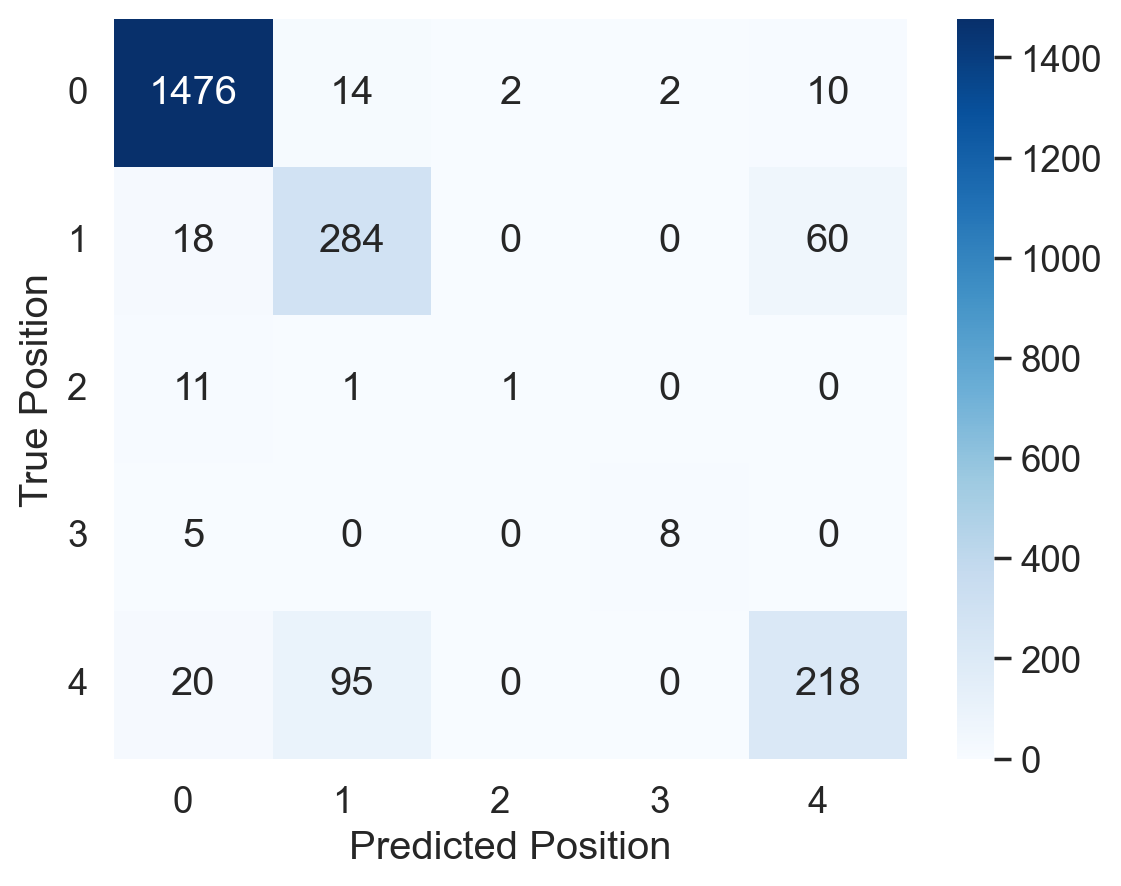

In [74]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

from SRC import utils
utils.show_confusion_matrix(df_cm)

Unique positions: [0 3 4 2 1]
Label encoder classes: [0 1 2 3 4]
Number of classes: 5

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1504
           1       0.72      0.78      0.75       362
           2       0.33      0.08      0.12        13
           3       0.80      0.62      0.70        13
           4       0.76      0.65      0.70       333

    accuracy                           0.89      2225
   macro avg       0.72      0.62      0.65      2225
weighted avg       0.89      0.89      0.89      2225



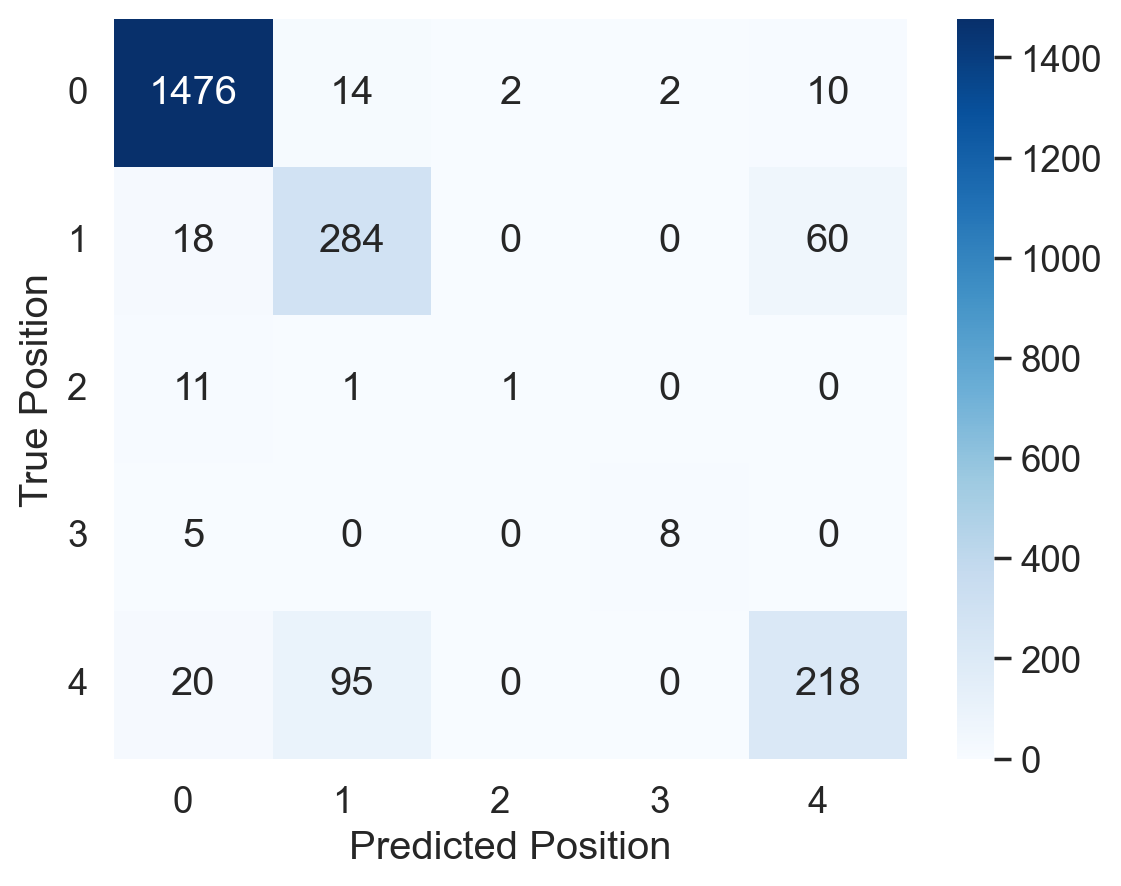

In [75]:
# First, verify the unique classes
unique_positions = merged2_subset['RabbitPosition'].unique()
print("Unique positions:", unique_positions)

# Explicitly create label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(merged2_subset['RabbitPosition'])

# Verify encoded classes
print("Label encoder classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))

# Update confusion matrix visualization
cm = confusion_matrix(labels, predictions)
class_labels = [str(c) for c in label_encoder.classes_]  # Convert to strings
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

utils.show_confusion_matrix(df_cm)

# For classification report
print("\nClassification Report:")
print(classification_report(
    labels, 
    predictions,
    target_names=class_labels,
    zero_division=0
))

In [101]:
def visualize_data_with_predictions(df, predictions, test_indices=None):
    """
    Visualize pressure data with actual and predicted positions as scatter plots
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pressure data and actual positions
    predictions : list or array
        Model predictions for rabbit positions
    test_indices : list or array, optional
        Indices of test data in the original dataframe
    """
    plt.figure(figsize=(18, 10))
    
    # Plot 1: Pressure data
    plt.subplot(2, 1, 1)
    pressure_cols = [col for col in df.columns if col.startswith('Pressure_')]
    for col in pressure_cols:
        plt.plot(df['time'], df[col], label=col.replace('Pressure_', ''))
    
    plt.title('Pressure Data Over Time', fontsize=14)
    plt.ylabel('Pressure (PSI)', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Plot 2: Actual vs Predicted positions
    plt.subplot(2, 1, 2)
    
    # Plot actual positions as scatter points (red)
    plt.scatter(df['time'], df['RabbitPosition'], color='red', s=50, alpha=0.7, label='Actual Position')
    
    # Plot predicted positions as scatter points (blue)
    if test_indices is not None:
        # Ensure test_indices are valid (within bounds of dataframe)
        valid_indices = [idx for idx in test_indices if idx < len(df)]
        
        if len(valid_indices) > 0:
            # If we have specific test indices
            test_times = df.iloc[valid_indices]['time'].values
            
            # Ensure predictions match the length of valid indices
            if len(predictions) == len(valid_indices):
                plt.scatter(test_times, predictions, color='blue', s=50, alpha=0.7, label='Predicted Position')
            else:
                # If lengths don't match, use the shorter length
                min_len = min(len(predictions), len(valid_indices))
                plt.scatter(test_times[:min_len], predictions[:min_len], color='blue', s=50, alpha=0.7, label='Predicted Position')
        else:
            print("Warning: No valid test indices found in the dataframe")
    else:
        # If predictions align with the last part of the dataframe
        prediction_count = len(predictions)
        test_start_idx = int(len(df) * 0.8)  # Assuming 80/20 train/test split
        
        # Ensure we don't exceed dataframe bounds
        available_count = len(df) - test_start_idx
        use_count = min(prediction_count, available_count)
        
        test_times = df['time'].iloc[test_start_idx:test_start_idx+use_count].values
        plt.scatter(test_times, predictions[:use_count], color='blue', s=50, alpha=0.7, label='Predicted Position')
    
    plt.title('Rabbit Position: Actual vs Predicted', fontsize=14)
    plt.ylabel('Position', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

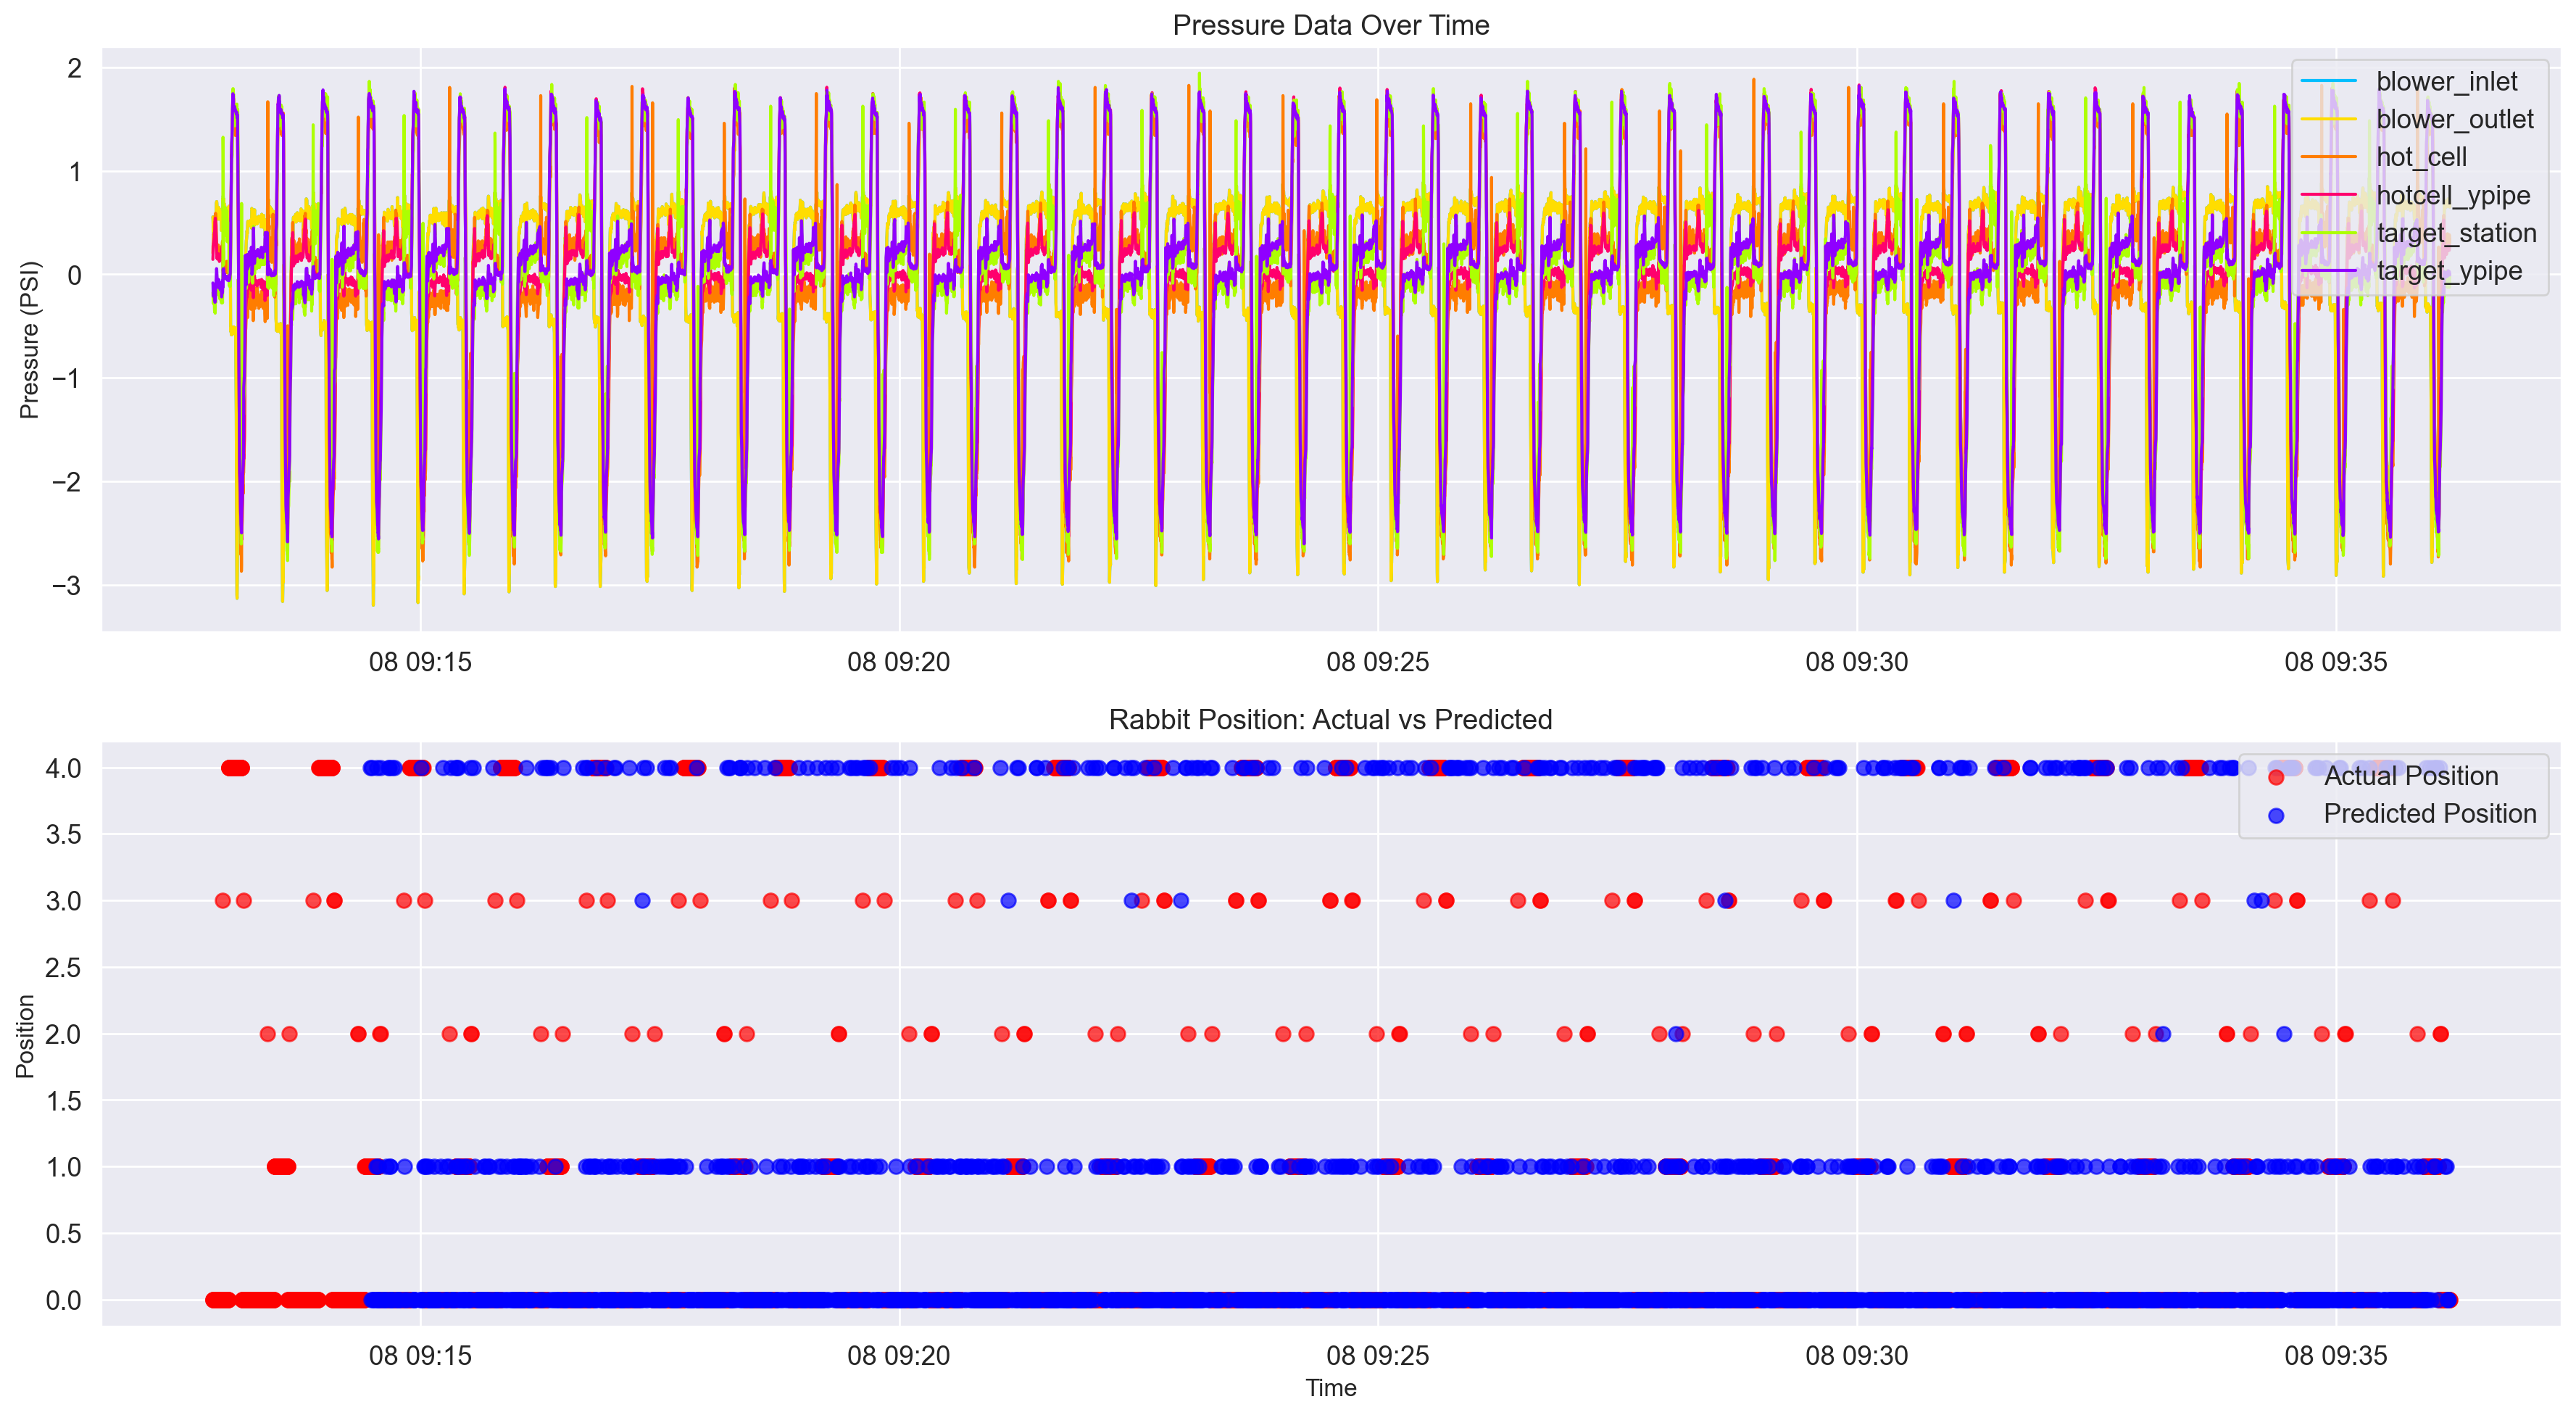

In [102]:
# Get the indices of test data in the original dataframe
test_df_time = test_data['time'] if 'time' in test_data.columns else None

# Option 1: If you have time in both dataframes
if test_df_time is not None:
    test_indices = merged2_subset[merged2_subset['time'].isin(test_df_time)].index
    visualize_data_with_predictions(merged2_subset, predictions, test_indices=test_indices)
else:
    # Option 2: Use the default 80/20 split
    visualize_data_with_predictions(merged2_subset, predictions)

=== First 10 minutes ===
10-minute window: 2025-04-08 09:12:50.080000 to 2025-04-08 09:22:50.080000
Window data points: 4757
Predictions in window: 805


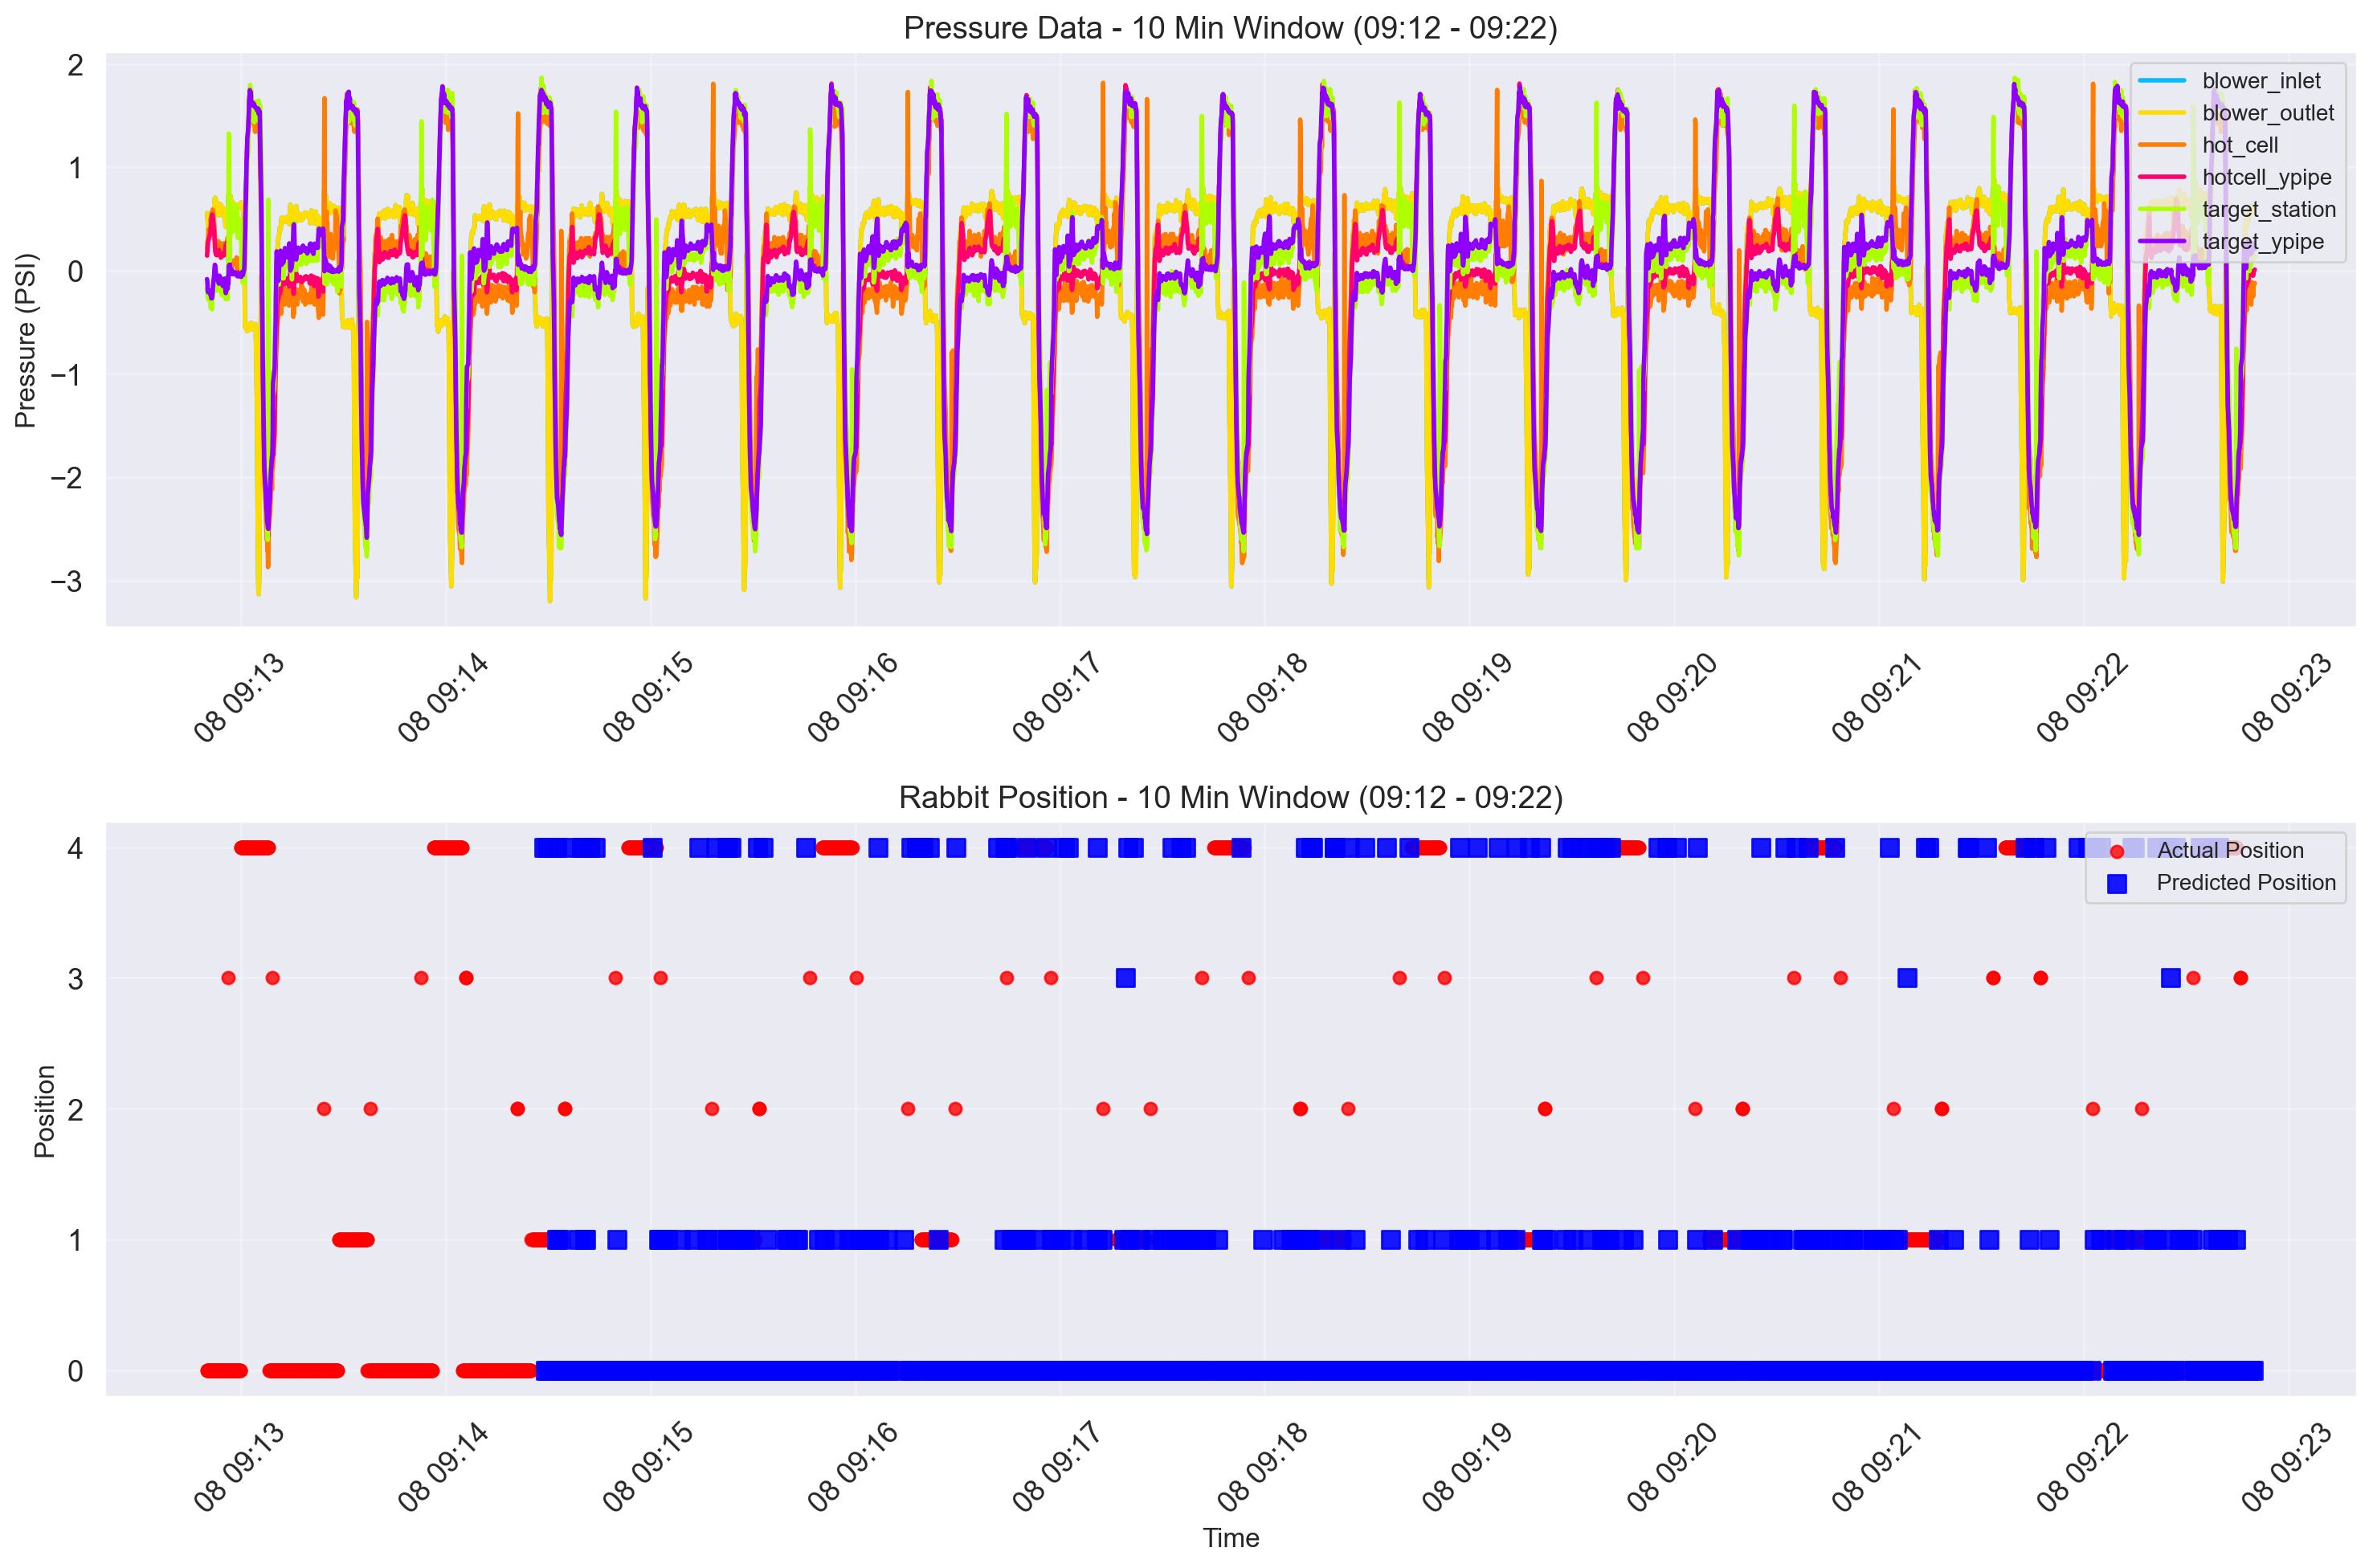


=== 10-20 minute window ===
10-minute window: 2025-04-08 09:22:50.080000 to 2025-04-08 09:32:50.080000
Window data points: 4766
Predictions in window: 954


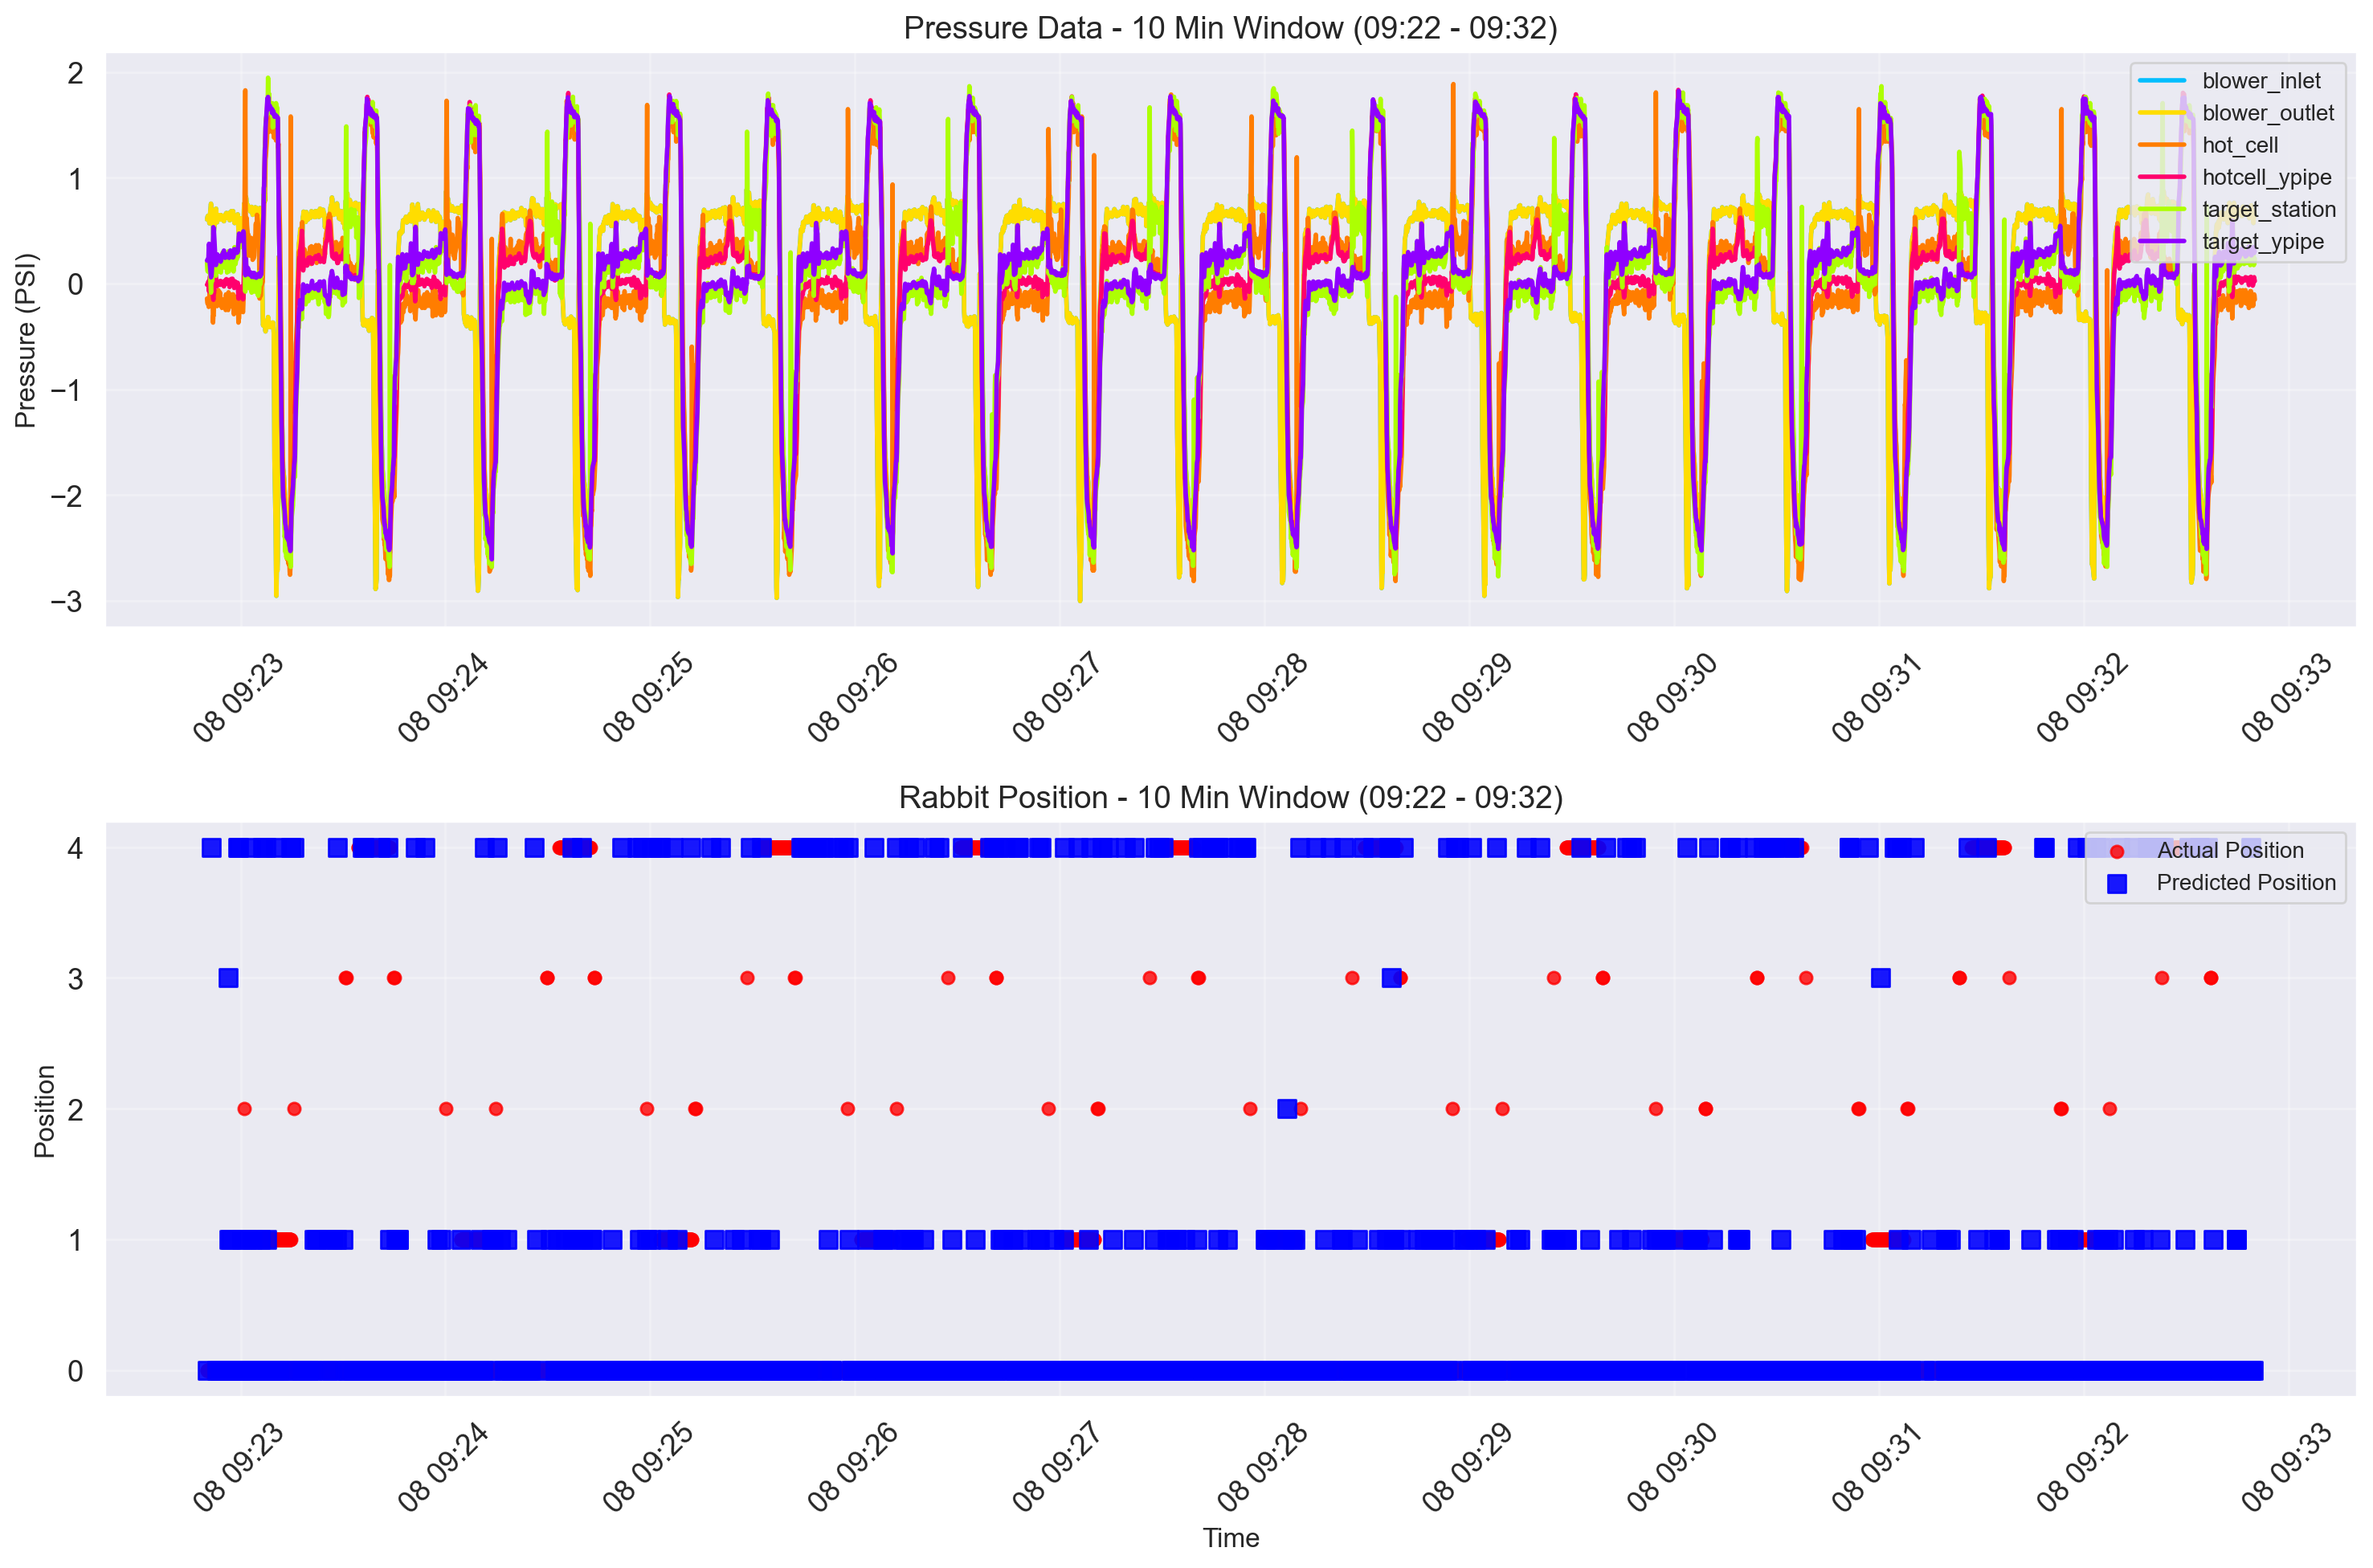


=== 20-30 minute window ===
10-minute window: 2025-04-08 09:32:50.080000 to 2025-04-08 09:42:50.080000
Window data points: 1599
Predictions in window: 307


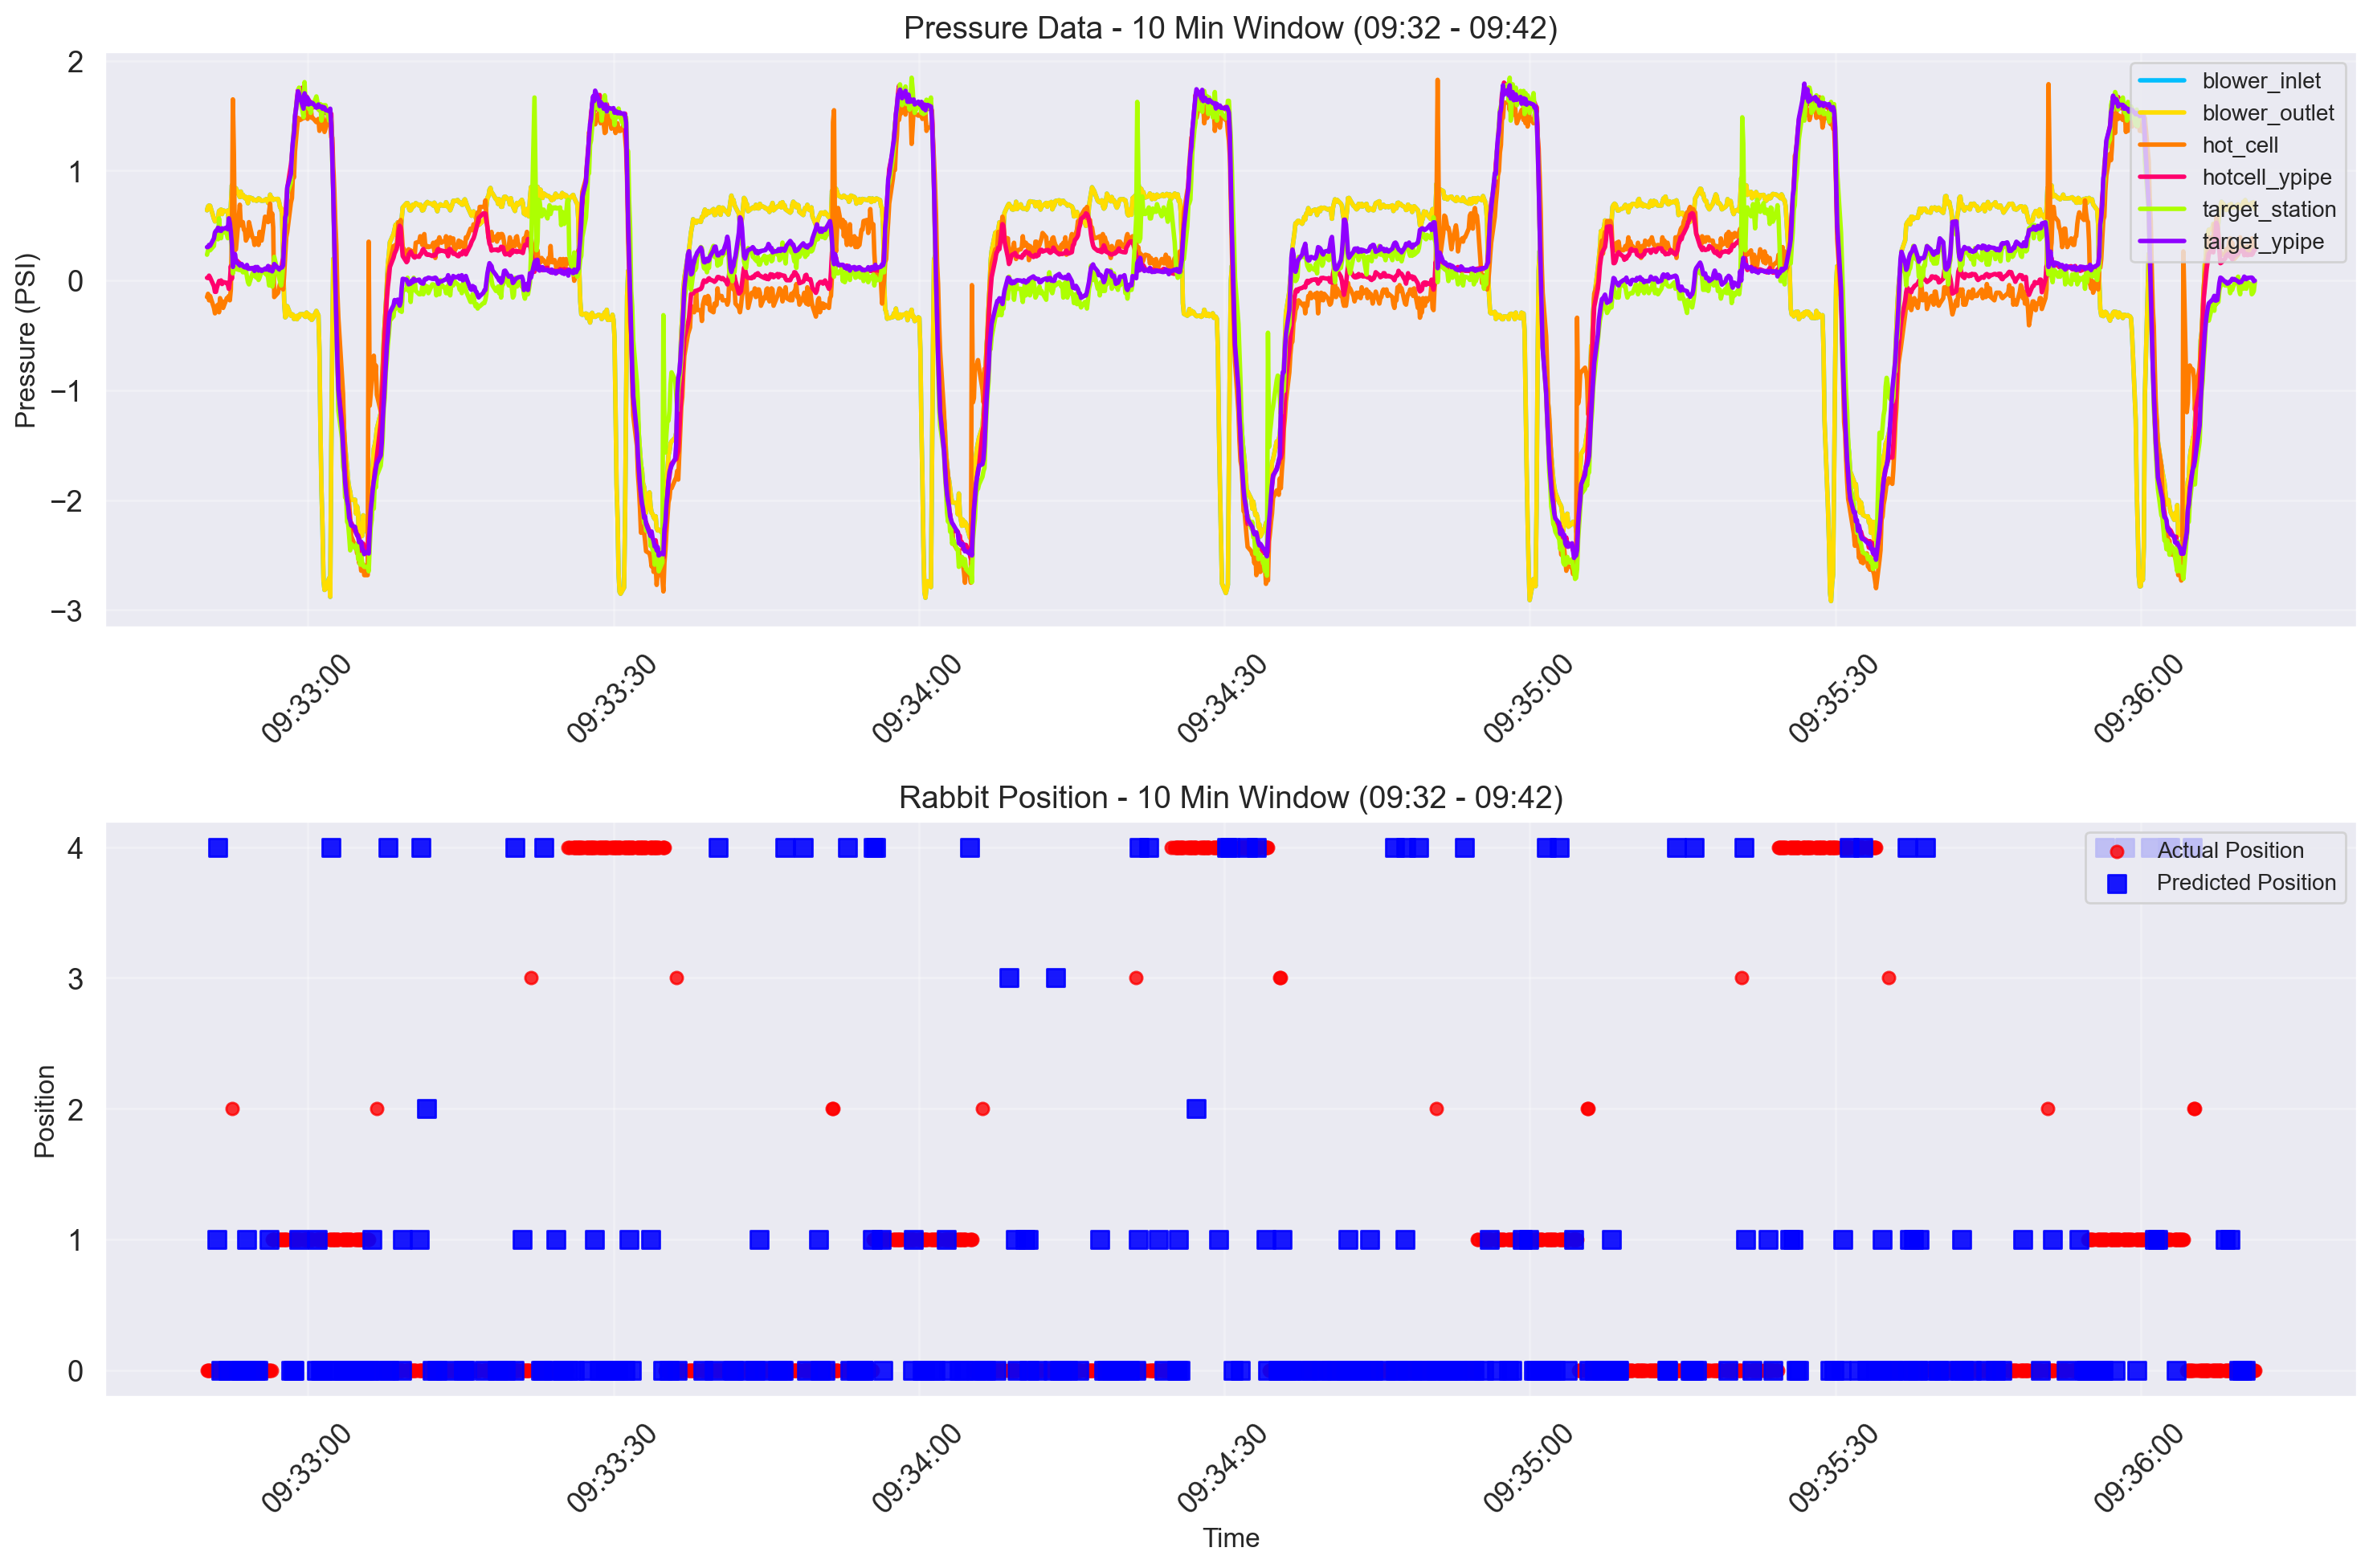

In [103]:
# Create a 10-minute window visualization
def plot_10_minute_window(df, predictions, test_indices=None, start_time_offset=0):
    """
    Plot a 10-minute window of pressure data and predictions
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pressure data and actual positions
    predictions : list or array
        Model predictions for rabbit positions
    test_indices : list or array, optional
        Indices of test data in the original dataframe
    start_time_offset : int, optional
        Minutes offset from the start of the dataset (default: 0)
    """
    # Get 10-minute window
    start_time = df['time'].min() + pd.Timedelta(minutes=start_time_offset)
    end_time = start_time + pd.Timedelta(minutes=10)
    
    # Filter data for the 10-minute window
    window_data = df[(df['time'] >= start_time) & (df['time'] <= end_time)].copy()
    
    if len(window_data) == 0:
        print(f"No data found in the 10-minute window starting at {start_time}")
        return
    
    print(f"10-minute window: {start_time} to {end_time}")
    print(f"Window data points: {len(window_data)}")
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Pressure data
    plt.subplot(2, 1, 1)
    pressure_cols = [col for col in window_data.columns if col.startswith('Pressure_')]
    for col in pressure_cols:
        plt.plot(window_data['time'], window_data[col], label=col.replace('Pressure_', ''), linewidth=2)
    
    plt.title(f'Pressure Data - 10 Min Window ({start_time.strftime("%H:%M")} - {end_time.strftime("%H:%M")})', fontsize=14)
    plt.ylabel('Pressure (PSI)', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot 2: Actual vs Predicted positions
    plt.subplot(2, 1, 2)
    
    # Plot actual positions as scatter points (red)
    plt.scatter(window_data['time'], window_data['RabbitPosition'], 
               color='red', s=30, alpha=0.8, label='Actual Position', zorder=3)
    
    # Plot predicted positions if they exist in this window
    if test_indices is not None:
        # Find test indices that fall within our time window
        window_test_indices = []
        window_predictions = []
        
        for i, idx in enumerate(test_indices):
            if idx < len(df) and df.iloc[idx]['time'] >= start_time and df.iloc[idx]['time'] <= end_time:
                if i < len(predictions):
                    window_test_indices.append(idx)
                    window_predictions.append(predictions[i])
        
        if window_predictions:
            test_times_in_window = df.iloc[window_test_indices]['time'].values
            plt.scatter(test_times_in_window, window_predictions, 
                       color='blue', s=60, alpha=0.9, label='Predicted Position', 
                       marker='s', zorder=4)
            print(f"Predictions in window: {len(window_predictions)}")
        else:
            print("No predictions found in this 10-minute window")
    else:
        # Use 80/20 split assumption and check if predictions fall in window
        test_start_idx = int(len(df) * 0.8)
        window_indices = window_data.index
        
        # Find which predictions correspond to this window
        window_predictions = []
        window_pred_times = []
        
        for i, pred in enumerate(predictions):
            pred_idx = test_start_idx + i
            if pred_idx < len(df) and pred_idx in window_indices:
                window_predictions.append(pred)
                window_pred_times.append(df.iloc[pred_idx]['time'])
        
        if window_predictions:
            plt.scatter(window_pred_times, window_predictions, 
                       color='blue', s=60, alpha=0.9, label='Predicted Position', 
                       marker='s', zorder=4)
            print(f"Predictions in window: {len(window_predictions)}")
    
    plt.title(f'Rabbit Position - 10 Min Window ({start_time.strftime("%H:%M")} - {end_time.strftime("%H:%M")})', fontsize=14)
    plt.ylabel('Position', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Set y-axis to show discrete position values
    unique_positions = sorted(window_data['RabbitPosition'].unique())
    plt.yticks(unique_positions)
    
    plt.tight_layout()
    plt.show()
    
    return window_data

# Use the function to plot different 10-minute windows
# First 10 minutes
print("=== First 10 minutes ===")
window1 = plot_10_minute_window(merged2_subset, predictions, test_indices=test_indices, start_time_offset=0)

# Middle 10 minutes (starting at 10 minutes into the data)
print("\n=== 10-20 minute window ===")
window2 = plot_10_minute_window(merged2_subset, predictions, test_indices=test_indices, start_time_offset=10)

# Last 10 minutes (starting at 20 minutes into the data)
print("\n=== 20-30 minute window ===")
window3 = plot_10_minute_window(merged2_subset, predictions, test_indices=test_indices, start_time_offset=20)

In [131]:
class PositionDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_cols, label_col):
        self.features = df[feature_cols].to_numpy(dtype=np.float32)
        self.labels = df[label_col].to_numpy(dtype=np.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            'sequence': features,
            'label': label
        }

class PositionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, feature_cols, label_col, batch_size=1):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = PositionDataset(self.train_df, self.feature_cols, self.label_col)
        self.test_dataset = PositionDataset(self.test_df, self.feature_cols, self.label_col)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [140]:
epochs = 250
batch_size = 8

data_module = PositionDataModule(
    train_data, test_data, FEATURE_COLS, LABEL_COL, batch_size=batch_size
)

In [141]:
class PositionModel_V4(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.25
        )

        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        return self.classifier(out)

In [142]:
class PositionPredictor_V4(pl.LightningModule):
  def __init__(self, n_features: int, n_classes: int):
    super().__init__()
    self.model = PositionModel_V3(n_features, n_classes)
    self.loss_fn = nn.CrossEntropyLoss()
    self.n_classes = n_classes

  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.loss_fn(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('training_loss', loss, prog_bar = True, logger = True)
    self.log('training_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('val_loss', loss, prog_bar = True, logger = True)
    self.log('val_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(
        predictions,
        labels,
        task='multiclass',
        num_classes=self.n_classes # Pass the stored number of classes
    )
    self.log('test_loss', loss, prog_bar = True, logger = True)
    self.log('test_acc', step_accuracy, prog_bar=True, logger=True)
    return {'loss': loss, 'accuracy':step_accuracy}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

In [143]:
unique_classes = len(label_encoder.classes_)
print(f"Number of unique classes: {unique_classes}")

model_V4 = PositionPredictor_V4(
    n_features=len(FEATURE_COLS),
    n_classes=unique_classes
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

training_losses = []
validation_losses = []
epoch_count = []
class LossCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        logs = trainer.callback_metrics
        train_loss = logs['training_loss'].item()
        val_loss = logs['val_loss'].item()
        
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        epoch_count.append(trainer.current_epoch)

logger = TensorBoardLogger('lightning_logs', name='surface-prediction_V4')



loss_callback = LossCallback()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback,loss_callback],
    max_epochs=epochs,
    accelerator='cpu',
    devices=1,
    enable_progress_bar=True,
)

Number of unique classes: 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [144]:
trainer.fit(model_V4, data_module)

c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Grant.Rousseau\ML Project - PTS Rabbit\Pressure_Model_V2\checkpoints exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | PositionModel_V3 | 3.1 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Grant.Rousseau\AppData\Local\anaconda3\envs\infernape\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1112/1112 [00:07<00:00, 139.22it/s, v_num=3, training_loss=0.361, training_acc=0.750, val_loss=0.453, val_acc=0.816]

Epoch 0, global step 1112: 'val_loss' reached 0.45330 (best 0.45330), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 1: 100%|██████████| 1112/1112 [00:08<00:00, 133.97it/s, v_num=3, training_loss=0.620, training_acc=0.750, val_loss=0.400, val_acc=0.829] 

Epoch 1, global step 2224: 'val_loss' reached 0.39977 (best 0.39977), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 2: 100%|██████████| 1112/1112 [00:12<00:00, 89.44it/s, v_num=3, training_loss=0.291, training_acc=0.875, val_loss=0.368, val_acc=0.841]  

Epoch 2, global step 3336: 'val_loss' reached 0.36812 (best 0.36812), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 3: 100%|██████████| 1112/1112 [00:13<00:00, 81.43it/s, v_num=3, training_loss=0.170, training_acc=0.875, val_loss=0.374, val_acc=0.841] 

Epoch 3, global step 4448: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 1112/1112 [00:13<00:00, 80.48it/s, v_num=3, training_loss=0.589, training_acc=0.750, val_loss=0.327, val_acc=0.861] 

Epoch 4, global step 5560: 'val_loss' reached 0.32678 (best 0.32678), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 5: 100%|██████████| 1112/1112 [00:12<00:00, 88.03it/s, v_num=3, training_loss=0.124, training_acc=1.000, val_loss=0.311, val_acc=0.869]  

Epoch 5, global step 6672: 'val_loss' reached 0.31080 (best 0.31080), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 6: 100%|██████████| 1112/1112 [00:12<00:00, 89.51it/s, v_num=3, training_loss=0.504, training_acc=0.875, val_loss=0.303, val_acc=0.869]   

Epoch 6, global step 7784: 'val_loss' reached 0.30269 (best 0.30269), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 7: 100%|██████████| 1112/1112 [00:12<00:00, 86.62it/s, v_num=3, training_loss=0.179, training_acc=0.875, val_loss=0.295, val_acc=0.876]  

Epoch 7, global step 8896: 'val_loss' reached 0.29518 (best 0.29518), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 8: 100%|██████████| 1112/1112 [00:13<00:00, 82.21it/s, v_num=3, training_loss=0.205, training_acc=0.875, val_loss=0.305, val_acc=0.874]  

Epoch 8, global step 10008: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 1112/1112 [00:11<00:00, 99.01it/s, v_num=3, training_loss=0.295, training_acc=0.750, val_loss=0.288, val_acc=0.882]   

Epoch 9, global step 11120: 'val_loss' reached 0.28791 (best 0.28791), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 10: 100%|██████████| 1112/1112 [00:11<00:00, 99.78it/s, v_num=3, training_loss=0.0437, training_acc=1.000, val_loss=0.299, val_acc=0.873] 

Epoch 10, global step 12232: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 1112/1112 [00:11<00:00, 97.57it/s, v_num=3, training_loss=0.271, training_acc=0.875, val_loss=0.290, val_acc=0.883]  

Epoch 11, global step 13344: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 1112/1112 [00:12<00:00, 91.71it/s, v_num=3, training_loss=0.294, training_acc=1.000, val_loss=0.267, val_acc=0.884]  

Epoch 12, global step 14456: 'val_loss' reached 0.26691 (best 0.26691), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 13: 100%|██████████| 1112/1112 [00:09<00:00, 118.16it/s, v_num=3, training_loss=0.204, training_acc=0.875, val_loss=0.279, val_acc=0.883] 

Epoch 13, global step 15568: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 1112/1112 [00:09<00:00, 120.78it/s, v_num=3, training_loss=0.889, training_acc=0.750, val_loss=0.266, val_acc=0.882]  

Epoch 14, global step 16680: 'val_loss' reached 0.26640 (best 0.26640), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 15: 100%|██████████| 1112/1112 [00:09<00:00, 122.98it/s, v_num=3, training_loss=0.162, training_acc=0.875, val_loss=0.264, val_acc=0.888]  

Epoch 15, global step 17792: 'val_loss' reached 0.26352 (best 0.26352), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 16: 100%|██████████| 1112/1112 [00:13<00:00, 82.55it/s, v_num=3, training_loss=0.0327, training_acc=1.000, val_loss=0.270, val_acc=0.880]  

Epoch 16, global step 18904: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 1112/1112 [00:14<00:00, 78.77it/s, v_num=3, training_loss=0.463, training_acc=0.750, val_loss=0.256, val_acc=0.884]  

Epoch 17, global step 20016: 'val_loss' reached 0.25561 (best 0.25561), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 18: 100%|██████████| 1112/1112 [00:11<00:00, 95.56it/s, v_num=3, training_loss=0.153, training_acc=0.875, val_loss=0.267, val_acc=0.878]  

Epoch 18, global step 21128: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 1112/1112 [00:09<00:00, 119.38it/s, v_num=3, training_loss=0.256, training_acc=0.875, val_loss=0.270, val_acc=0.878] 

Epoch 19, global step 22240: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 1112/1112 [00:09<00:00, 118.28it/s, v_num=3, training_loss=0.338, training_acc=0.750, val_loss=0.252, val_acc=0.883]  

Epoch 20, global step 23352: 'val_loss' reached 0.25160 (best 0.25160), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 21: 100%|██████████| 1112/1112 [00:09<00:00, 119.24it/s, v_num=3, training_loss=0.437, training_acc=0.875, val_loss=0.275, val_acc=0.879]  

Epoch 21, global step 24464: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 1112/1112 [00:09<00:00, 123.12it/s, v_num=3, training_loss=0.0969, training_acc=1.000, val_loss=0.254, val_acc=0.889]

Epoch 22, global step 25576: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 1112/1112 [00:09<00:00, 121.53it/s, v_num=3, training_loss=0.257, training_acc=0.875, val_loss=0.271, val_acc=0.873] 

Epoch 23, global step 26688: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 1112/1112 [00:09<00:00, 120.97it/s, v_num=3, training_loss=0.0417, training_acc=1.000, val_loss=0.249, val_acc=0.888] 

Epoch 24, global step 27800: 'val_loss' reached 0.24927 (best 0.24927), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 25: 100%|██████████| 1112/1112 [00:09<00:00, 117.71it/s, v_num=3, training_loss=0.298, training_acc=0.750, val_loss=0.245, val_acc=0.888]  

Epoch 25, global step 28912: 'val_loss' reached 0.24454 (best 0.24454), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 26: 100%|██████████| 1112/1112 [00:09<00:00, 122.45it/s, v_num=3, training_loss=0.532, training_acc=0.750, val_loss=0.239, val_acc=0.895]  

Epoch 26, global step 30024: 'val_loss' reached 0.23945 (best 0.23945), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 27: 100%|██████████| 1112/1112 [00:09<00:00, 117.00it/s, v_num=3, training_loss=0.00879, training_acc=1.000, val_loss=0.237, val_acc=0.894]

Epoch 27, global step 31136: 'val_loss' reached 0.23732 (best 0.23732), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 28: 100%|██████████| 1112/1112 [00:09<00:00, 121.16it/s, v_num=3, training_loss=0.301, training_acc=0.875, val_loss=0.238, val_acc=0.891]  

Epoch 28, global step 32248: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 1112/1112 [00:09<00:00, 113.88it/s, v_num=3, training_loss=0.0281, training_acc=1.000, val_loss=0.257, val_acc=0.881]

Epoch 29, global step 33360: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 1112/1112 [00:09<00:00, 121.51it/s, v_num=3, training_loss=0.443, training_acc=0.625, val_loss=0.233, val_acc=0.893]  

Epoch 30, global step 34472: 'val_loss' reached 0.23294 (best 0.23294), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 31: 100%|██████████| 1112/1112 [00:09<00:00, 116.91it/s, v_num=3, training_loss=0.232, training_acc=0.875, val_loss=0.241, val_acc=0.893]  

Epoch 31, global step 35584: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 1112/1112 [00:09<00:00, 120.73it/s, v_num=3, training_loss=0.030, training_acc=1.000, val_loss=0.234, val_acc=0.891]  

Epoch 32, global step 36696: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 1112/1112 [00:09<00:00, 121.50it/s, v_num=3, training_loss=0.0675, training_acc=1.000, val_loss=0.234, val_acc=0.893] 

Epoch 33, global step 37808: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 1112/1112 [00:09<00:00, 119.53it/s, v_num=3, training_loss=0.155, training_acc=0.875, val_loss=0.272, val_acc=0.877]  

Epoch 34, global step 38920: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 1112/1112 [00:09<00:00, 118.57it/s, v_num=3, training_loss=0.0494, training_acc=1.000, val_loss=0.234, val_acc=0.892] 

Epoch 35, global step 40032: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 1112/1112 [00:09<00:00, 120.88it/s, v_num=3, training_loss=0.125, training_acc=0.875, val_loss=0.237, val_acc=0.884]  

Epoch 36, global step 41144: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 1112/1112 [00:09<00:00, 112.24it/s, v_num=3, training_loss=0.159, training_acc=1.000, val_loss=0.253, val_acc=0.882]   

Epoch 37, global step 42256: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 1112/1112 [00:09<00:00, 117.41it/s, v_num=3, training_loss=0.166, training_acc=0.875, val_loss=0.231, val_acc=0.891]  

Epoch 38, global step 43368: 'val_loss' reached 0.23129 (best 0.23129), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 39: 100%|██████████| 1112/1112 [00:09<00:00, 120.26it/s, v_num=3, training_loss=0.200, training_acc=0.875, val_loss=0.247, val_acc=0.884]  

Epoch 39, global step 44480: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 1112/1112 [00:09<00:00, 121.49it/s, v_num=3, training_loss=0.191, training_acc=1.000, val_loss=0.228, val_acc=0.894]   

Epoch 40, global step 45592: 'val_loss' reached 0.22779 (best 0.22779), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 41: 100%|██████████| 1112/1112 [00:09<00:00, 116.41it/s, v_num=3, training_loss=0.123, training_acc=0.875, val_loss=0.234, val_acc=0.888]  

Epoch 41, global step 46704: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 1112/1112 [00:09<00:00, 118.91it/s, v_num=3, training_loss=0.106, training_acc=1.000, val_loss=0.238, val_acc=0.889]  

Epoch 42, global step 47816: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 1112/1112 [00:09<00:00, 114.87it/s, v_num=3, training_loss=0.465, training_acc=0.875, val_loss=0.227, val_acc=0.887] 

Epoch 43, global step 48928: 'val_loss' reached 0.22687 (best 0.22687), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 44: 100%|██████████| 1112/1112 [00:11<00:00, 100.47it/s, v_num=3, training_loss=0.348, training_acc=0.750, val_loss=0.246, val_acc=0.885]  

Epoch 44, global step 50040: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 1112/1112 [00:09<00:00, 117.31it/s, v_num=3, training_loss=0.331, training_acc=0.875, val_loss=0.231, val_acc=0.892]  

Epoch 45, global step 51152: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 1112/1112 [00:09<00:00, 117.51it/s, v_num=3, training_loss=0.138, training_acc=0.875, val_loss=0.232, val_acc=0.888]  

Epoch 46, global step 52264: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 1112/1112 [00:10<00:00, 110.96it/s, v_num=3, training_loss=0.297, training_acc=0.750, val_loss=0.225, val_acc=0.890]  

Epoch 47, global step 53376: 'val_loss' reached 0.22516 (best 0.22516), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 48: 100%|██████████| 1112/1112 [00:09<00:00, 113.51it/s, v_num=3, training_loss=0.202, training_acc=1.000, val_loss=0.233, val_acc=0.886]  

Epoch 48, global step 54488: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 1112/1112 [00:09<00:00, 112.57it/s, v_num=3, training_loss=0.234, training_acc=0.875, val_loss=0.245, val_acc=0.884]  

Epoch 49, global step 55600: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 1112/1112 [00:09<00:00, 114.97it/s, v_num=3, training_loss=0.125, training_acc=1.000, val_loss=0.235, val_acc=0.886]  

Epoch 50, global step 56712: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 1112/1112 [00:09<00:00, 118.17it/s, v_num=3, training_loss=0.635, training_acc=0.875, val_loss=0.230, val_acc=0.890]   

Epoch 51, global step 57824: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 1112/1112 [00:09<00:00, 115.66it/s, v_num=3, training_loss=0.642, training_acc=0.875, val_loss=0.225, val_acc=0.897]  

Epoch 52, global step 58936: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 1112/1112 [00:09<00:00, 115.57it/s, v_num=3, training_loss=0.0565, training_acc=1.000, val_loss=0.219, val_acc=0.892] 

Epoch 53, global step 60048: 'val_loss' reached 0.21908 (best 0.21908), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 54: 100%|██████████| 1112/1112 [00:09<00:00, 117.82it/s, v_num=3, training_loss=0.392, training_acc=0.750, val_loss=0.227, val_acc=0.889]  

Epoch 54, global step 61160: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 1112/1112 [00:09<00:00, 115.84it/s, v_num=3, training_loss=0.310, training_acc=0.625, val_loss=0.226, val_acc=0.895]  

Epoch 55, global step 62272: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 1112/1112 [00:09<00:00, 113.99it/s, v_num=3, training_loss=0.0908, training_acc=1.000, val_loss=0.230, val_acc=0.892] 

Epoch 56, global step 63384: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 1112/1112 [00:09<00:00, 116.39it/s, v_num=3, training_loss=0.229, training_acc=0.750, val_loss=0.224, val_acc=0.894]  

Epoch 57, global step 64496: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 1112/1112 [00:09<00:00, 117.06it/s, v_num=3, training_loss=0.0261, training_acc=1.000, val_loss=0.219, val_acc=0.897] 

Epoch 58, global step 65608: 'val_loss' reached 0.21892 (best 0.21892), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 59: 100%|██████████| 1112/1112 [00:09<00:00, 119.55it/s, v_num=3, training_loss=0.128, training_acc=1.000, val_loss=0.236, val_acc=0.893]  

Epoch 59, global step 66720: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 1112/1112 [00:09<00:00, 120.60it/s, v_num=3, training_loss=0.0702, training_acc=1.000, val_loss=0.217, val_acc=0.902] 

Epoch 60, global step 67832: 'val_loss' reached 0.21745 (best 0.21745), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 61: 100%|██████████| 1112/1112 [00:09<00:00, 116.62it/s, v_num=3, training_loss=0.155, training_acc=0.875, val_loss=0.237, val_acc=0.896]  

Epoch 61, global step 68944: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 1112/1112 [00:09<00:00, 113.18it/s, v_num=3, training_loss=0.351, training_acc=0.750, val_loss=0.222, val_acc=0.893]  

Epoch 62, global step 70056: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 1112/1112 [00:09<00:00, 112.61it/s, v_num=3, training_loss=0.541, training_acc=0.625, val_loss=0.221, val_acc=0.898]   

Epoch 63, global step 71168: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 1112/1112 [00:09<00:00, 119.47it/s, v_num=3, training_loss=0.112, training_acc=1.000, val_loss=0.219, val_acc=0.899]  

Epoch 64, global step 72280: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 1112/1112 [00:09<00:00, 111.48it/s, v_num=3, training_loss=0.525, training_acc=0.875, val_loss=0.229, val_acc=0.901]  

Epoch 65, global step 73392: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 1112/1112 [00:09<00:00, 114.09it/s, v_num=3, training_loss=0.0484, training_acc=1.000, val_loss=0.214, val_acc=0.897] 

Epoch 66, global step 74504: 'val_loss' reached 0.21416 (best 0.21416), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 67: 100%|██████████| 1112/1112 [00:09<00:00, 117.79it/s, v_num=3, training_loss=0.095, training_acc=0.875, val_loss=0.228, val_acc=0.900]  

Epoch 67, global step 75616: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 1112/1112 [00:10<00:00, 108.65it/s, v_num=3, training_loss=0.0104, training_acc=1.000, val_loss=0.219, val_acc=0.895] 

Epoch 68, global step 76728: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 1112/1112 [00:09<00:00, 115.10it/s, v_num=3, training_loss=0.196, training_acc=0.875, val_loss=0.225, val_acc=0.895]  

Epoch 69, global step 77840: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 1112/1112 [00:09<00:00, 116.85it/s, v_num=3, training_loss=0.261, training_acc=0.750, val_loss=0.222, val_acc=0.895]  

Epoch 70, global step 78952: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 1112/1112 [00:09<00:00, 112.72it/s, v_num=3, training_loss=0.195, training_acc=0.875, val_loss=0.211, val_acc=0.899]  

Epoch 71, global step 80064: 'val_loss' reached 0.21087 (best 0.21087), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 72: 100%|██████████| 1112/1112 [00:10<00:00, 103.66it/s, v_num=3, training_loss=0.0238, training_acc=1.000, val_loss=0.222, val_acc=0.890] 

Epoch 72, global step 81176: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 1112/1112 [00:10<00:00, 110.80it/s, v_num=3, training_loss=0.183, training_acc=1.000, val_loss=0.214, val_acc=0.897]  

Epoch 73, global step 82288: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 1112/1112 [00:09<00:00, 114.49it/s, v_num=3, training_loss=0.0189, training_acc=1.000, val_loss=0.219, val_acc=0.893] 

Epoch 74, global step 83400: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 1112/1112 [00:09<00:00, 112.41it/s, v_num=3, training_loss=0.208, training_acc=0.875, val_loss=0.224, val_acc=0.891]  

Epoch 75, global step 84512: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 1112/1112 [00:09<00:00, 114.32it/s, v_num=3, training_loss=0.0742, training_acc=1.000, val_loss=0.208, val_acc=0.901] 

Epoch 76, global step 85624: 'val_loss' reached 0.20816 (best 0.20816), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 77: 100%|██████████| 1112/1112 [00:10<00:00, 103.61it/s, v_num=3, training_loss=0.145, training_acc=0.875, val_loss=0.230, val_acc=0.898]  

Epoch 77, global step 86736: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 1112/1112 [00:11<00:00, 98.23it/s, v_num=3, training_loss=0.171, training_acc=0.875, val_loss=0.217, val_acc=0.893]   

Epoch 78, global step 87848: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 1112/1112 [00:11<00:00, 96.81it/s, v_num=3, training_loss=0.0977, training_acc=0.875, val_loss=0.227, val_acc=0.892]  

Epoch 79, global step 88960: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 1112/1112 [00:10<00:00, 102.35it/s, v_num=3, training_loss=0.229, training_acc=1.000, val_loss=0.213, val_acc=0.899]  

Epoch 80, global step 90072: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 1112/1112 [00:10<00:00, 106.28it/s, v_num=3, training_loss=0.194, training_acc=1.000, val_loss=0.213, val_acc=0.898]   

Epoch 81, global step 91184: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 1112/1112 [00:09<00:00, 114.25it/s, v_num=3, training_loss=0.105, training_acc=1.000, val_loss=0.215, val_acc=0.901]  

Epoch 82, global step 92296: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 1112/1112 [00:09<00:00, 114.95it/s, v_num=3, training_loss=0.0483, training_acc=1.000, val_loss=0.218, val_acc=0.900]  

Epoch 83, global step 93408: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 1112/1112 [00:09<00:00, 114.45it/s, v_num=3, training_loss=0.161, training_acc=1.000, val_loss=0.211, val_acc=0.901]   

Epoch 84, global step 94520: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 1112/1112 [00:09<00:00, 113.95it/s, v_num=3, training_loss=0.753, training_acc=0.500, val_loss=0.219, val_acc=0.893]  

Epoch 85, global step 95632: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 1112/1112 [00:09<00:00, 111.96it/s, v_num=3, training_loss=0.109, training_acc=1.000, val_loss=0.228, val_acc=0.890]  

Epoch 86, global step 96744: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 1112/1112 [00:09<00:00, 113.87it/s, v_num=3, training_loss=0.187, training_acc=0.875, val_loss=0.209, val_acc=0.896]  

Epoch 87, global step 97856: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 1112/1112 [00:09<00:00, 112.76it/s, v_num=3, training_loss=0.208, training_acc=0.875, val_loss=0.209, val_acc=0.900]   

Epoch 88, global step 98968: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 1112/1112 [00:11<00:00, 97.61it/s, v_num=3, training_loss=0.285, training_acc=0.750, val_loss=0.215, val_acc=0.893]    

Epoch 89, global step 100080: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 1112/1112 [00:10<00:00, 102.09it/s, v_num=3, training_loss=0.286, training_acc=0.750, val_loss=0.211, val_acc=0.902]  

Epoch 90, global step 101192: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 1112/1112 [00:10<00:00, 108.97it/s, v_num=3, training_loss=0.166, training_acc=0.875, val_loss=0.208, val_acc=0.898]  

Epoch 91, global step 102304: 'val_loss' reached 0.20797 (best 0.20797), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 92: 100%|██████████| 1112/1112 [00:09<00:00, 114.01it/s, v_num=3, training_loss=0.280, training_acc=0.875, val_loss=0.229, val_acc=0.895]  

Epoch 92, global step 103416: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 1112/1112 [00:09<00:00, 115.36it/s, v_num=3, training_loss=0.0704, training_acc=1.000, val_loss=0.222, val_acc=0.892]  

Epoch 93, global step 104528: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 1112/1112 [00:09<00:00, 115.01it/s, v_num=3, training_loss=0.0104, training_acc=1.000, val_loss=0.217, val_acc=0.902]  

Epoch 94, global step 105640: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 1112/1112 [00:09<00:00, 112.24it/s, v_num=3, training_loss=0.0382, training_acc=1.000, val_loss=0.217, val_acc=0.894]  

Epoch 95, global step 106752: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 1112/1112 [00:10<00:00, 110.20it/s, v_num=3, training_loss=0.413, training_acc=0.875, val_loss=0.212, val_acc=0.902]  

Epoch 96, global step 107864: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 1112/1112 [00:09<00:00, 112.05it/s, v_num=3, training_loss=0.317, training_acc=0.750, val_loss=0.215, val_acc=0.898]  

Epoch 97, global step 108976: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 1112/1112 [00:09<00:00, 115.39it/s, v_num=3, training_loss=0.130, training_acc=1.000, val_loss=0.204, val_acc=0.900]  

Epoch 98, global step 110088: 'val_loss' reached 0.20445 (best 0.20445), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 99: 100%|██████████| 1112/1112 [00:09<00:00, 114.19it/s, v_num=3, training_loss=0.166, training_acc=0.875, val_loss=0.207, val_acc=0.898]  

Epoch 99, global step 111200: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 1112/1112 [00:09<00:00, 113.81it/s, v_num=3, training_loss=0.134, training_acc=1.000, val_loss=0.225, val_acc=0.888]  

Epoch 100, global step 112312: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 1112/1112 [00:09<00:00, 115.72it/s, v_num=3, training_loss=0.0579, training_acc=1.000, val_loss=0.215, val_acc=0.898]  

Epoch 101, global step 113424: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 1112/1112 [00:09<00:00, 113.50it/s, v_num=3, training_loss=0.199, training_acc=0.875, val_loss=0.203, val_acc=0.898]  

Epoch 102, global step 114536: 'val_loss' reached 0.20322 (best 0.20322), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 103: 100%|██████████| 1112/1112 [00:10<00:00, 110.99it/s, v_num=3, training_loss=0.237, training_acc=0.875, val_loss=0.209, val_acc=0.896]   

Epoch 103, global step 115648: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 1112/1112 [00:10<00:00, 107.87it/s, v_num=3, training_loss=0.300, training_acc=0.750, val_loss=0.209, val_acc=0.900]  

Epoch 104, global step 116760: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 1112/1112 [00:10<00:00, 103.85it/s, v_num=3, training_loss=0.114, training_acc=1.000, val_loss=0.206, val_acc=0.898]  

Epoch 105, global step 117872: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 1112/1112 [00:10<00:00, 104.58it/s, v_num=3, training_loss=0.095, training_acc=1.000, val_loss=0.210, val_acc=0.899]   

Epoch 106, global step 118984: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 1112/1112 [00:09<00:00, 111.22it/s, v_num=3, training_loss=0.114, training_acc=1.000, val_loss=0.208, val_acc=0.900]  

Epoch 107, global step 120096: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 1112/1112 [00:09<00:00, 119.55it/s, v_num=3, training_loss=0.0589, training_acc=1.000, val_loss=0.226, val_acc=0.896] 

Epoch 108, global step 121208: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 1112/1112 [00:09<00:00, 115.99it/s, v_num=3, training_loss=0.156, training_acc=0.875, val_loss=0.224, val_acc=0.892]  

Epoch 109, global step 122320: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 1112/1112 [00:09<00:00, 120.50it/s, v_num=3, training_loss=0.158, training_acc=1.000, val_loss=0.202, val_acc=0.902]   

Epoch 110, global step 123432: 'val_loss' reached 0.20150 (best 0.20150), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 111: 100%|██████████| 1112/1112 [00:09<00:00, 119.86it/s, v_num=3, training_loss=0.582, training_acc=0.750, val_loss=0.200, val_acc=0.902]  

Epoch 111, global step 124544: 'val_loss' reached 0.20026 (best 0.20026), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 112: 100%|██████████| 1112/1112 [00:08<00:00, 125.19it/s, v_num=3, training_loss=0.0104, training_acc=1.000, val_loss=0.208, val_acc=0.903]  

Epoch 112, global step 125656: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 1112/1112 [00:09<00:00, 122.08it/s, v_num=3, training_loss=0.181, training_acc=1.000, val_loss=0.216, val_acc=0.905]  

Epoch 113, global step 126768: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 1112/1112 [00:09<00:00, 120.69it/s, v_num=3, training_loss=0.121, training_acc=1.000, val_loss=0.208, val_acc=0.903]   

Epoch 114, global step 127880: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 1112/1112 [00:09<00:00, 120.55it/s, v_num=3, training_loss=0.129, training_acc=0.875, val_loss=0.211, val_acc=0.894]   

Epoch 115, global step 128992: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 1112/1112 [00:09<00:00, 115.19it/s, v_num=3, training_loss=0.084, training_acc=1.000, val_loss=0.202, val_acc=0.902]   

Epoch 116, global step 130104: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 1112/1112 [00:09<00:00, 116.55it/s, v_num=3, training_loss=0.223, training_acc=0.750, val_loss=0.206, val_acc=0.899]   

Epoch 117, global step 131216: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 1112/1112 [00:09<00:00, 120.53it/s, v_num=3, training_loss=0.589, training_acc=0.750, val_loss=0.213, val_acc=0.897]  

Epoch 118, global step 132328: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 1112/1112 [00:08<00:00, 124.18it/s, v_num=3, training_loss=0.0471, training_acc=1.000, val_loss=0.214, val_acc=0.902]  

Epoch 119, global step 133440: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 1112/1112 [00:08<00:00, 125.77it/s, v_num=3, training_loss=0.142, training_acc=0.875, val_loss=0.202, val_acc=0.905]   

Epoch 120, global step 134552: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 1112/1112 [00:08<00:00, 124.47it/s, v_num=3, training_loss=0.250, training_acc=0.875, val_loss=0.204, val_acc=0.900]  

Epoch 121, global step 135664: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 1112/1112 [00:09<00:00, 122.37it/s, v_num=3, training_loss=0.107, training_acc=0.875, val_loss=0.199, val_acc=0.902]  

Epoch 122, global step 136776: 'val_loss' reached 0.19948 (best 0.19948), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 123: 100%|██████████| 1112/1112 [00:09<00:00, 119.04it/s, v_num=3, training_loss=0.100, training_acc=0.875, val_loss=0.203, val_acc=0.899]  

Epoch 123, global step 137888: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 1112/1112 [00:09<00:00, 114.63it/s, v_num=3, training_loss=0.275, training_acc=0.750, val_loss=0.209, val_acc=0.898]   

Epoch 124, global step 139000: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 1112/1112 [00:08<00:00, 125.44it/s, v_num=3, training_loss=0.0364, training_acc=1.000, val_loss=0.203, val_acc=0.904] 

Epoch 125, global step 140112: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 1112/1112 [00:09<00:00, 120.33it/s, v_num=3, training_loss=0.179, training_acc=0.875, val_loss=0.205, val_acc=0.896]   

Epoch 126, global step 141224: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 1112/1112 [00:09<00:00, 121.50it/s, v_num=3, training_loss=0.0412, training_acc=1.000, val_loss=0.201, val_acc=0.902]  

Epoch 127, global step 142336: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 1112/1112 [00:09<00:00, 111.51it/s, v_num=3, training_loss=0.435, training_acc=0.750, val_loss=0.204, val_acc=0.907]  

Epoch 128, global step 143448: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 1112/1112 [00:09<00:00, 117.22it/s, v_num=3, training_loss=0.0658, training_acc=1.000, val_loss=0.201, val_acc=0.907]  

Epoch 129, global step 144560: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 1112/1112 [00:09<00:00, 118.46it/s, v_num=3, training_loss=0.137, training_acc=0.875, val_loss=0.202, val_acc=0.905]  

Epoch 130, global step 145672: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 1112/1112 [00:08<00:00, 125.64it/s, v_num=3, training_loss=0.169, training_acc=0.875, val_loss=0.207, val_acc=0.899]   

Epoch 131, global step 146784: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 1112/1112 [00:08<00:00, 124.62it/s, v_num=3, training_loss=0.0918, training_acc=1.000, val_loss=0.200, val_acc=0.902]  

Epoch 132, global step 147896: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 1112/1112 [00:08<00:00, 125.46it/s, v_num=3, training_loss=0.247, training_acc=0.875, val_loss=0.198, val_acc=0.903]   

Epoch 133, global step 149008: 'val_loss' reached 0.19834 (best 0.19834), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 134: 100%|██████████| 1112/1112 [00:09<00:00, 118.69it/s, v_num=3, training_loss=0.421, training_acc=0.750, val_loss=0.235, val_acc=0.883]   

Epoch 134, global step 150120: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 1112/1112 [00:09<00:00, 118.08it/s, v_num=3, training_loss=0.240, training_acc=0.875, val_loss=0.208, val_acc=0.897]   

Epoch 135, global step 151232: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 1112/1112 [00:09<00:00, 113.90it/s, v_num=3, training_loss=0.300, training_acc=0.750, val_loss=0.199, val_acc=0.902]  

Epoch 136, global step 152344: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 1112/1112 [00:09<00:00, 121.10it/s, v_num=3, training_loss=0.245, training_acc=0.875, val_loss=0.204, val_acc=0.903]   

Epoch 137, global step 153456: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 1112/1112 [00:09<00:00, 120.56it/s, v_num=3, training_loss=0.145, training_acc=0.875, val_loss=0.208, val_acc=0.901]   

Epoch 138, global step 154568: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 1112/1112 [00:09<00:00, 120.73it/s, v_num=3, training_loss=0.282, training_acc=0.875, val_loss=0.207, val_acc=0.895]  

Epoch 139, global step 155680: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 1112/1112 [00:09<00:00, 120.96it/s, v_num=3, training_loss=0.730, training_acc=0.750, val_loss=0.192, val_acc=0.906]   

Epoch 140, global step 156792: 'val_loss' reached 0.19206 (best 0.19206), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 141: 100%|██████████| 1112/1112 [00:10<00:00, 111.00it/s, v_num=3, training_loss=0.0363, training_acc=1.000, val_loss=0.205, val_acc=0.903] 

Epoch 141, global step 157904: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 1112/1112 [00:10<00:00, 107.31it/s, v_num=3, training_loss=0.585, training_acc=0.750, val_loss=0.197, val_acc=0.899]  

Epoch 142, global step 159016: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 1112/1112 [00:10<00:00, 111.11it/s, v_num=3, training_loss=0.198, training_acc=0.875, val_loss=0.199, val_acc=0.904]  

Epoch 143, global step 160128: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 1112/1112 [00:09<00:00, 118.99it/s, v_num=3, training_loss=0.00639, training_acc=1.000, val_loss=0.215, val_acc=0.898] 

Epoch 144, global step 161240: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 1112/1112 [00:09<00:00, 119.56it/s, v_num=3, training_loss=0.178, training_acc=0.875, val_loss=0.202, val_acc=0.901]  

Epoch 145, global step 162352: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 1112/1112 [00:08<00:00, 124.02it/s, v_num=3, training_loss=0.0117, training_acc=1.000, val_loss=0.196, val_acc=0.904] 

Epoch 146, global step 163464: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 1112/1112 [00:09<00:00, 111.63it/s, v_num=3, training_loss=0.0331, training_acc=1.000, val_loss=0.213, val_acc=0.900]  

Epoch 147, global step 164576: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 1112/1112 [00:11<00:00, 96.56it/s, v_num=3, training_loss=0.329, training_acc=0.875, val_loss=0.206, val_acc=0.897]    

Epoch 148, global step 165688: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 1112/1112 [00:13<00:00, 81.26it/s, v_num=3, training_loss=0.185, training_acc=0.875, val_loss=0.194, val_acc=0.908]   

Epoch 149, global step 166800: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 1112/1112 [00:12<00:00, 86.24it/s, v_num=3, training_loss=0.105, training_acc=1.000, val_loss=0.221, val_acc=0.893]    

Epoch 150, global step 167912: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 1112/1112 [00:11<00:00, 95.08it/s, v_num=3, training_loss=0.0993, training_acc=1.000, val_loss=0.210, val_acc=0.900]  

Epoch 151, global step 169024: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 1112/1112 [00:12<00:00, 91.94it/s, v_num=3, training_loss=0.265, training_acc=0.750, val_loss=0.194, val_acc=0.904]   

Epoch 152, global step 170136: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 1112/1112 [00:14<00:00, 78.46it/s, v_num=3, training_loss=0.103, training_acc=0.875, val_loss=0.215, val_acc=0.901]  

Epoch 153, global step 171248: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 1112/1112 [00:13<00:00, 80.05it/s, v_num=3, training_loss=0.0155, training_acc=1.000, val_loss=0.213, val_acc=0.894] 

Epoch 154, global step 172360: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 1112/1112 [00:11<00:00, 94.64it/s, v_num=3, training_loss=0.512, training_acc=0.750, val_loss=0.201, val_acc=0.899]    

Epoch 155, global step 173472: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 1112/1112 [00:13<00:00, 83.33it/s, v_num=3, training_loss=0.0598, training_acc=1.000, val_loss=0.210, val_acc=0.899]  

Epoch 156, global step 174584: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 1112/1112 [00:15<00:00, 69.90it/s, v_num=3, training_loss=0.129, training_acc=0.875, val_loss=0.199, val_acc=0.903]  

Epoch 157, global step 175696: 'val_loss' was not in top 1


Epoch 158: 100%|██████████| 1112/1112 [00:13<00:00, 85.06it/s, v_num=3, training_loss=0.279, training_acc=0.875, val_loss=0.204, val_acc=0.900]   

Epoch 158, global step 176808: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 1112/1112 [00:12<00:00, 85.99it/s, v_num=3, training_loss=0.0994, training_acc=0.875, val_loss=0.196, val_acc=0.907]   

Epoch 159, global step 177920: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 1112/1112 [00:13<00:00, 82.99it/s, v_num=3, training_loss=0.0571, training_acc=1.000, val_loss=0.198, val_acc=0.908] 

Epoch 160, global step 179032: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 1112/1112 [00:16<00:00, 67.45it/s, v_num=3, training_loss=0.594, training_acc=0.875, val_loss=0.214, val_acc=0.898]   

Epoch 161, global step 180144: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 1112/1112 [00:14<00:00, 78.54it/s, v_num=3, training_loss=0.0616, training_acc=1.000, val_loss=0.193, val_acc=0.903] 

Epoch 162, global step 181256: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 1112/1112 [00:12<00:00, 90.40it/s, v_num=3, training_loss=0.0868, training_acc=1.000, val_loss=0.198, val_acc=0.905]   

Epoch 163, global step 182368: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 1112/1112 [00:12<00:00, 91.25it/s, v_num=3, training_loss=0.619, training_acc=0.375, val_loss=0.207, val_acc=0.900]   

Epoch 164, global step 183480: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 1112/1112 [00:13<00:00, 85.51it/s, v_num=3, training_loss=0.00384, training_acc=1.000, val_loss=0.193, val_acc=0.904] 

Epoch 165, global step 184592: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 1112/1112 [00:13<00:00, 84.23it/s, v_num=3, training_loss=0.157, training_acc=0.875, val_loss=0.219, val_acc=0.892]  

Epoch 166, global step 185704: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 1112/1112 [00:16<00:00, 66.67it/s, v_num=3, training_loss=0.169, training_acc=0.875, val_loss=0.191, val_acc=0.909]   

Epoch 167, global step 186816: 'val_loss' reached 0.19079 (best 0.19079), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 168: 100%|██████████| 1112/1112 [00:15<00:00, 73.38it/s, v_num=3, training_loss=0.135, training_acc=0.875, val_loss=0.197, val_acc=0.900]  

Epoch 168, global step 187928: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 1112/1112 [00:14<00:00, 79.20it/s, v_num=3, training_loss=0.546, training_acc=0.750, val_loss=0.201, val_acc=0.898]   

Epoch 169, global step 189040: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 1112/1112 [00:14<00:00, 79.28it/s, v_num=3, training_loss=0.236, training_acc=0.750, val_loss=0.200, val_acc=0.900]  

Epoch 170, global step 190152: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 1112/1112 [00:15<00:00, 71.30it/s, v_num=3, training_loss=0.0673, training_acc=1.000, val_loss=0.221, val_acc=0.894]  

Epoch 171, global step 191264: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 1112/1112 [00:13<00:00, 81.83it/s, v_num=3, training_loss=0.395, training_acc=0.750, val_loss=0.196, val_acc=0.901]    

Epoch 172, global step 192376: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 1112/1112 [00:13<00:00, 83.97it/s, v_num=3, training_loss=0.148, training_acc=0.875, val_loss=0.193, val_acc=0.907]   

Epoch 173, global step 193488: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 1112/1112 [00:16<00:00, 67.22it/s, v_num=3, training_loss=0.195, training_acc=0.750, val_loss=0.200, val_acc=0.907]  

Epoch 174, global step 194600: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 1112/1112 [00:13<00:00, 79.59it/s, v_num=3, training_loss=0.0669, training_acc=1.000, val_loss=0.198, val_acc=0.905]  

Epoch 175, global step 195712: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 1112/1112 [00:11<00:00, 93.18it/s, v_num=3, training_loss=0.237, training_acc=0.875, val_loss=0.218, val_acc=0.898]   

Epoch 176, global step 196824: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 1112/1112 [00:12<00:00, 87.15it/s, v_num=3, training_loss=0.226, training_acc=0.750, val_loss=0.191, val_acc=0.906]   

Epoch 177, global step 197936: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 1112/1112 [00:14<00:00, 78.98it/s, v_num=3, training_loss=0.156, training_acc=1.000, val_loss=0.198, val_acc=0.902]   

Epoch 178, global step 199048: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 1112/1112 [00:13<00:00, 81.89it/s, v_num=3, training_loss=0.000948, training_acc=1.000, val_loss=0.203, val_acc=0.899]

Epoch 179, global step 200160: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 1112/1112 [00:14<00:00, 76.42it/s, v_num=3, training_loss=0.261, training_acc=0.875, val_loss=0.192, val_acc=0.907]   

Epoch 180, global step 201272: 'val_loss' was not in top 1


Epoch 181: 100%|██████████| 1112/1112 [00:13<00:00, 80.23it/s, v_num=3, training_loss=0.0767, training_acc=1.000, val_loss=0.198, val_acc=0.905] 

Epoch 181, global step 202384: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 1112/1112 [00:12<00:00, 88.46it/s, v_num=3, training_loss=0.114, training_acc=0.875, val_loss=0.199, val_acc=0.902]    

Epoch 182, global step 203496: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 1112/1112 [00:13<00:00, 84.59it/s, v_num=3, training_loss=0.167, training_acc=1.000, val_loss=0.195, val_acc=0.906]    

Epoch 183, global step 204608: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 1112/1112 [00:13<00:00, 81.45it/s, v_num=3, training_loss=0.270, training_acc=0.875, val_loss=0.191, val_acc=0.910]   

Epoch 184, global step 205720: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 1112/1112 [00:12<00:00, 90.47it/s, v_num=3, training_loss=0.522, training_acc=0.875, val_loss=0.196, val_acc=0.906]   

Epoch 185, global step 206832: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 1112/1112 [00:12<00:00, 87.98it/s, v_num=3, training_loss=0.212, training_acc=0.875, val_loss=0.199, val_acc=0.903]   

Epoch 186, global step 207944: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 1112/1112 [00:15<00:00, 74.03it/s, v_num=3, training_loss=0.422, training_acc=0.875, val_loss=0.192, val_acc=0.905]   

Epoch 187, global step 209056: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 1112/1112 [00:13<00:00, 83.55it/s, v_num=3, training_loss=0.225, training_acc=0.750, val_loss=0.202, val_acc=0.906]    

Epoch 188, global step 210168: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 1112/1112 [00:11<00:00, 92.77it/s, v_num=3, training_loss=0.173, training_acc=0.875, val_loss=0.195, val_acc=0.904]   

Epoch 189, global step 211280: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 1112/1112 [00:12<00:00, 90.16it/s, v_num=3, training_loss=0.150, training_acc=0.875, val_loss=0.203, val_acc=0.903]    

Epoch 190, global step 212392: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 1112/1112 [00:11<00:00, 96.94it/s, v_num=3, training_loss=0.00349, training_acc=1.000, val_loss=0.203, val_acc=0.906]  

Epoch 191, global step 213504: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 1112/1112 [00:12<00:00, 87.93it/s, v_num=3, training_loss=0.144, training_acc=1.000, val_loss=0.211, val_acc=0.899]    

Epoch 192, global step 214616: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 1112/1112 [00:12<00:00, 85.86it/s, v_num=3, training_loss=0.0872, training_acc=1.000, val_loss=0.206, val_acc=0.904]   

Epoch 193, global step 215728: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 1112/1112 [00:13<00:00, 81.12it/s, v_num=3, training_loss=0.0384, training_acc=1.000, val_loss=0.194, val_acc=0.906]   

Epoch 194, global step 216840: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 1112/1112 [00:13<00:00, 84.71it/s, v_num=3, training_loss=0.00367, training_acc=1.000, val_loss=0.197, val_acc=0.906]  

Epoch 195, global step 217952: 'val_loss' was not in top 1


Epoch 196: 100%|██████████| 1112/1112 [00:13<00:00, 80.40it/s, v_num=3, training_loss=0.222, training_acc=0.875, val_loss=0.192, val_acc=0.909]   

Epoch 196, global step 219064: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 1112/1112 [00:14<00:00, 78.78it/s, v_num=3, training_loss=0.213, training_acc=0.875, val_loss=0.192, val_acc=0.910]   

Epoch 197, global step 220176: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 1112/1112 [00:13<00:00, 80.51it/s, v_num=3, training_loss=0.006, training_acc=1.000, val_loss=0.199, val_acc=0.902]   

Epoch 198, global step 221288: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 1112/1112 [00:12<00:00, 90.12it/s, v_num=3, training_loss=0.0768, training_acc=1.000, val_loss=0.197, val_acc=0.903]   

Epoch 199, global step 222400: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 1112/1112 [00:11<00:00, 97.77it/s, v_num=3, training_loss=0.00908, training_acc=1.000, val_loss=0.208, val_acc=0.902]  

Epoch 200, global step 223512: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 1112/1112 [00:14<00:00, 74.73it/s, v_num=3, training_loss=0.0481, training_acc=1.000, val_loss=0.190, val_acc=0.908]  

Epoch 201, global step 224624: 'val_loss' reached 0.18999 (best 0.18999), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 202: 100%|██████████| 1112/1112 [00:12<00:00, 88.32it/s, v_num=3, training_loss=0.0769, training_acc=1.000, val_loss=0.202, val_acc=0.907]   

Epoch 202, global step 225736: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 1112/1112 [00:11<00:00, 93.44it/s, v_num=3, training_loss=0.107, training_acc=0.875, val_loss=0.193, val_acc=0.909]    

Epoch 203, global step 226848: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 1112/1112 [00:12<00:00, 88.65it/s, v_num=3, training_loss=0.336, training_acc=0.750, val_loss=0.189, val_acc=0.904]   

Epoch 204, global step 227960: 'val_loss' reached 0.18919 (best 0.18919), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 205: 100%|██████████| 1112/1112 [00:11<00:00, 94.74it/s, v_num=3, training_loss=0.00158, training_acc=1.000, val_loss=0.194, val_acc=0.902] 

Epoch 205, global step 229072: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 1112/1112 [00:12<00:00, 86.52it/s, v_num=3, training_loss=0.0314, training_acc=1.000, val_loss=0.203, val_acc=0.903]   

Epoch 206, global step 230184: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 1112/1112 [00:14<00:00, 76.03it/s, v_num=3, training_loss=0.0199, training_acc=1.000, val_loss=0.198, val_acc=0.907]  

Epoch 207, global step 231296: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 1112/1112 [00:14<00:00, 78.28it/s, v_num=3, training_loss=0.521, training_acc=0.875, val_loss=0.206, val_acc=0.902]  

Epoch 208, global step 232408: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 1112/1112 [00:13<00:00, 80.21it/s, v_num=3, training_loss=0.00548, training_acc=1.000, val_loss=0.198, val_acc=0.903] 

Epoch 209, global step 233520: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 1112/1112 [00:12<00:00, 91.86it/s, v_num=3, training_loss=0.582, training_acc=0.750, val_loss=0.194, val_acc=0.906]    

Epoch 210, global step 234632: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 1112/1112 [00:12<00:00, 85.91it/s, v_num=3, training_loss=0.131, training_acc=0.875, val_loss=0.186, val_acc=0.911]    

Epoch 211, global step 235744: 'val_loss' reached 0.18607 (best 0.18607), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 212: 100%|██████████| 1112/1112 [00:11<00:00, 95.06it/s, v_num=3, training_loss=0.342, training_acc=0.875, val_loss=0.204, val_acc=0.905]   

Epoch 212, global step 236856: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 1112/1112 [00:12<00:00, 89.43it/s, v_num=3, training_loss=0.017, training_acc=1.000, val_loss=0.216, val_acc=0.894]   

Epoch 213, global step 237968: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 1112/1112 [00:12<00:00, 92.56it/s, v_num=3, training_loss=0.187, training_acc=0.875, val_loss=0.191, val_acc=0.907]    

Epoch 214, global step 239080: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 1112/1112 [00:14<00:00, 77.06it/s, v_num=3, training_loss=0.0392, training_acc=1.000, val_loss=0.200, val_acc=0.907]  

Epoch 215, global step 240192: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 1112/1112 [00:13<00:00, 80.79it/s, v_num=3, training_loss=0.209, training_acc=1.000, val_loss=0.193, val_acc=0.913]    

Epoch 216, global step 241304: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 1112/1112 [00:12<00:00, 91.34it/s, v_num=3, training_loss=0.0605, training_acc=1.000, val_loss=0.203, val_acc=0.903]  

Epoch 217, global step 242416: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 1112/1112 [00:13<00:00, 85.39it/s, v_num=3, training_loss=0.168, training_acc=0.875, val_loss=0.189, val_acc=0.907]   

Epoch 218, global step 243528: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 1112/1112 [00:12<00:00, 91.54it/s, v_num=3, training_loss=0.00758, training_acc=1.000, val_loss=0.202, val_acc=0.903] 

Epoch 219, global step 244640: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 1112/1112 [00:14<00:00, 78.71it/s, v_num=3, training_loss=0.197, training_acc=1.000, val_loss=0.199, val_acc=0.910]   

Epoch 220, global step 245752: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 1112/1112 [00:13<00:00, 80.85it/s, v_num=3, training_loss=0.174, training_acc=1.000, val_loss=0.200, val_acc=0.906]   

Epoch 221, global step 246864: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 1112/1112 [00:15<00:00, 72.82it/s, v_num=3, training_loss=0.446, training_acc=0.625, val_loss=0.197, val_acc=0.907]   

Epoch 222, global step 247976: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 1112/1112 [00:12<00:00, 88.54it/s, v_num=3, training_loss=0.145, training_acc=1.000, val_loss=0.193, val_acc=0.909]    

Epoch 223, global step 249088: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 1112/1112 [00:13<00:00, 81.76it/s, v_num=3, training_loss=0.272, training_acc=0.750, val_loss=0.199, val_acc=0.904]   

Epoch 224, global step 250200: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 1112/1112 [00:14<00:00, 74.67it/s, v_num=3, training_loss=0.00184, training_acc=1.000, val_loss=0.207, val_acc=0.909] 

Epoch 225, global step 251312: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 1112/1112 [00:14<00:00, 79.42it/s, v_num=3, training_loss=0.107, training_acc=0.875, val_loss=0.192, val_acc=0.907]   

Epoch 226, global step 252424: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 1112/1112 [00:13<00:00, 83.59it/s, v_num=3, training_loss=0.142, training_acc=0.875, val_loss=0.198, val_acc=0.902]    

Epoch 227, global step 253536: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 1112/1112 [00:13<00:00, 81.93it/s, v_num=3, training_loss=0.288, training_acc=0.875, val_loss=0.192, val_acc=0.906]   

Epoch 228, global step 254648: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 1112/1112 [00:13<00:00, 80.20it/s, v_num=3, training_loss=0.0723, training_acc=1.000, val_loss=0.189, val_acc=0.907] 

Epoch 229, global step 255760: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 1112/1112 [00:13<00:00, 83.40it/s, v_num=3, training_loss=0.100, training_acc=1.000, val_loss=0.205, val_acc=0.898]    

Epoch 230, global step 256872: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 1112/1112 [00:12<00:00, 89.34it/s, v_num=3, training_loss=0.193, training_acc=0.875, val_loss=0.188, val_acc=0.914]   

Epoch 231, global step 257984: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 1112/1112 [00:12<00:00, 89.54it/s, v_num=3, training_loss=0.063, training_acc=1.000, val_loss=0.192, val_acc=0.906]    

Epoch 232, global step 259096: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 1112/1112 [00:14<00:00, 76.02it/s, v_num=3, training_loss=0.216, training_acc=0.875, val_loss=0.201, val_acc=0.903]   

Epoch 233, global step 260208: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 1112/1112 [00:14<00:00, 76.92it/s, v_num=3, training_loss=0.100, training_acc=1.000, val_loss=0.189, val_acc=0.909]   

Epoch 234, global step 261320: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 1112/1112 [00:14<00:00, 75.58it/s, v_num=3, training_loss=0.167, training_acc=0.875, val_loss=0.206, val_acc=0.905]   

Epoch 235, global step 262432: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 1112/1112 [00:13<00:00, 79.68it/s, v_num=3, training_loss=0.151, training_acc=0.875, val_loss=0.186, val_acc=0.910]   

Epoch 236, global step 263544: 'val_loss' reached 0.18554 (best 0.18554), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1


Epoch 237: 100%|██████████| 1112/1112 [00:14<00:00, 78.09it/s, v_num=3, training_loss=0.115, training_acc=0.875, val_loss=0.189, val_acc=0.911]   

Epoch 237, global step 264656: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 1112/1112 [00:14<00:00, 78.56it/s, v_num=3, training_loss=0.187, training_acc=0.875, val_loss=0.189, val_acc=0.911]   

Epoch 238, global step 265768: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 1112/1112 [00:13<00:00, 82.76it/s, v_num=3, training_loss=0.146, training_acc=0.875, val_loss=0.195, val_acc=0.910]  

Epoch 239, global step 266880: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 1112/1112 [00:12<00:00, 86.21it/s, v_num=3, training_loss=0.355, training_acc=0.875, val_loss=0.187, val_acc=0.905]    

Epoch 240, global step 267992: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 1112/1112 [00:13<00:00, 84.71it/s, v_num=3, training_loss=0.493, training_acc=0.750, val_loss=0.213, val_acc=0.897]    

Epoch 241, global step 269104: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 1112/1112 [00:13<00:00, 80.59it/s, v_num=3, training_loss=0.112, training_acc=0.875, val_loss=0.188, val_acc=0.908]  

Epoch 242, global step 270216: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 1112/1112 [00:13<00:00, 79.80it/s, v_num=3, training_loss=0.695, training_acc=0.625, val_loss=0.192, val_acc=0.910]   

Epoch 243, global step 271328: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 1112/1112 [00:11<00:00, 93.54it/s, v_num=3, training_loss=0.277, training_acc=0.875, val_loss=0.201, val_acc=0.902]   

Epoch 244, global step 272440: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 1112/1112 [00:12<00:00, 87.49it/s, v_num=3, training_loss=0.0492, training_acc=1.000, val_loss=0.200, val_acc=0.911]  

Epoch 245, global step 273552: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 1112/1112 [00:12<00:00, 87.42it/s, v_num=3, training_loss=0.0716, training_acc=1.000, val_loss=0.201, val_acc=0.900]   

Epoch 246, global step 274664: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 1112/1112 [00:12<00:00, 88.89it/s, v_num=3, training_loss=0.0112, training_acc=1.000, val_loss=0.209, val_acc=0.900]   

Epoch 247, global step 275776: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 1112/1112 [00:14<00:00, 78.10it/s, v_num=3, training_loss=0.151, training_acc=0.875, val_loss=0.194, val_acc=0.906]   

Epoch 248, global step 276888: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 1112/1112 [00:14<00:00, 78.02it/s, v_num=3, training_loss=0.261, training_acc=0.750, val_loss=0.181, val_acc=0.914]  

Epoch 249, global step 278000: 'val_loss' reached 0.18085 (best 0.18085), saving model to 'C:\\Users\\Grant.Rousseau\\ML Project - PTS Rabbit\\Pressure_Model_V2\\checkpoints\\best-checkpoint-v12.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1112/1112 [00:14<00:00, 77.96it/s, v_num=3, training_loss=0.261, training_acc=0.750, val_loss=0.181, val_acc=0.914]


In [145]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 5812), started 4:11:03 ago. (Use '!kill 5812' to kill it.)

In [146]:
trained_model = PositionPredictor_V4.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = len(FEATURE_COLS),
    n_classes = len(label_encoder.classes_)
)

trained_model.freeze()

test_dataset = PositionDataset(test_data, FEATURE_COLS, LABEL_COL)

predictions = []
labels = []

for batch in test_dataset:
  sequence = batch['sequence'].to(trained_model.device)
  label = batch['label'].to(trained_model.device) 

  _, output = trained_model(sequence.unsqueeze(0))
  predicitons = torch.argmax(output, dim=1)

  predictions.append(predicitons.item())
  labels.append(label.item())

Unique positions: [0 3 4 2 1]
Label encoder classes: [0 1 2 3 4]
Number of classes: 5

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1504
           1       0.79      0.75      0.77       362
           2       0.71      0.77      0.74        13
           3       1.00      0.69      0.82        13
           4       0.77      0.75      0.76       333

    accuracy                           0.91      2225
   macro avg       0.85      0.79      0.81      2225
weighted avg       0.91      0.91      0.91      2225



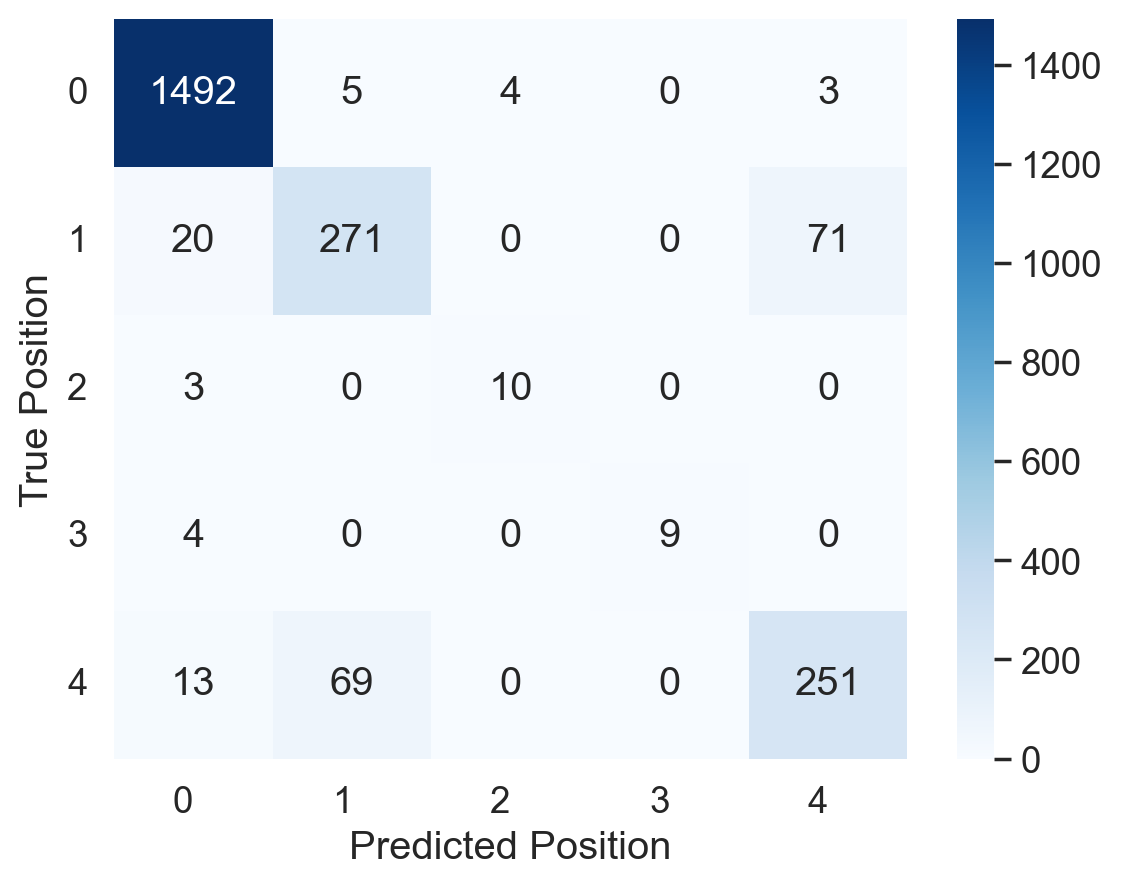

In [147]:
# First, verify the unique classes
unique_positions = merged2_subset['RabbitPosition'].unique()
print("Unique positions:", unique_positions)

# Explicitly create label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(merged2_subset['RabbitPosition'])

# Verify encoded classes
print("Label encoder classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))

# Update confusion matrix visualization
cm = confusion_matrix(labels, predictions)
class_labels = [str(c) for c in label_encoder.classes_]  # Convert to strings
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

utils.show_confusion_matrix(df_cm)

# For classification report
print("\nClassification Report:")
print(classification_report(
    labels, 
    predictions,
    target_names=class_labels,
    zero_division=0
))

#### Look up Class Weights !!!